In [2]:
use_gpu = True

# 测试所有三种模型
model_types = ["baseline", "baseline_large", "vit"]

# 模型路径配置（使用训练好的最佳模型）
model_paths = {
    "baseline": "../pt/baseline/best.pt",
    "baseline_large": "../pt/baseline_large/best.pt",
    "vit": "../pt/vit/best.pt",
}

# 选股阈值（为每个模型单独设置）
thresholds = {
    "baseline": 0.58,
    "baseline_large": 0.58,
    "vit": 0.50,  # ViT 模型使用较低阈值
}

# 存储所有模型的测试结果
all_test_results = {}

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import os
import sys
sys.path.insert(0, '..')
from utils.gpu_tools import *
os.environ["CUDA_LAUNCH_BLOCKING"] = '0'

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

torch.manual_seed(42)

IMAGE_WIDTH = {5: 15, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 20: 64, 60: 96}  

## load data

In [4]:
year_list = np.arange(2001,2020,1)

In [5]:
images = []
label_df = []
for year in year_list:
    images.append(np.memmap(os.path.join("../data/monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r').reshape(
                        (-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20])))
    label_df.append(pd.read_feather(os.path.join("../data/monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather")))
    
images = np.concatenate(images)
label_df = pd.concat(label_df)

print(images.shape)
print(label_df.shape)

(1403975, 64, 60)
(1403975, 8)


## build dataset

In [6]:
class MyDataset(Dataset):
    
    def __init__(self, img, label):
        self.img = torch.Tensor(img.copy())
        self.label = torch.Tensor(label)
        self.len = len(img)
  
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.img[idx], self.label[idx]

In [7]:
dataset = MyDataset(images, (label_df.Ret_20d > 0).values)

In [8]:
test_dataloader = DataLoader(dataset, batch_size=2048, shuffle=False)

## Define Test Functions

In [9]:
from models import baseline, baseline_large, vit
device = 'cuda' if use_gpu else 'cpu'
print(f"Using device: {device}")

def eval_loop(dataloader, net, loss_fn, model_name="model"):
    """
    评估循环
    
    Returns:
        running_loss: 平均 loss
        predict: 预测结果
        target: 真实标签
    """
    running_loss = 0.0
    current = 0
    net.eval()
    target = []
    predict = []
    
    with torch.no_grad():
        with tqdm(dataloader, desc=f"[{model_name}] Eval") as t:
            for batch, (X, y) in enumerate(t):
                X = X.to(device)
                y = y.to(device)
                y_pred = net(X)
                target.append(y.detach())
                predict.append(y_pred.detach())
                loss = loss_fn(y_pred, y.long())
                
                running_loss = (len(X) * loss.item() + running_loss * current) / (len(X) + current)
                current += len(X)
                t.set_postfix({'loss': f'{running_loss:.4f}'})
            
    return running_loss, torch.cat(predict), torch.cat(target)

def calculate_strategy_returns(label_df, predict_logit, threshold=0.58):
    """
    计算策略收益
    
    Returns:
        ret_baseline: 基准收益（买入所有股票）
        ret_strategy: 策略收益（根据模型选股）
    """
    # Baseline: 买入所有股票
    ret_baseline = label_df.groupby(['Date'])['Ret_20d'].mean()
    
    # Strategy: 只买入预测概率 > threshold 的股票
    mask = predict_logit > threshold
    label_filtered = label_df[mask]
    if len(label_filtered) > 0:
        ret_strategy = label_filtered.groupby(['Date'])['Ret_20d'].mean()
    else:
        ret_strategy = pd.Series(dtype=float)
    
    return ret_baseline, ret_strategy

def test_single_model(model_type, model_path, test_dataloader, label_df_original, device, threshold=0.58):
    """
    测试单个模型
    
    Returns:
        results: 包含测试结果的字典
    """
    print(f"\n{'='*60}")
    print(f"Testing Model: {model_type}")
    print(f"Model Path: {model_path}")
    print(f"{'='*60}")
    
    # 检查模型文件是否存在
    if not os.path.exists(model_path):
        print(f"  ⚠️ Model file not found: {model_path}")
        return None
    
    # 加载模型
    net = torch.load(model_path, weights_only=False)
    net = net.to(device)
    
    # 统计参数量
    if hasattr(net, 'module'):
        num_params = sum(p.numel() for p in net.module.parameters())
    else:
        num_params = sum(p.numel() for p in net.parameters())
    print(f"Model Parameters: {num_params:,} ({num_params/1e6:.2f}M)")
    
    # 评估
    loss_fn = nn.CrossEntropyLoss()
    test_loss, y_pred, y_target = eval_loop(test_dataloader, net, loss_fn, model_type)
    
    # 计算预测概率
    predict_logit = (torch.nn.Softmax(dim=1)(y_pred)[:, 1]).cpu().numpy()
    
    # 计算准确率
    y_pred_class = y_pred.argmax(dim=1).cpu().numpy()
    y_target_np = y_target.cpu().numpy()
    accuracy = (y_pred_class == y_target_np).mean()
    
    # 计算策略收益
    label_df_copy = label_df_original.copy()
    ret_baseline, ret_strategy = calculate_strategy_returns(label_df_copy, predict_logit, threshold)
    
    # 计算累计收益
    cum_ret_baseline = (ret_baseline + 1).cumprod().iloc[-1] if len(ret_baseline) > 0 else 1.0
    cum_ret_strategy = (ret_strategy + 1).cumprod().iloc[-1] if len(ret_strategy) > 0 else 1.0
    
    # 计算选中的股票数量
    num_selected = (predict_logit > threshold).sum()
    selection_ratio = num_selected / len(predict_logit) * 100
    
    results = {
        "model_type": model_type,
        "num_params": num_params,
        "test_loss": test_loss,
        "accuracy": accuracy,
        "threshold": threshold,
        "num_selected": int(num_selected),
        "selection_ratio": selection_ratio,
        "cum_ret_baseline": cum_ret_baseline,
        "cum_ret_strategy": cum_ret_strategy,
        "excess_return": cum_ret_strategy - cum_ret_baseline,
        "predict_logit": predict_logit,
        "ret_baseline": ret_baseline,
        "ret_strategy": ret_strategy,
    }
    
    print(f"\nResults:")
    print(f"  Test Loss: {test_loss:.6f}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Selected Stocks: {num_selected:,} ({selection_ratio:.2f}%)")
    print(f"  Cumulative Return (Baseline): {cum_ret_baseline:.4f}")
    print(f"  Cumulative Return (Strategy): {cum_ret_strategy:.4f}")
    print(f"  Excess Return: {cum_ret_strategy - cum_ret_baseline:.4f}")
    
    # 清理 GPU 缓存
    del net
    torch.cuda.empty_cache()
    
    return results

Using device: cuda


In [10]:
# 保存原始 label_df 的副本（用于每个模型的测试）
label_df_original = label_df.copy()

In [21]:
# 测试所有模型
print("\n" + "#"*70)
print("# Testing All Models")
print("#"*70)

for model_type in model_types:
    model_path = model_paths[model_type]
    model_threshold = thresholds[model_type]
    
    results = test_single_model(
        model_type=model_type,
        model_path=model_path,
        test_dataloader=test_dataloader,
        label_df_original=label_df_original,
        device=device,
        threshold=model_threshold
    )
    
    if results is not None:
        all_test_results[model_type] = results

print("\n\n" + "="*70)
print("All Models Testing Complete!")
print("="*70)


######################################################################
# Testing All Models
######################################################################

Testing Model: baseline
Model Path: ../pt/baseline/best.pt
Model Parameters: 708,866 (0.71M)


[baseline] Eval: 100%|██████████| 686/686 [00:28<00:00, 23.96it/s, loss=0.6942]



Results:
  Test Loss: 0.694193
  Accuracy: 0.5158
  Selected Stocks: 25,922 (1.85%)
  Cumulative Return (Baseline): 3.1792
  Cumulative Return (Strategy): 19.8617
  Excess Return: 16.6825

Testing Model: baseline_large
Model Path: ../pt/baseline_large/best.pt
Model Parameters: 10,233,602 (10.23M)


[baseline_large] Eval: 100%|██████████| 686/686 [00:32<00:00, 21.23it/s, loss=0.6926]



Results:
  Test Loss: 0.692632
  Accuracy: 0.5210
  Selected Stocks: 62,823 (4.47%)
  Cumulative Return (Baseline): 3.1792
  Cumulative Return (Strategy): 17.1079
  Excess Return: 13.9287

Testing Model: vit
Model Path: ../pt/vit/best.pt
Model Parameters: 10,821,314 (10.82M)


[vit] Eval: 100%|██████████| 686/686 [01:03<00:00, 10.74it/s, loss=0.6935]



Results:
  Test Loss: 0.693470
  Accuracy: 0.4984
  Selected Stocks: 326,761 (23.27%)
  Cumulative Return (Baseline): 3.1792
  Cumulative Return (Strategy): 2.8440
  Excess Return: -0.3352


All Models Testing Complete!


## Results Summary

In [12]:
# 汇总所有模型的测试结果
print("\n" + "="*100)
print("Test Results Summary")
print("="*100)
print(f"{'Model':<18} {'Params':<12} {'Test Loss':<12} {'Accuracy':<10} {'Selected':<12} {'Cum Ret':<12} {'Excess Ret':<12}")
print("-"*100)

for model_type, results in all_test_results.items():
    print(f"{model_type:<18} {results['num_params']/1e6:.2f}M{'':<5} {results['test_loss']:<12.6f} {results['accuracy']:<10.4f} {results['selection_ratio']:.1f}%{'':<6} {results['cum_ret_strategy']:<12.4f} {results['excess_return']:<12.4f}")

print("="*100)


Test Results Summary
Model              Params       Test Loss    Accuracy   Selected     Cum Ret      Excess Ret  
----------------------------------------------------------------------------------------------------
baseline           0.71M      0.694193     0.5158     1.8%       19.8617      16.6825     
baseline_large     10.23M      0.692632     0.5210     4.5%       17.1079      13.9287     
vit                10.82M      0.693470     0.4984     23.3%       2.8440       -0.3352     


In [13]:
# 生成 Markdown 格式的结果表格
print("\n## Test Results (Markdown Format)\n")
print("| Model | Parameters | Test Loss | Accuracy | Selection % | Cum Return | Excess Return |")
print("|-------|------------|-----------|----------|-------------|------------|---------------|")
for model_type, results in all_test_results.items():
    print(f"| {model_type} | {results['num_params']/1e6:.2f}M | {results['test_loss']:.6f} | {results['accuracy']:.4f} | {results['selection_ratio']:.1f}% | {results['cum_ret_strategy']:.4f} | {results['excess_return']:.4f} |")


## Test Results (Markdown Format)

| Model | Parameters | Test Loss | Accuracy | Selection % | Cum Return | Excess Return |
|-------|------------|-----------|----------|-------------|------------|---------------|
| baseline | 0.71M | 0.694193 | 0.5158 | 1.8% | 19.8617 | 16.6825 |
| baseline_large | 10.23M | 0.692632 | 0.5210 | 4.5% | 17.1079 | 13.9287 |
| vit | 10.82M | 0.693470 | 0.4984 | 23.3% | 2.8440 | -0.3352 |


## Plot Performance Comparison

In [14]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

# 设置绘图风格
plt.style.use('seaborn-v0_8-whitegrid')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

### Cumulative Return Comparison (All Models)

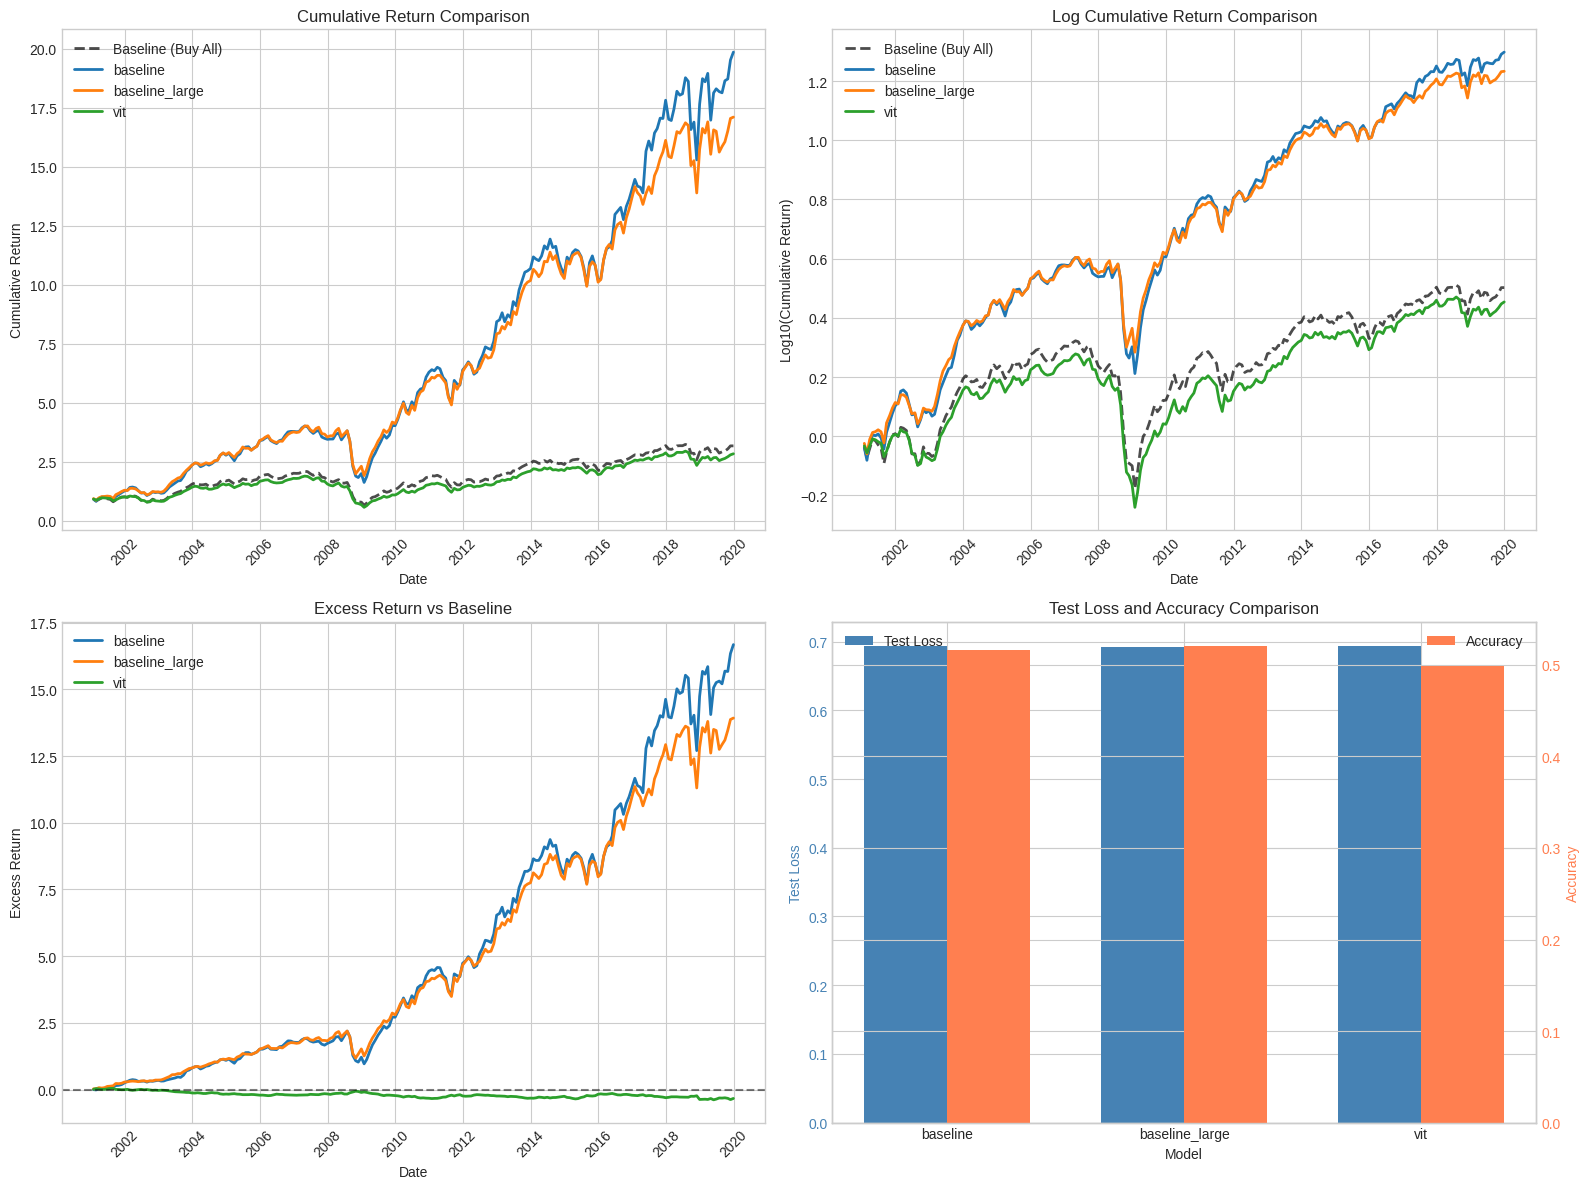


Comparison plot saved to: ../pic/test_comparison.png

Thresholds used:
  baseline: threshold=0.58, selection=1.85%
  baseline_large: threshold=0.58, selection=4.47%
  vit: threshold=0.50, selection=23.27%


In [15]:
# 绘制累计收益对比图
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 累计收益对比（所有模型）
ax1 = axes[0, 0]
# 绘制 baseline（买入所有股票）
if len(all_test_results) > 0:
    first_model = list(all_test_results.keys())[0]
    ret_baseline = all_test_results[first_model]['ret_baseline']
    cum_baseline = (ret_baseline + 1).cumprod()
    ax1.plot(cum_baseline.index, cum_baseline.values, 'k--', label='Baseline (Buy All)', linewidth=2, alpha=0.7)

# 绘制每个模型的策略收益
for i, (model_type, results) in enumerate(all_test_results.items()):
    ret_strategy = results['ret_strategy']
    if len(ret_strategy) > 0:
        cum_strategy = (ret_strategy + 1).cumprod()
        ax1.plot(cum_strategy.index, cum_strategy.values, label=f'{model_type}', linewidth=2, color=colors[i % len(colors)])
    else:
        # 对于没有选中股票的模型，绘制一条水平线表示无收益
        ax1.axhline(y=1.0, label=f'{model_type} (No Selection)', linewidth=2, linestyle=':', color=colors[i % len(colors)], alpha=0.5)

ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Return')
ax1.set_title('Cumulative Return Comparison')
ax1.legend(loc='upper left')
ax1.tick_params(axis='x', rotation=45)

# 2. 对数累计收益对比
ax2 = axes[0, 1]
if len(all_test_results) > 0:
    log_cum_baseline = np.log10(cum_baseline)
    ax2.plot(log_cum_baseline.index, log_cum_baseline.values, 'k--', label='Baseline (Buy All)', linewidth=2, alpha=0.7)

for i, (model_type, results) in enumerate(all_test_results.items()):
    ret_strategy = results['ret_strategy']
    if len(ret_strategy) > 0:
        log_cum_strategy = np.log10((ret_strategy + 1).cumprod())
        ax2.plot(log_cum_strategy.index, log_cum_strategy.values, label=f'{model_type}', linewidth=2, color=colors[i % len(colors)])
    else:
        ax2.axhline(y=0, label=f'{model_type} (No Selection)', linewidth=2, linestyle=':', color=colors[i % len(colors)], alpha=0.5)

ax2.set_xlabel('Date')
ax2.set_ylabel('Log10(Cumulative Return)')
ax2.set_title('Log Cumulative Return Comparison')
ax2.legend(loc='upper left')
ax2.tick_params(axis='x', rotation=45)

# 3. 超额收益对比
ax3 = axes[1, 0]
for i, (model_type, results) in enumerate(all_test_results.items()):
    ret_strategy = results['ret_strategy']
    ret_baseline = results['ret_baseline']
    
    if len(ret_strategy) > 0:
        # 对齐日期
        common_dates = ret_strategy.index.intersection(ret_baseline.index)
        excess_ret = (ret_strategy.loc[common_dates] + 1).cumprod() - (ret_baseline.loc[common_dates] + 1).cumprod()
        ax3.plot(excess_ret.index, excess_ret.values, label=f'{model_type}', linewidth=2, color=colors[i % len(colors)])
    else:
        # 对于没有选中股票的模型，超额收益等于 -baseline 的累计收益
        excess_ret = 1.0 - (ret_baseline + 1).cumprod()
        ax3.plot(excess_ret.index, excess_ret.values, label=f'{model_type} (No Selection)', linewidth=2, linestyle=':', color=colors[i % len(colors)], alpha=0.5)

ax3.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax3.set_xlabel('Date')
ax3.set_ylabel('Excess Return')
ax3.set_title('Excess Return vs Baseline')
ax3.legend(loc='upper left')
ax3.tick_params(axis='x', rotation=45)

# 4. 测试指标对比（柱状图）
ax4 = axes[1, 1]
model_names = list(all_test_results.keys())
test_losses = [all_test_results[m]['test_loss'] for m in model_names]
accuracies = [all_test_results[m]['accuracy'] for m in model_names]

x = np.arange(len(model_names))
width = 0.35

bars1 = ax4.bar(x - width/2, test_losses, width, label='Test Loss', color='steelblue')
ax4.set_ylabel('Test Loss', color='steelblue')
ax4.tick_params(axis='y', labelcolor='steelblue')

ax4_twin = ax4.twinx()
bars2 = ax4_twin.bar(x + width/2, accuracies, width, label='Accuracy', color='coral')
ax4_twin.set_ylabel('Accuracy', color='coral')
ax4_twin.tick_params(axis='y', labelcolor='coral')

ax4.set_xlabel('Model')
ax4.set_title('Test Loss and Accuracy Comparison')
ax4.set_xticks(x)
ax4.set_xticklabels(model_names)
ax4.legend(loc='upper left')
ax4_twin.legend(loc='upper right')

plt.tight_layout()
plt.savefig('../pic/test_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nComparison plot saved to: ../pic/test_comparison.png")
print("\nThresholds used:")
for model_type in model_types:
    t = thresholds[model_type]
    sel_ratio = all_test_results[model_type]['selection_ratio'] if model_type in all_test_results else 0
    print(f"  {model_type}: threshold={t:.2f}, selection={sel_ratio:.2f}%")


### Number of Stocks Selected Over Time

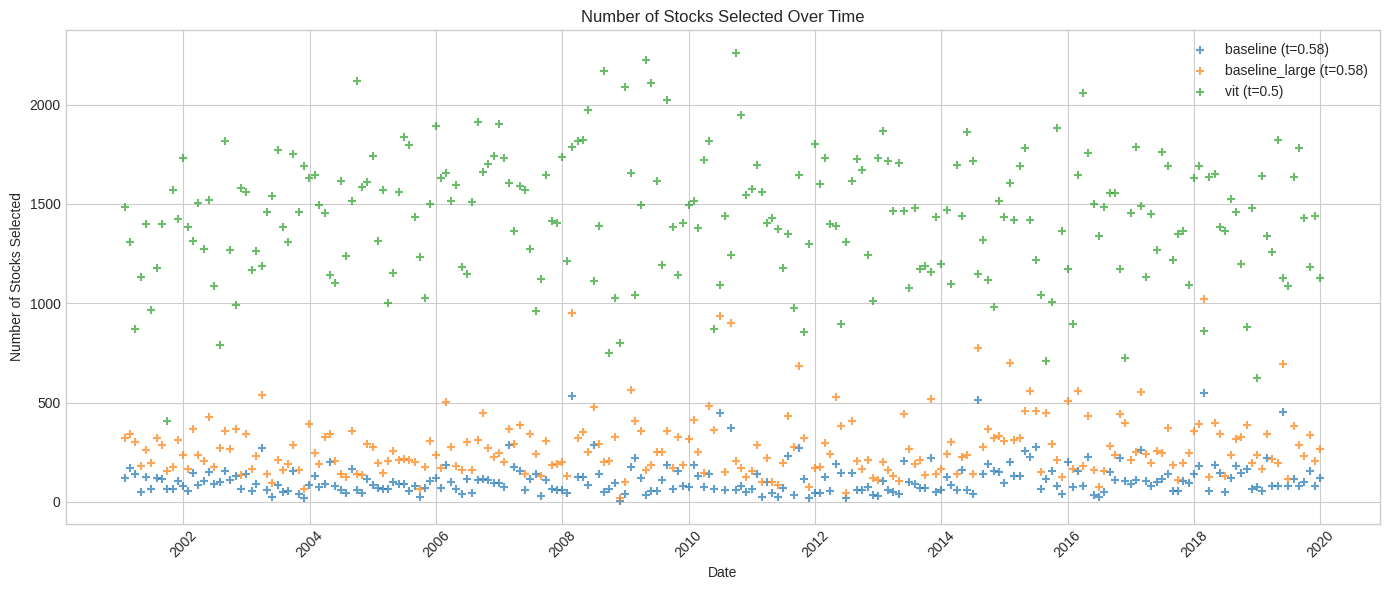


Stocks selected plot saved to: ../pic/stocks_selected.png


In [16]:
# 绘制每个模型随时间选中的股票数量
fig, ax = plt.subplots(figsize=(14, 6))

for i, (model_type, results) in enumerate(all_test_results.items()):
    predict_logit = results['predict_logit']
    model_threshold = results['threshold']  # 使用每个模型对应的阈值
    mask = predict_logit > model_threshold
    
    # 获取选中股票的日期分布
    label_filtered = label_df_original[mask]
    stocks_per_date = label_filtered.groupby(['Date']).size()
    
    ax.scatter(stocks_per_date.index, stocks_per_date.values, 
               marker='+', label=f'{model_type} (t={model_threshold})', alpha=0.7, s=30)

ax.set_xlabel('Date')
ax.set_ylabel('Number of Stocks Selected')
ax.set_title('Number of Stocks Selected Over Time')
ax.legend()
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../pic/stocks_selected.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nStocks selected plot saved to: ../pic/stocks_selected.png")

## Save Results to JSON

In [17]:
import json

# 保存结果到 JSON（排除不可序列化的对象）
results_for_json = {}
for model_type, results in all_test_results.items():
    results_for_json[model_type] = {
        "model_type": results["model_type"],
        "num_params": results["num_params"],
        "test_loss": results["test_loss"],
        "accuracy": float(results["accuracy"]),
        "threshold": results["threshold"],
        "num_selected": results["num_selected"],
        "selection_ratio": results["selection_ratio"],
        "cum_ret_baseline": float(results["cum_ret_baseline"]),
        "cum_ret_strategy": float(results["cum_ret_strategy"]),
        "excess_return": float(results["excess_return"]),
    }

with open('../pt/test_results.json', 'w') as f:
    json.dump(results_for_json, f, indent=2)

print("Results saved to: ../pt/test_results.json")
print(json.dumps(results_for_json, indent=2))


Results saved to: ../pt/test_results.json
{
  "baseline": {
    "model_type": "baseline",
    "num_params": 708866,
    "test_loss": 0.6941931889320337,
    "accuracy": 0.5157876742819495,
    "threshold": 0.58,
    "num_selected": 25922,
    "selection_ratio": 1.8463291725280009,
    "cum_ret_baseline": 3.1791877065489427,
    "cum_ret_strategy": 19.861671007656867,
    "excess_return": 16.682483301107922
  },
  "baseline_large": {
    "model_type": "baseline_large",
    "num_params": 10233602,
    "test_loss": 0.6926317815465293,
    "accuracy": 0.521027083815595,
    "threshold": 0.58,
    "num_selected": 62823,
    "selection_ratio": 4.474652326430314,
    "cum_ret_baseline": 3.1791877065489427,
    "cum_ret_strategy": 17.1078770583634,
    "excess_return": 13.928689351814457
  },
  "vit": {
    "model_type": "vit",
    "num_params": 10821314,
    "test_loss": 0.693470492503414,
    "accuracy": 0.49838494275182965,
    "threshold": 0.5,
    "num_selected": 326761,
    "selection_ra

In [18]:
# 找出最佳模型
if len(all_test_results) > 0:
    best_model = max(all_test_results.keys(), key=lambda x: all_test_results[x]['cum_ret_strategy'])
    best_results = all_test_results[best_model]
    
    print("\n" + "="*60)
    print("Best Model Summary")
    print("="*60)
    print(f"Best Model: {best_model}")
    print(f"Test Loss: {best_results['test_loss']:.6f}")
    print(f"Accuracy: {best_results['accuracy']:.4f}")
    print(f"Cumulative Return: {best_results['cum_ret_strategy']:.4f}")
    print(f"Excess Return: {best_results['excess_return']:.4f}")
    print("="*60)


Best Model Summary
Best Model: baseline
Test Loss: 0.694193
Accuracy: 0.5158
Cumulative Return: 19.8617
Excess Return: 16.6825


## Output Files Summary

In [19]:
print("\nOutput Files:")
print("-" * 40)
print("📊 Plots:")
print("  - ../pic/test_comparison.png")
print("  - ../pic/stocks_selected.png")
print("\n📄 Data:")
print("  - ../pt/test_results.json")
print("\n✅ Testing Complete!")


Output Files:
----------------------------------------
📊 Plots:
  - ../pic/test_comparison.png
  - ../pic/stocks_selected.png

📄 Data:
  - ../pt/test_results.json

✅ Testing Complete!


In [22]:
# End of test notebook

In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
import os
from collections import defaultdict

class MultiLayerGradCAM:
    """
    多层Grad-CAM实现，可以同时分析多个卷积层
    """
    
    def __init__(self, model):
        self.model = model
        self.conv_layers = []
        self.layer_activations = {}
        self.layer_gradients = {}
        self.hooks = []
        
        # 找到所有卷积层
        self._find_all_conv_layers()
    
    def _find_all_conv_layers(self):
        """找到所有卷积层"""
        model = self.model.module if hasattr(self.model, 'module') else self.model
        
        print(f"\n🔍 Finding all convolution layers...")
        
        for name, module in model.named_modules():
            if isinstance(module, (torch.nn.Conv2d, torch.nn.Conv1d)):
                self.conv_layers.append((name, module))
                print(f"🔍 Found convolution layer: {name} - {type(module).__name__}")
                if isinstance(module, torch.nn.Conv2d):
                    print(f"    Conv2d: {module.in_channels}→{module.out_channels}, "
                          f"kernel={module.kernel_size}, stride={module.stride}")
                elif isinstance(module, torch.nn.Conv1d):
                    print(f"    Conv1d: {module.in_channels}→{module.out_channels}, "
                          f"kernel={module.kernel_size}, stride={module.stride}")
        
        print(f"✅ Found {len(self.conv_layers)} convolution layers")
    
    def _register_hooks_for_all_layers(self):
        """为所有卷积层注册钩子"""
        def make_forward_hook(layer_name):
            def forward_hook(module, input, output):
                self.layer_activations[layer_name] = output.detach()
                print(f"🔍 Forward hook [{layer_name}] - Shape: {output.shape}")
            return forward_hook
        
        def make_backward_hook(layer_name):
            def backward_hook(module, grad_input, grad_output):
                if grad_output[0] is not None:
                    self.layer_gradients[layer_name] = grad_output[0].detach()
                    print(f"🔍 Backward hook [{layer_name}] - Shape: {grad_output[0].shape}")
            return backward_hook
        
        # 清理旧钩子
        self._remove_hooks()
        
        # 为每个卷积层注册钩子
        for layer_name, layer_module in self.conv_layers:
            forward_hook = make_forward_hook(layer_name)
            backward_hook = make_backward_hook(layer_name)
            
            self.hooks.append(layer_module.register_forward_hook(forward_hook))
            self.hooks.append(layer_module.register_full_backward_hook(backward_hook))
    
    def _remove_hooks(self):
        """移除所有钩子"""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
    
    def generate_multi_layer_cam(self, input_tensor, target_class):
        """
        生成多层CAM
        
        Returns:
            layer_cams: 字典，包含每层的CAM
            prediction_info: 预测信息
        """
        print(f"\n📏 Input tensor shape: {input_tensor.shape}")
        
        # 注册所有层的钩子
        self._register_hooks_for_all_layers()
        
        self.model.eval()
        self.layer_activations = {}
        self.layer_gradients = {}
        
        # 确保输入需要梯度
        input_tensor = input_tensor.clone().detach().requires_grad_(True)
        
        try:
            # 前向传播
            outputs = self.model(input_tensor)
            print(f"📏 Model output shape: {outputs.shape}")
            
            # 获取预测信息
            probabilities = torch.nn.Softmax(dim=1)(outputs)
            predicted_class = outputs.argmax(dim=1).item()
            confidence = probabilities[0, predicted_class].item()
            
            prediction_info = {
                'predicted_class': predicted_class,
                'predicted_label': 'UP' if predicted_class == 1 else 'DOWN',
                'target_class': target_class,
                'target_label': 'UP' if target_class == 1 else 'DOWN',
                'confidence': confidence,
                'up_prob': probabilities[0, 1].item(),
                'down_prob': probabilities[0, 0].item()
            }
            
            # 反向传播
            self.model.zero_grad()
            target_score = outputs[0, target_class]
            target_score.backward(retain_graph=False)
            
            # 为每层生成CAM
            layer_cams = {}
            
            for layer_name, _ in self.conv_layers:
                if layer_name in self.layer_activations and layer_name in self.layer_gradients:
                    activations = self.layer_activations[layer_name]
                    gradients = self.layer_gradients[layer_name]
                    
                    print(f"\n🔧 Processing layer: {layer_name}")
                    print(f"📏 Activations shape: {activations.shape}")
                    print(f"📏 Gradients shape: {gradients.shape}")
                    
                    # 计算CAM
                    if len(gradients.shape) == 4:  # Conv2D
                        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
                        cam = torch.sum(weights * activations, dim=1, keepdim=True)
                    elif len(gradients.shape) == 3:  # Conv1D
                        weights = torch.mean(gradients, dim=2, keepdim=True)
                        cam = torch.sum(weights * activations, dim=1, keepdim=True)
                    else:
                        continue
                    
                    # ReLU激活和归一化
                    cam = F.relu(cam)
                    cam = cam.squeeze().cpu().numpy()
                    
                    if cam.ndim == 0:
                        cam = np.array([[cam]])
                    elif cam.ndim == 1:
                        size = cam.shape[0]
                        sqrt_size = int(np.sqrt(size))
                        if sqrt_size * sqrt_size == size:
                            cam = cam.reshape(sqrt_size, sqrt_size)
                        else:
                            cam = cam.reshape(1, -1)
                    
                    # 归一化到[0,1]
                    if cam.max() > cam.min():
                        cam = (cam - cam.min()) / (cam.max() - cam.min())
                    
                    layer_cams[layer_name] = cam
                    print(f"📏 CAM shape for {layer_name}: {cam.shape}")
            
            return layer_cams, prediction_info
            
        except Exception as e:
            print(f"❌ Error in generate_multi_layer_cam: {e}")
            return {}, prediction_info
        finally:
            # 清理钩子
            self._remove_hooks()
    
    def __del__(self):
        """清理钩子"""
        self._remove_hooks()

class StockReturnMultiLayerGradCAM:
    """
    多层股票收益预测Grad-CAM可视化类
    """
    
    def __init__(self, model, model_type, device):
        self.model = model
        self.model_type = model_type
        self.device = device
        self.multi_gradcam = None
        
        try:
            self.multi_gradcam = MultiLayerGradCAM(model)
        except Exception as e:
            print(f"Warning: Failed to initialize Multi-Layer GradCAM: {e}")
    
    def visualize_multi_layer_prediction(self, input_tensor, save_path=None, title_prefix=""):
        """
        可视化多层预测激活区域 - 只显示预测类别的激活图
        """
        try:
            print(f"\n🎨 Starting multi-layer visualization for input shape: {input_tensor.shape}")
            
            # 首先获取预测结果
            with torch.no_grad():
                outputs = self.model(input_tensor)
                predicted_class = outputs.argmax(dim=1).item()
                probabilities = torch.nn.Softmax(dim=1)(outputs)
                confidence = probabilities[0, predicted_class].item()
            
            predicted_label = 'UP' if predicted_class == 1 else 'DOWN'
            print(f"🎯 Predicted class: {predicted_label} (confidence: {confidence:.3f})")
            
            # 只为预测的类别生成激活图
            layer_cams, pred_info = self.multi_gradcam.generate_multi_layer_cam(input_tensor, target_class=predicted_class)
            
            # 准备输入图像
            input_image = self._prepare_input_for_visualization(input_tensor)
            
            # 获取层名列表
            layer_names = list(layer_cams.keys())
            num_layers = len(layer_names)
            
            if num_layers == 0:
                print("⚠️ No CAMs generated")
                return None, None
            
            # 创建图：2行，第一列是原图和预测信息，其他列是各层激活图
            fig, axes = plt.subplots(2, num_layers + 1, figsize=(6 * (num_layers + 1), 12))
            
            # 如果只有一层，确保axes是2D数组
            if num_layers == 1:
                axes = axes.reshape(2, -1)
            elif num_layers == 0:
                axes = axes.reshape(2, 1)
            
            # 设置颜色主题
            color = 'green' if predicted_label == 'UP' else 'red'
            cmap = 'Greens' if predicted_label == 'UP' else 'Reds'
            
            # 第一列：原始输入和预测信息
            axes[0, 0].imshow(input_image, cmap='viridis', aspect='auto')
            axes[0, 0].set_title('Original Input\n(Financial Features)', fontsize=12, fontweight='bold')
            axes[0, 0].axis('off')
            
            # 预测信息
            info_text = f'🎯 Prediction: {predicted_label}\n'
            info_text += f'📊 Confidence: {confidence:.3f}\n'
            info_text += f'📈 UP Prob: {pred_info["up_prob"]:.3f}\n'
            info_text += f'📉 DOWN Prob: {pred_info["down_prob"]:.3f}'
            
            axes[1, 0].text(0.5, 0.5, info_text,
                           ha='center', va='center', fontsize=14, fontweight='bold',
                           bbox=dict(boxstyle="round,pad=0.5", facecolor=color, alpha=0.3))
            axes[1, 0].axis('off')
            
            # 其他列：每层的激活图
            for i, layer_name in enumerate(layer_names):
                col_idx = i + 1
                
                # 预测类别的激活图
                if layer_name in layer_cams:
                    cam = layer_cams[layer_name]
                    
                    # 主激活图
                    im1 = axes[0, col_idx].imshow(cam, cmap='jet', aspect='auto')
                    axes[0, col_idx].set_title(f'{layer_name}\n{predicted_label} Activation\nShape: {cam.shape}', 
                                              fontsize=10, fontweight='bold', color=color)
                    axes[0, col_idx].axis('off')
                    plt.colorbar(im1, ax=axes[0, col_idx], fraction=0.046, pad=0.04)
                    
                    # 叠加图（如果可能）
                    try:
                        overlay = self._create_overlay(input_image, cam)
                        axes[1, col_idx].imshow(overlay)
                        axes[1, col_idx].set_title(f'{layer_name}\nOverlay on Input', 
                                                  fontsize=10, fontweight='bold', color=color)
                        axes[1, col_idx].axis('off')
                    except Exception as e:
                        # 如果叠加失败，显示热力图版本
                        im2 = axes[1, col_idx].imshow(cam, cmap=cmap, aspect='auto')
                        axes[1, col_idx].set_title(f'{layer_name}\nHeatmap', 
                                                  fontsize=10, fontweight='bold', color=color)
                        axes[1, col_idx].axis('off')
                        plt.colorbar(im2, ax=axes[1, col_idx], fraction=0.046, pad=0.04)
            
            # 设置总标题
            plt.suptitle(f'{title_prefix}{predicted_label} Prediction Analysis - {self.model_type}', 
                         fontsize=16, fontweight='bold', color=color)
            plt.tight_layout()
            
            if save_path:
                plt.savefig(save_path, dpi=300, bbox_inches='tight')
                print(f"Multi-layer visualization saved to: {save_path}")
            
            plt.show()
            
            return pred_info, layer_cams
            
        except Exception as e:
            print(f"Error in multi-layer visualization: {e}")
            import traceback
            traceback.print_exc()
            return None, None
    
    def _prepare_input_for_visualization(self, input_tensor):
        """准备输入张量用于可视化"""
        input_array = input_tensor.squeeze().cpu().numpy()
        
        # 处理不同的输入形状
        if len(input_array.shape) == 3:  # (C, H, W)
            if input_array.shape[0] <= 3:  # 通道数较少
                input_array = np.transpose(input_array, (1, 2, 0))
                if input_array.shape[2] == 1:
                    input_array = input_array.squeeze()
            else:  # 特征图，取平均
                input_array = np.mean(input_array, axis=0)
        elif len(input_array.shape) == 1:
            # 1D数据reshape为2D
            size = input_array.shape[0]
            sqrt_size = int(np.sqrt(size))
            if sqrt_size * sqrt_size == size:
                input_array = input_array.reshape(sqrt_size, sqrt_size)
            else:
                factors = []
                for i in range(1, int(np.sqrt(size)) + 1):
                    if size % i == 0:
                        factors.append((i, size // i))
                if factors:
                    h, w = factors[-1]
                    input_array = input_array.reshape(h, w)
        
        # 归一化到[0,1]
        input_array = (input_array - input_array.min()) / (input_array.max() - input_array.min() + 1e-8)
        
        # 确保是RGB格式
        if len(input_array.shape) == 2:
            input_array = np.stack([input_array] * 3, axis=-1)
        
        return input_array
    
    def _create_overlay(self, input_image, cam):
        """创建叠加图像"""
        try:
            # 将CAM调整到输入图像的大小
            target_height, target_width = input_image.shape[:2]
            
            if cam.shape != (target_height, target_width):
                cam_resized = cv2.resize(cam.astype(np.float32), 
                                       (target_width, target_height), 
                                       interpolation=cv2.INTER_LINEAR)
            else:
                cam_resized = cam
            
            # 创建热力图
            heatmap = plt.cm.jet(cam_resized)[:, :, :3]  # 去掉alpha通道
            
            # 叠加
            overlay = 0.6 * input_image + 0.4 * heatmap
            overlay = np.clip(overlay, 0, 1)
            
            return overlay
        except Exception as e:
            print(f"❌ Error creating overlay: {e}")
            return input_image

def analyze_multi_layer_patterns(model, dataloader, model_type, device, num_samples=5, save_dir="multi_layer_gradcam"):
    """
    分析多层预测模式 - 只显示预测类别的激活
    """
    os.makedirs(save_dir, exist_ok=True)
    
    # 初始化多层Grad-CAM
    try:
        gradcam_analyzer = StockReturnMultiLayerGradCAM(model, model_type, device)
    except Exception as e:
        print(f"Failed to initialize Multi-Layer Grad-CAM: {e}")
        return None
    
    # 收集样本
    samples = []
    model.eval()
    sample_count = 0
    
    print("Collecting samples for multi-layer analysis...")
    
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(dataloader):
            if sample_count >= num_samples:
                break
                
            X = X.to(device)
            y = y.to(device)
            
            outputs = model(X)
            predictions = outputs.argmax(dim=1)
            
            for i in range(X.size(0)):
                if sample_count >= num_samples:
                    break
                
                input_sample = X[i:i+1]
                true_label = y[i].item()
                pred_label = predictions[i].item()
                
                samples.append({
                    'input': input_sample,
                    'true_label': true_label,
                    'pred_label': pred_label,
                    'sample_id': sample_count
                })
                
                sample_count += 1
    
    print(f"Collected {len(samples)} samples")
    
    # 分析样本
    for sample in samples:
        try:
            pred_label_str = "UP" if sample['pred_label'] == 1 else "DOWN"
            true_label_str = "UP" if sample['true_label'] == 1 else "DOWN"
            
            save_path = os.path.join(save_dir, f"{pred_label_str}_prediction_sample_{sample['sample_id']}.png")
            title = f"Sample {sample['sample_id']} (True: {true_label_str}, Pred: {pred_label_str}) - "
            
            result = gradcam_analyzer.visualize_multi_layer_prediction(
                sample['input'], save_path, title
            )
            
            if result[0] is not None:
                print(f"✅ Successfully analyzed {pred_label_str} prediction for sample {sample['sample_id']}")
            else:
                print(f"⚠️ Failed to analyze sample {sample['sample_id']}")
                
        except Exception as e:
            print(f"Error analyzing sample {sample['sample_id']}: {e}")
    
    return gradcam_analyzer

In [51]:
def test_single_model_with_gradcam(model_type, model_path, test_dataloader, label_df_original, device, 
                                  threshold=0.58, enable_gradcam=True, gradcam_samples=10):
    """
    测试单个模型并进行自定义Grad-CAM分析
    """
    print(f"\n{'='*60}")
    print(f"Testing Model with Custom Grad-CAM Analysis: {model_type}")
    print(f"Model Path: {model_path}")
    print(f"{'='*60}")
    
    # 检查模型文件是否存在
    if not os.path.exists(model_path):
        print(f"  ⚠️ Model file not found: {model_path}")
        return None
    
    # 加载模型
    net = torch.load(model_path, weights_only=False)
    net = net.to(device)
    
    # 统计参数量
    if hasattr(net, 'module'):
        num_params = sum(p.numel() for p in net.module.parameters())
    else:
        num_params = sum(p.numel() for p in net.parameters())
    print(f"Model Parameters: {num_params:,} ({num_params/1e6:.2f}M)")
    
    # 评估
    loss_fn = nn.CrossEntropyLoss()
    test_loss, y_pred, y_target = eval_loop(test_dataloader, net, loss_fn, model_type)
    
    # 计算预测概率
    predict_logit = (torch.nn.Softmax(dim=1)(y_pred)[:, 1]).cpu().numpy()
    
    # 计算准确率
    y_pred_class = y_pred.argmax(dim=1).cpu().numpy()
    y_target_np = y_target.cpu().numpy()
    accuracy = (y_pred_class == y_target_np).mean()
    
    # 自定义Grad-CAM分析
    if enable_gradcam:
        print(f"\n🔍 Performing Custom Grad-CAM Analysis...")
        gradcam_dir = f"gradcam_analysis_{model_type.replace('/', '_')}"
        
        try:
            gradcam_analyzer = analyze_multi_layer_patterns(
                net, test_dataloader, model_type, device, 
                num_samples=gradcam_samples, save_dir=gradcam_dir
            )
            if gradcam_analyzer:
                print(f"✅ Custom Grad-CAM analysis completed. Results saved to: {gradcam_dir}")
            else:
                print(f"⚠️ Custom Grad-CAM analysis failed to initialize")
        except Exception as e:
            print(f"❌ Custom Grad-CAM analysis failed: {e}")
            import traceback
            traceback.print_exc()
    
    # 计算策略收益
    label_df_copy = label_df_original.copy()
    ret_baseline, ret_strategy = calculate_strategy_returns(label_df_copy, predict_logit, threshold)
    
    # 计算累计收益
    cum_ret_baseline = (ret_baseline + 1).cumprod().iloc[-1] if len(ret_baseline) > 0 else 1.0
    cum_ret_strategy = (ret_strategy + 1).cumprod().iloc[-1] if len(ret_strategy) > 0 else 1.0
    
    # 计算选中的股票数量
    num_selected = (predict_logit > threshold).sum()
    selection_ratio = num_selected / len(predict_logit) * 100
    
    results = {
        "model_type": model_type,
        "num_params": num_params,
        "test_loss": test_loss,
        "accuracy": accuracy,
        "threshold": threshold,
        "num_selected": int(num_selected),
        "selection_ratio": selection_ratio,
        "cum_ret_baseline": cum_ret_baseline,
        "cum_ret_strategy": cum_ret_strategy,
        "excess_return": cum_ret_strategy - cum_ret_baseline,
        "predict_logit": predict_logit,
        "ret_baseline": ret_baseline,
        "ret_strategy": ret_strategy,
    }
    
    print(f"\n📊 Results Summary:")
    print(f"  Test Loss: {test_loss:.6f}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Selected Stocks: {num_selected:,} ({selection_ratio:.2f}%)")
    print(f"  Cumulative Return (Baseline): {cum_ret_baseline:.4f}")
    print(f"  Cumulative Return (Strategy): {cum_ret_strategy:.4f}")
    print(f"  Excess Return: {cum_ret_strategy - cum_ret_baseline:.4f}")
    
    # 清理 GPU 缓存
    del net
    torch.cuda.empty_cache()
    
    return results


######################################################################
# Testing All Models
######################################################################

Testing Model with Custom Grad-CAM Analysis: baseline
Model Path: ../pt/baseline/best.pt
Model Parameters: 708,866 (0.71M)


[baseline] Eval:   0%|          | 3/686 [00:00<00:29, 23.53it/s, loss=0.6988]

[baseline] Eval: 100%|██████████| 686/686 [00:27<00:00, 25.33it/s, loss=0.6942]



🔍 Performing Custom Grad-CAM Analysis...

🔍 Finding all convolution layers...
🔍 Found convolution layer: layer1.0 - Conv2d
    Conv2d: 1→64, kernel=(5, 3), stride=(3, 1)
🔍 Found convolution layer: layer2.0 - Conv2d
    Conv2d: 64→128, kernel=(5, 3), stride=(3, 1)
🔍 Found convolution layer: layer3.0 - Conv2d
    Conv2d: 128→256, kernel=(5, 3), stride=(3, 1)
✅ Found 3 convolution layers
Collected 10 samples

🎨 Starting multi-layer visualization for input shape: torch.Size([1, 64, 60])
🎯 Predicted class: DOWN (confidence: 0.542)

📏 Input tensor shape: torch.Size([1, 64, 60])
🔍 Forward hook [layer1.0] - Shape: torch.Size([1, 64, 27, 60])
🔍 Forward hook [layer2.0] - Shape: torch.Size([1, 128, 10, 60])
🔍 Forward hook [layer3.0] - Shape: torch.Size([1, 256, 7, 60])
📏 Model output shape: torch.Size([1, 2])
🔍 Backward hook [layer3.0] - Shape: torch.Size([1, 256, 7, 60])
🔍 Backward hook [layer2.0] - Shape: torch.Size([1, 128, 10, 60])
🔍 Backward hook [layer1.0] - Shape: torch.Size([1, 64, 27, 6

/tmp/ipykernel_367918/2734553591.py:286: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_367918/2734553591.py:286: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_367918/2734553591.py:286: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_367918/2734553591.py:286: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_367918/2734553591.py:289: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Liberation Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
/tmp/ipykernel_367918/2734553591.py:289: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
/tmp/ipykernel_367918/2734553591.py:289: UserW

Multi-layer visualization saved to: gradcam_analysis_baseline/DOWN_prediction_sample_0.png


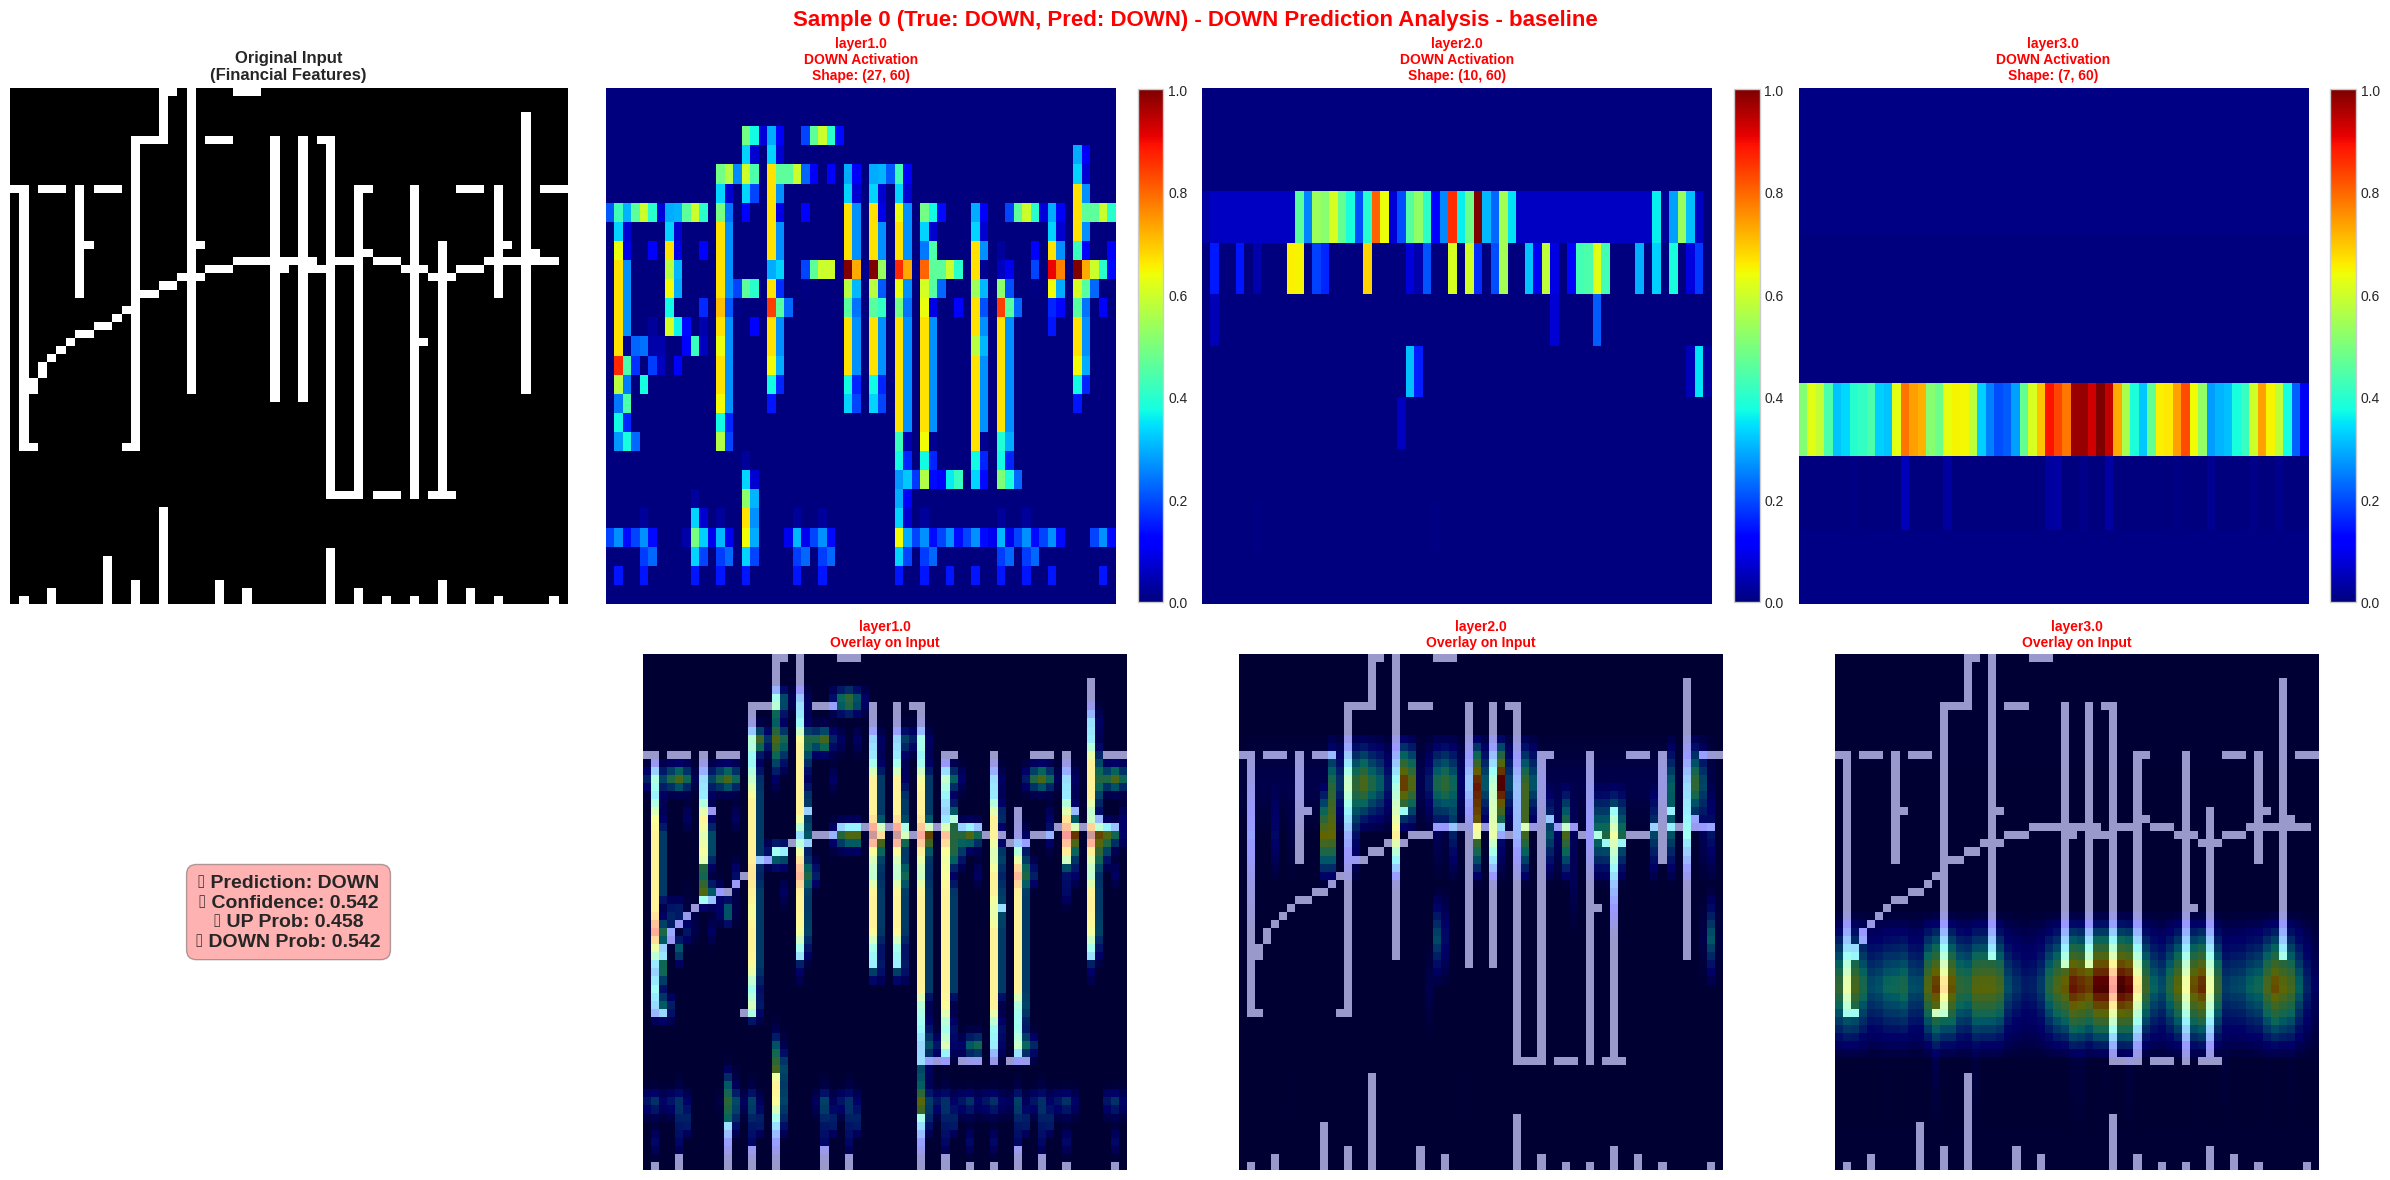

✅ Successfully analyzed DOWN prediction for sample 0

🎨 Starting multi-layer visualization for input shape: torch.Size([1, 64, 60])
🎯 Predicted class: DOWN (confidence: 0.562)

📏 Input tensor shape: torch.Size([1, 64, 60])
🔍 Forward hook [layer1.0] - Shape: torch.Size([1, 64, 27, 60])
🔍 Forward hook [layer2.0] - Shape: torch.Size([1, 128, 10, 60])
🔍 Forward hook [layer3.0] - Shape: torch.Size([1, 256, 7, 60])
📏 Model output shape: torch.Size([1, 2])
🔍 Backward hook [layer3.0] - Shape: torch.Size([1, 256, 7, 60])
🔍 Backward hook [layer2.0] - Shape: torch.Size([1, 128, 10, 60])
🔍 Backward hook [layer1.0] - Shape: torch.Size([1, 64, 27, 60])

🔧 Processing layer: layer1.0
📏 Activations shape: torch.Size([1, 64, 27, 60])
📏 Gradients shape: torch.Size([1, 64, 27, 60])
📏 CAM shape for layer1.0: (27, 60)

🔧 Processing layer: layer2.0
📏 Activations shape: torch.Size([1, 128, 10, 60])
📏 Gradients shape: torch.Size([1, 128, 10, 60])
📏 CAM shape for layer2.0: (10, 60)

🔧 Processing layer: layer3.0

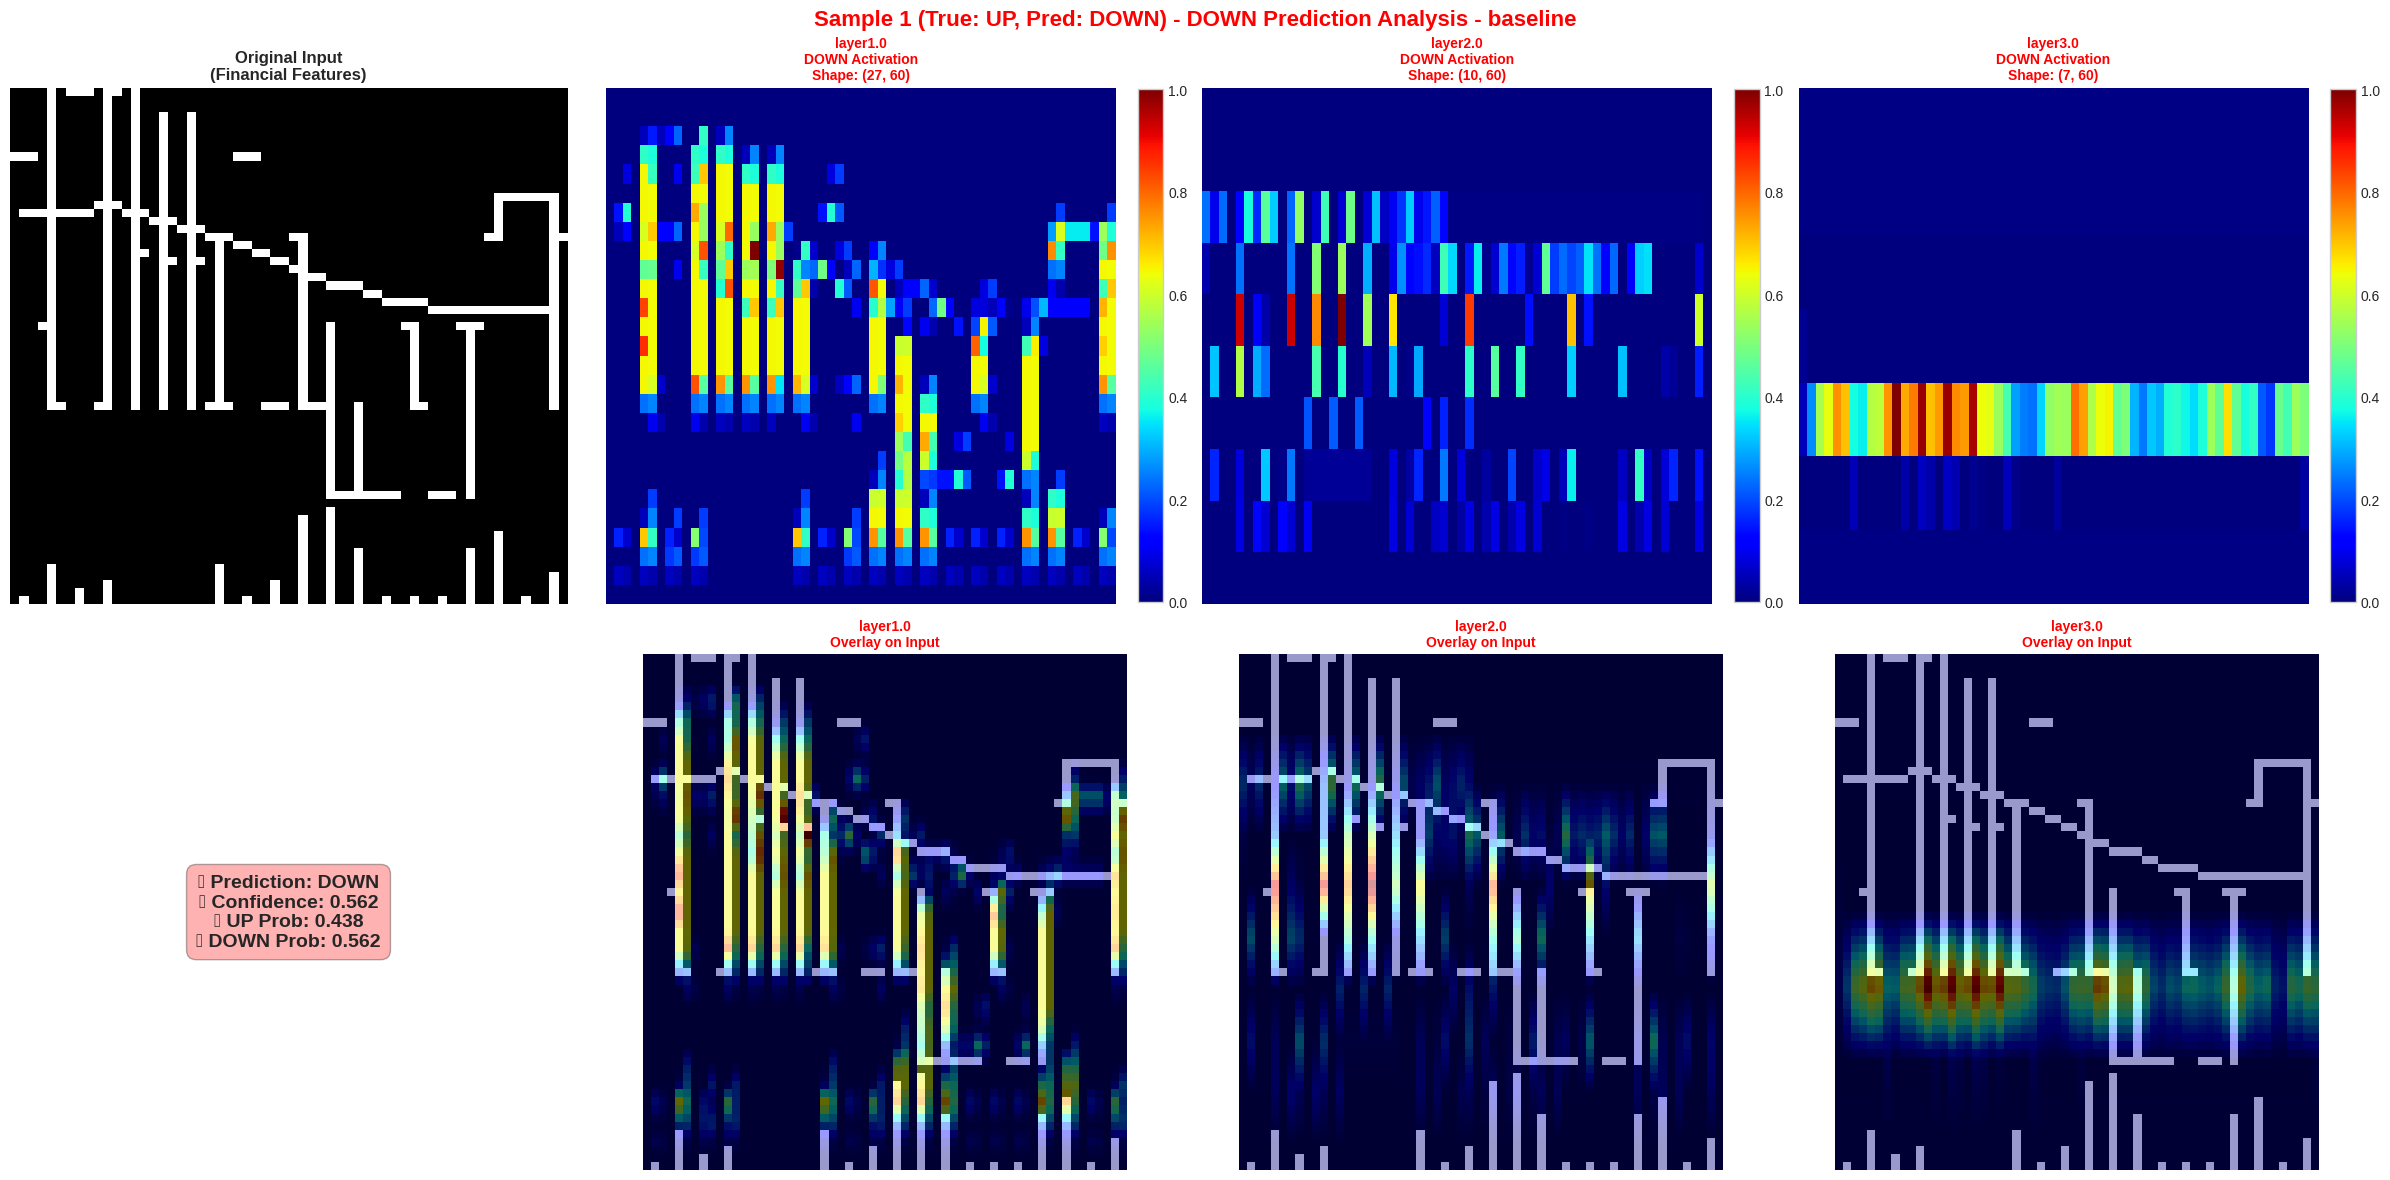

✅ Successfully analyzed DOWN prediction for sample 1

🎨 Starting multi-layer visualization for input shape: torch.Size([1, 64, 60])
🎯 Predicted class: DOWN (confidence: 0.591)

📏 Input tensor shape: torch.Size([1, 64, 60])
🔍 Forward hook [layer1.0] - Shape: torch.Size([1, 64, 27, 60])
🔍 Forward hook [layer2.0] - Shape: torch.Size([1, 128, 10, 60])
🔍 Forward hook [layer3.0] - Shape: torch.Size([1, 256, 7, 60])
📏 Model output shape: torch.Size([1, 2])
🔍 Backward hook [layer3.0] - Shape: torch.Size([1, 256, 7, 60])
🔍 Backward hook [layer2.0] - Shape: torch.Size([1, 128, 10, 60])
🔍 Backward hook [layer1.0] - Shape: torch.Size([1, 64, 27, 60])

🔧 Processing layer: layer1.0
📏 Activations shape: torch.Size([1, 64, 27, 60])
📏 Gradients shape: torch.Size([1, 64, 27, 60])
📏 CAM shape for layer1.0: (27, 60)

🔧 Processing layer: layer2.0
📏 Activations shape: torch.Size([1, 128, 10, 60])
📏 Gradients shape: torch.Size([1, 128, 10, 60])
📏 CAM shape for layer2.0: (10, 60)

🔧 Processing layer: layer3.0

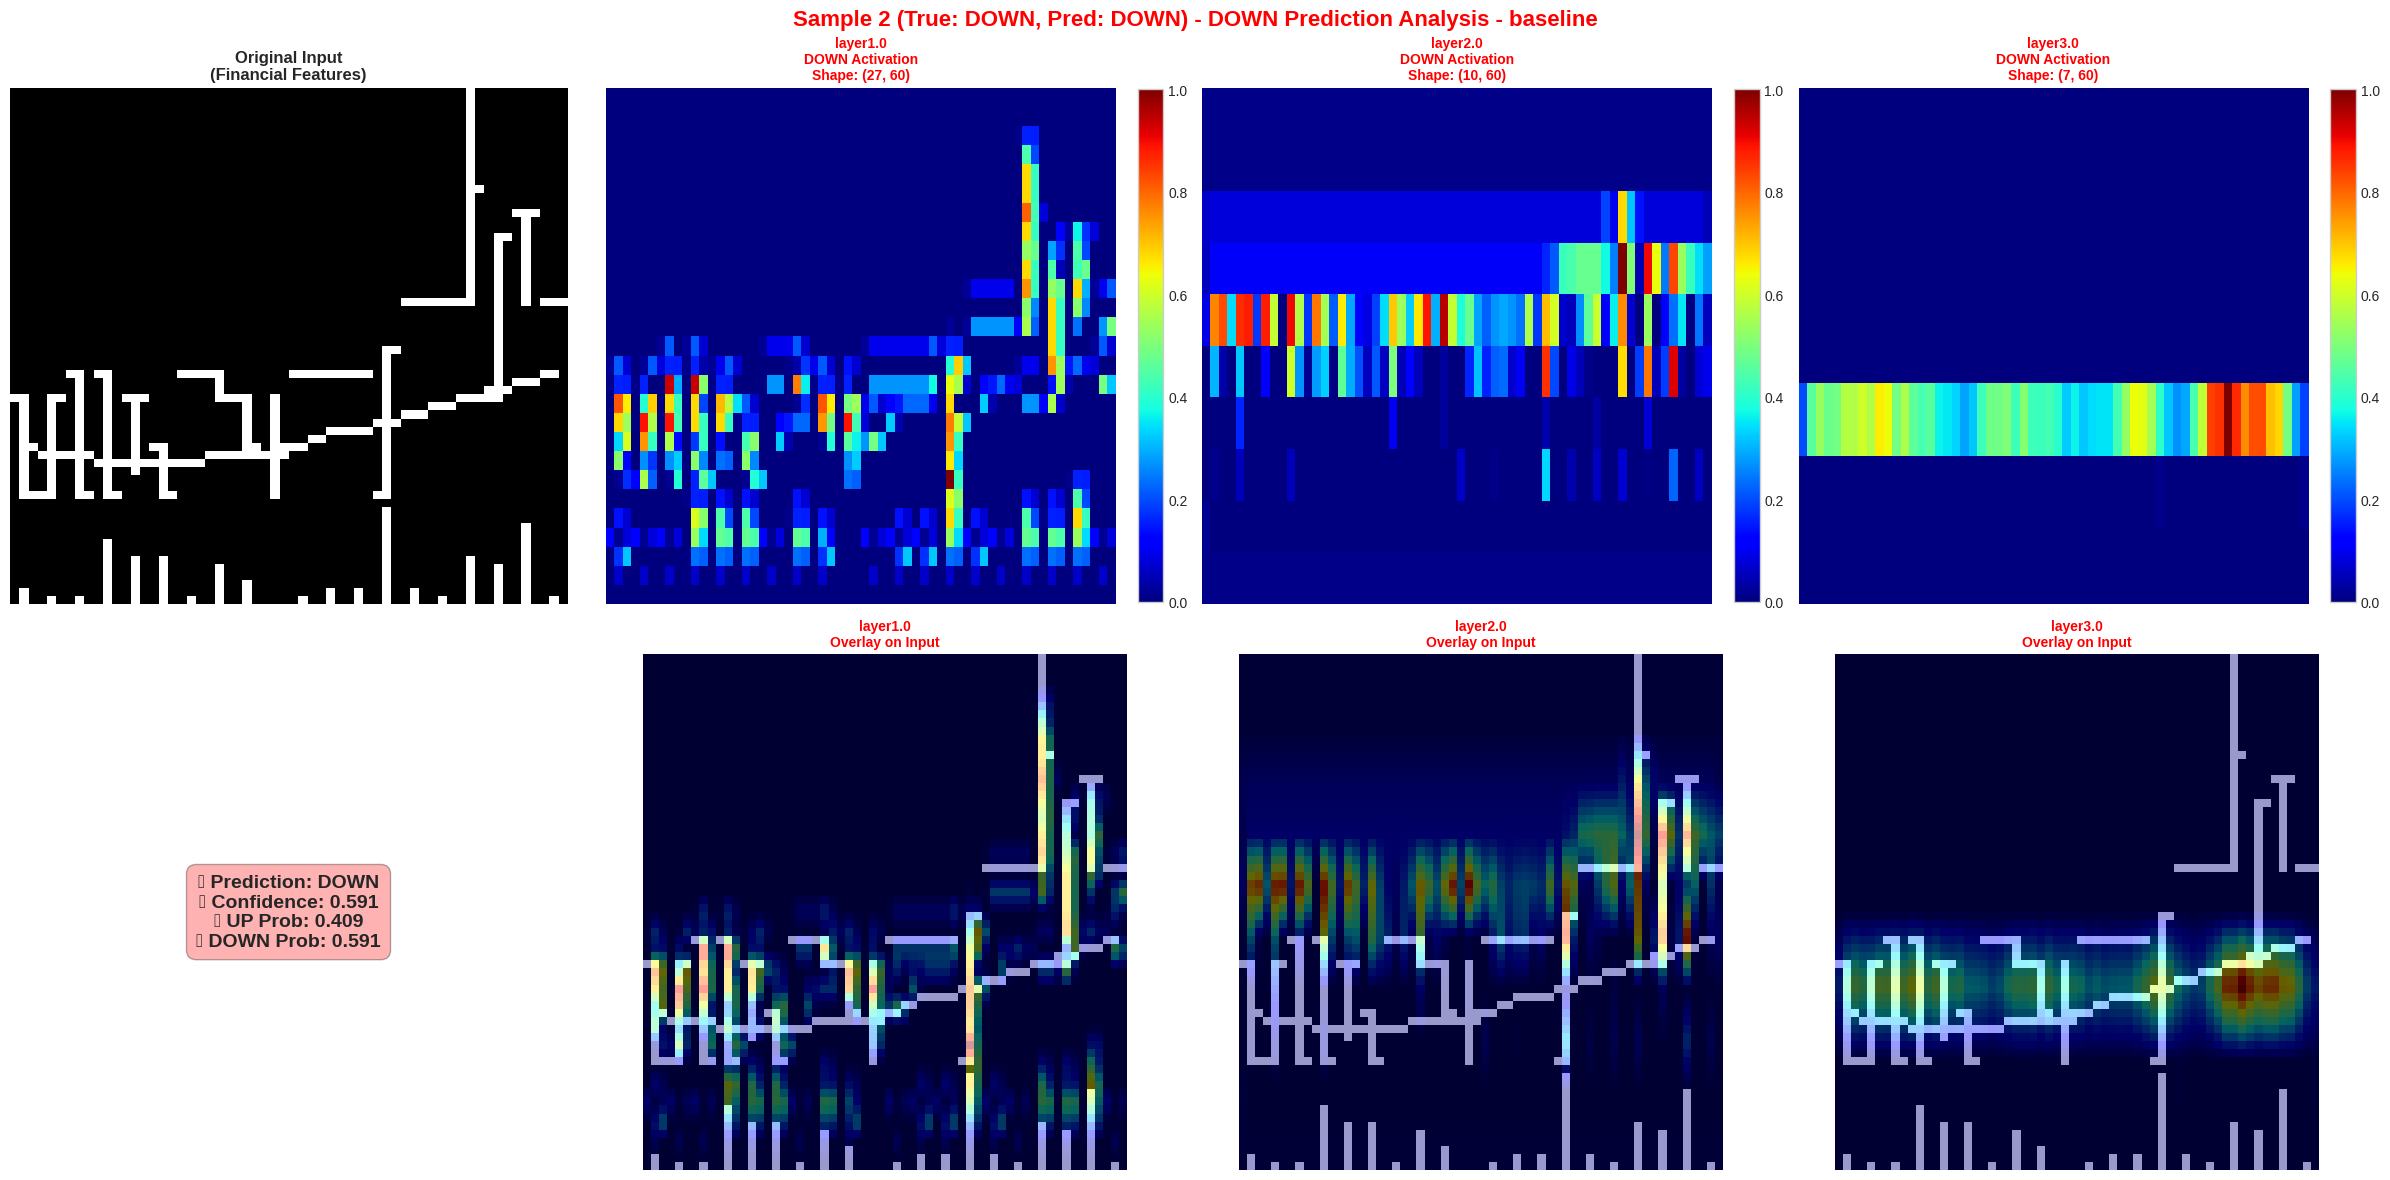

✅ Successfully analyzed DOWN prediction for sample 2

🎨 Starting multi-layer visualization for input shape: torch.Size([1, 64, 60])
🎯 Predicted class: DOWN (confidence: 0.538)

📏 Input tensor shape: torch.Size([1, 64, 60])
🔍 Forward hook [layer1.0] - Shape: torch.Size([1, 64, 27, 60])
🔍 Forward hook [layer2.0] - Shape: torch.Size([1, 128, 10, 60])
🔍 Forward hook [layer3.0] - Shape: torch.Size([1, 256, 7, 60])
📏 Model output shape: torch.Size([1, 2])
🔍 Backward hook [layer3.0] - Shape: torch.Size([1, 256, 7, 60])
🔍 Backward hook [layer2.0] - Shape: torch.Size([1, 128, 10, 60])
🔍 Backward hook [layer1.0] - Shape: torch.Size([1, 64, 27, 60])

🔧 Processing layer: layer1.0
📏 Activations shape: torch.Size([1, 64, 27, 60])
📏 Gradients shape: torch.Size([1, 64, 27, 60])
📏 CAM shape for layer1.0: (27, 60)

🔧 Processing layer: layer2.0
📏 Activations shape: torch.Size([1, 128, 10, 60])
📏 Gradients shape: torch.Size([1, 128, 10, 60])
📏 CAM shape for layer2.0: (10, 60)

🔧 Processing layer: layer3.0

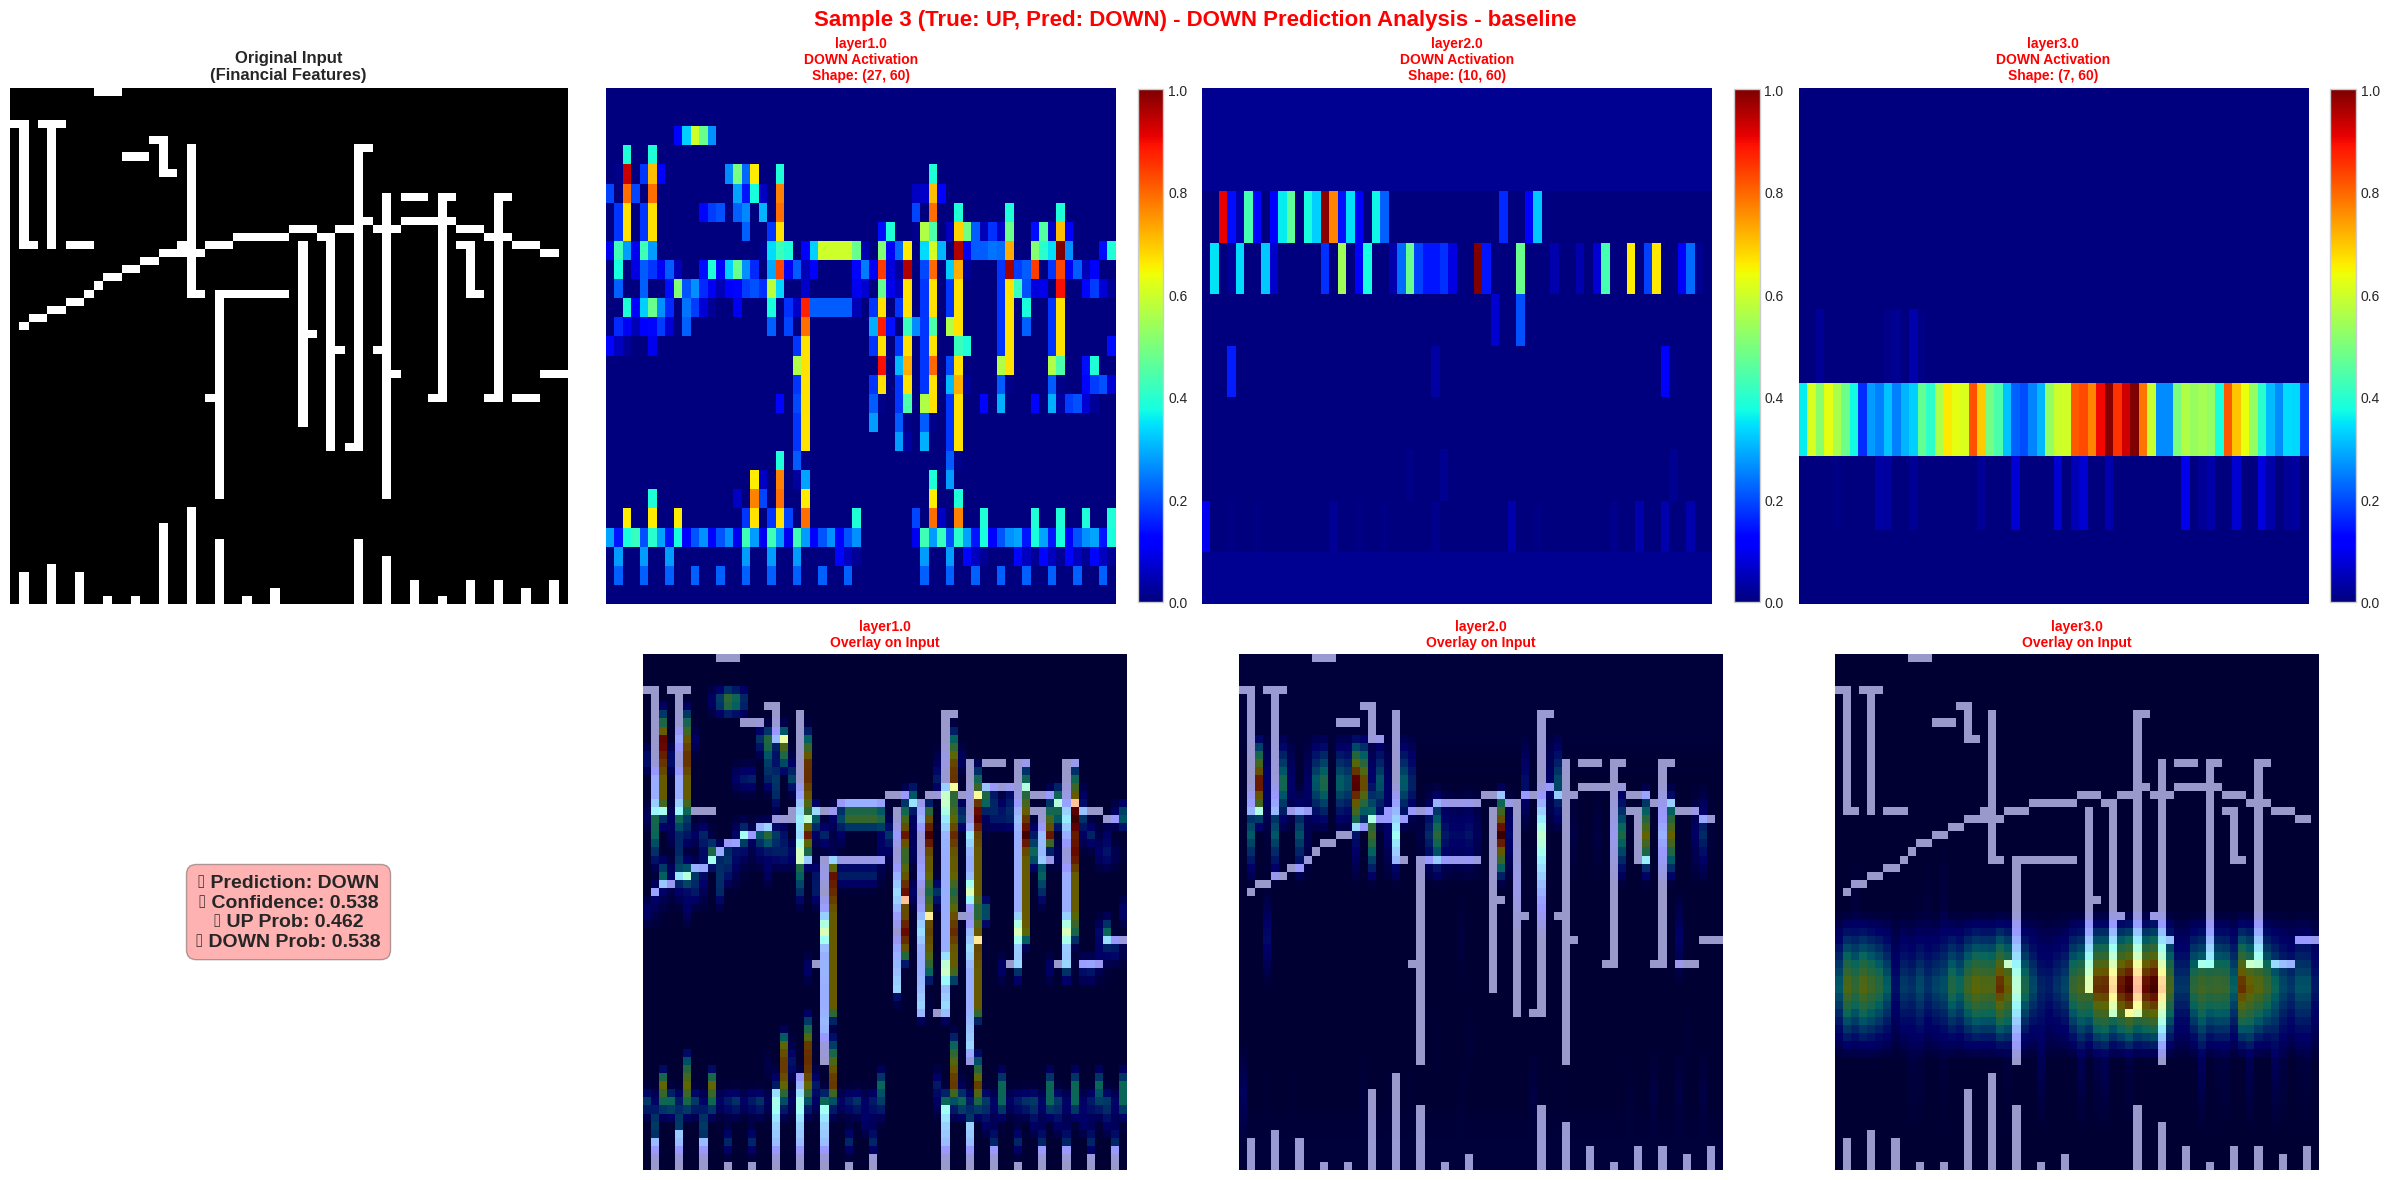

✅ Successfully analyzed DOWN prediction for sample 3

🎨 Starting multi-layer visualization for input shape: torch.Size([1, 64, 60])
🎯 Predicted class: DOWN (confidence: 0.553)

📏 Input tensor shape: torch.Size([1, 64, 60])
🔍 Forward hook [layer1.0] - Shape: torch.Size([1, 64, 27, 60])
🔍 Forward hook [layer2.0] - Shape: torch.Size([1, 128, 10, 60])
🔍 Forward hook [layer3.0] - Shape: torch.Size([1, 256, 7, 60])
📏 Model output shape: torch.Size([1, 2])
🔍 Backward hook [layer3.0] - Shape: torch.Size([1, 256, 7, 60])
🔍 Backward hook [layer2.0] - Shape: torch.Size([1, 128, 10, 60])
🔍 Backward hook [layer1.0] - Shape: torch.Size([1, 64, 27, 60])

🔧 Processing layer: layer1.0
📏 Activations shape: torch.Size([1, 64, 27, 60])
📏 Gradients shape: torch.Size([1, 64, 27, 60])
📏 CAM shape for layer1.0: (27, 60)

🔧 Processing layer: layer2.0
📏 Activations shape: torch.Size([1, 128, 10, 60])
📏 Gradients shape: torch.Size([1, 128, 10, 60])
📏 CAM shape for layer2.0: (10, 60)

🔧 Processing layer: layer3.0

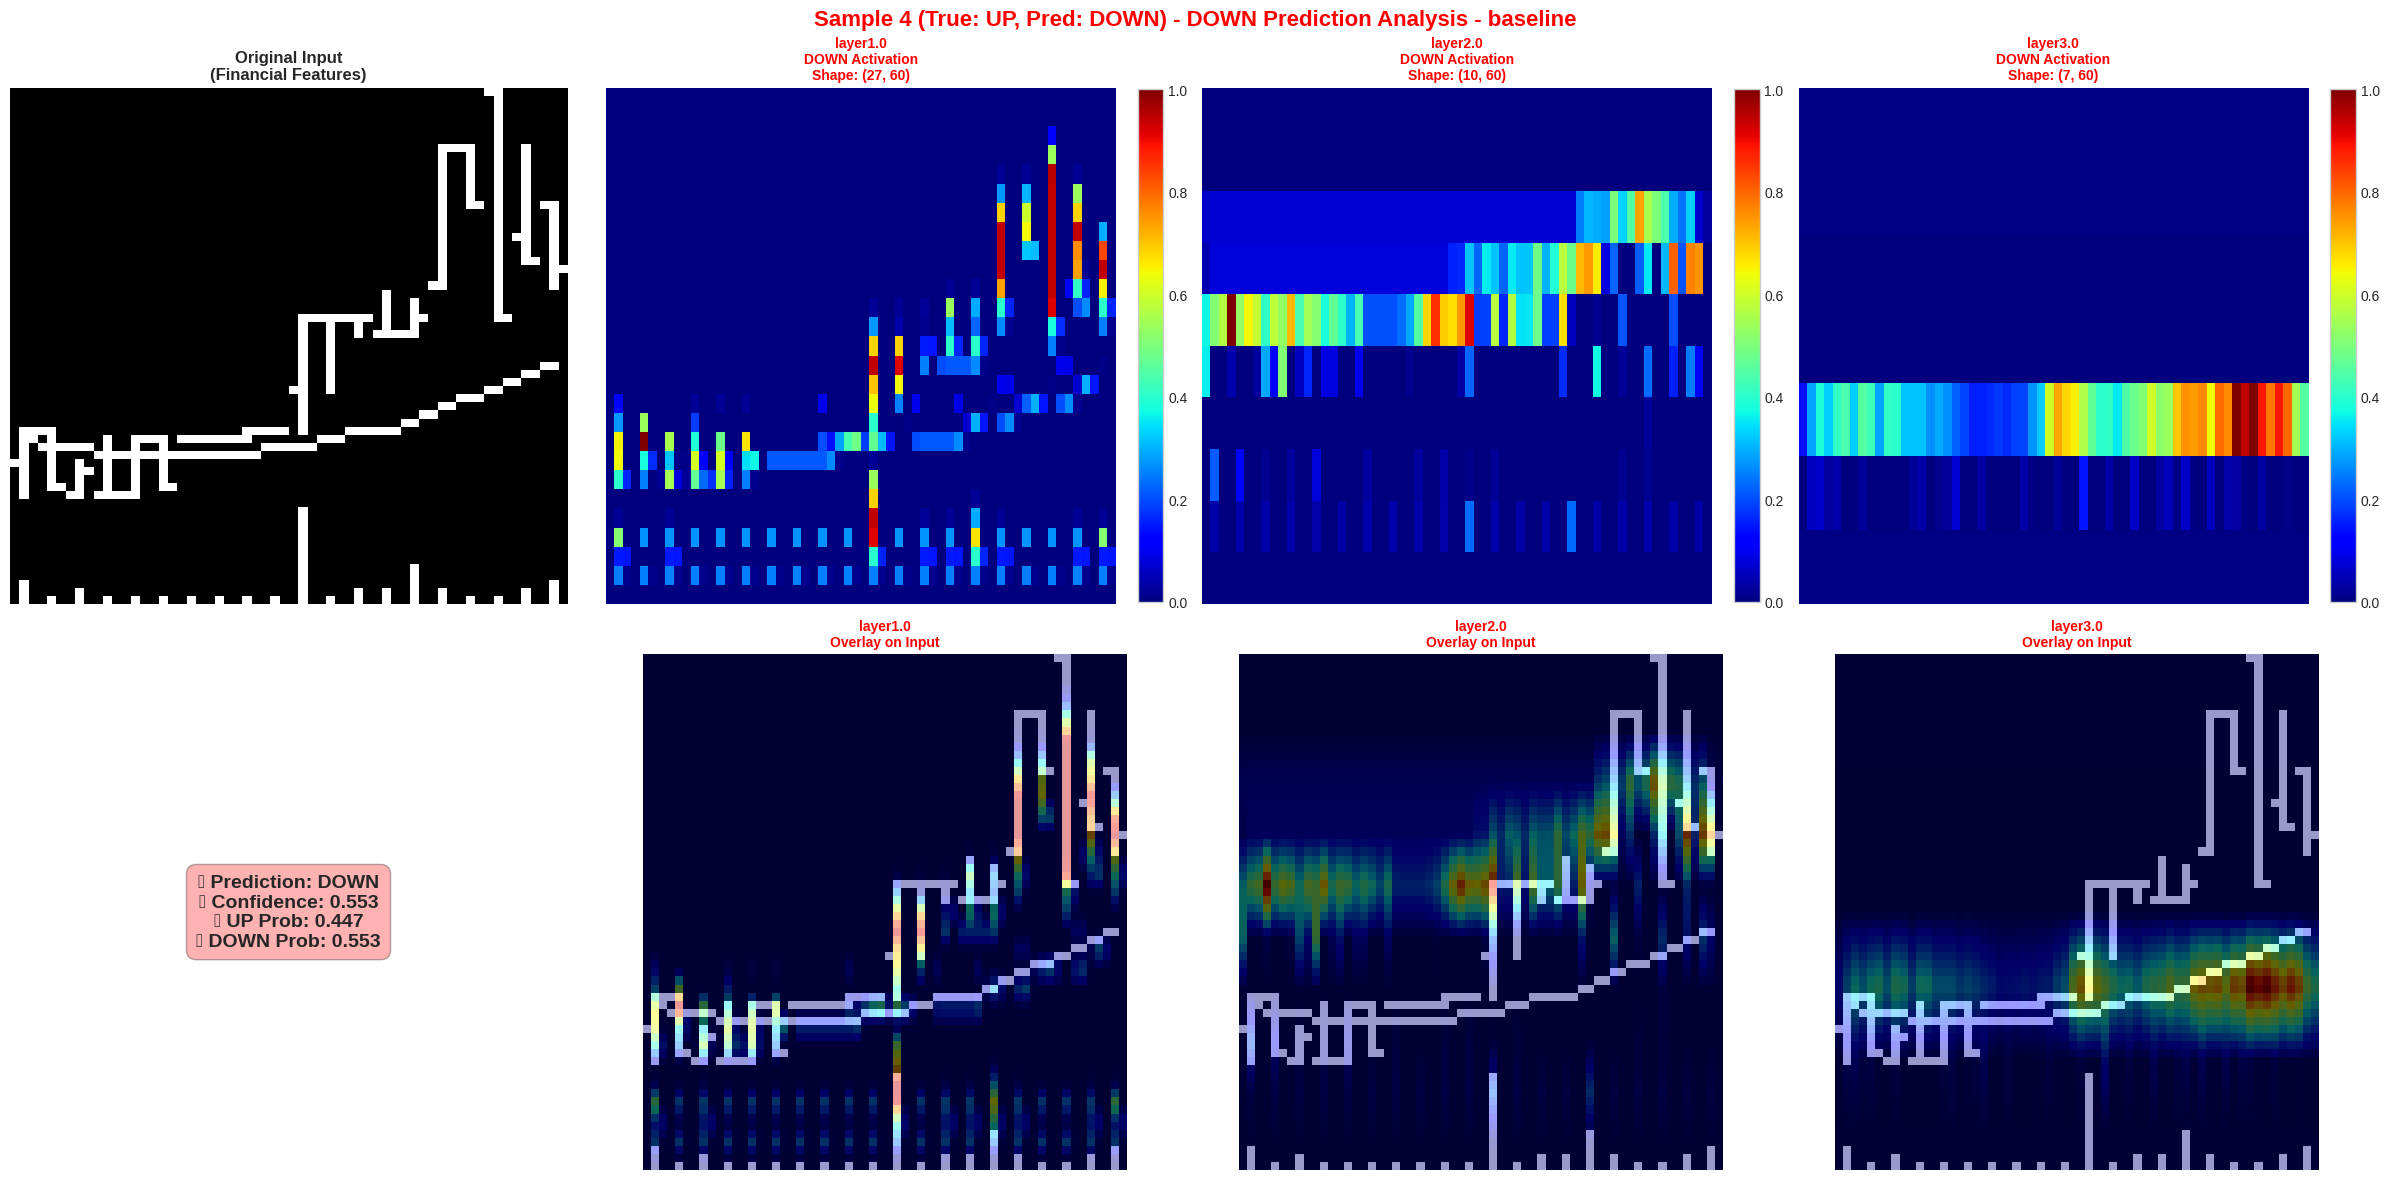

✅ Successfully analyzed DOWN prediction for sample 4

🎨 Starting multi-layer visualization for input shape: torch.Size([1, 64, 60])
🎯 Predicted class: DOWN (confidence: 0.608)

📏 Input tensor shape: torch.Size([1, 64, 60])
🔍 Forward hook [layer1.0] - Shape: torch.Size([1, 64, 27, 60])
🔍 Forward hook [layer2.0] - Shape: torch.Size([1, 128, 10, 60])
🔍 Forward hook [layer3.0] - Shape: torch.Size([1, 256, 7, 60])
📏 Model output shape: torch.Size([1, 2])
🔍 Backward hook [layer3.0] - Shape: torch.Size([1, 256, 7, 60])
🔍 Backward hook [layer2.0] - Shape: torch.Size([1, 128, 10, 60])
🔍 Backward hook [layer1.0] - Shape: torch.Size([1, 64, 27, 60])

🔧 Processing layer: layer1.0
📏 Activations shape: torch.Size([1, 64, 27, 60])
📏 Gradients shape: torch.Size([1, 64, 27, 60])
📏 CAM shape for layer1.0: (27, 60)

🔧 Processing layer: layer2.0
📏 Activations shape: torch.Size([1, 128, 10, 60])
📏 Gradients shape: torch.Size([1, 128, 10, 60])
📏 CAM shape for layer2.0: (10, 60)

🔧 Processing layer: layer3.0

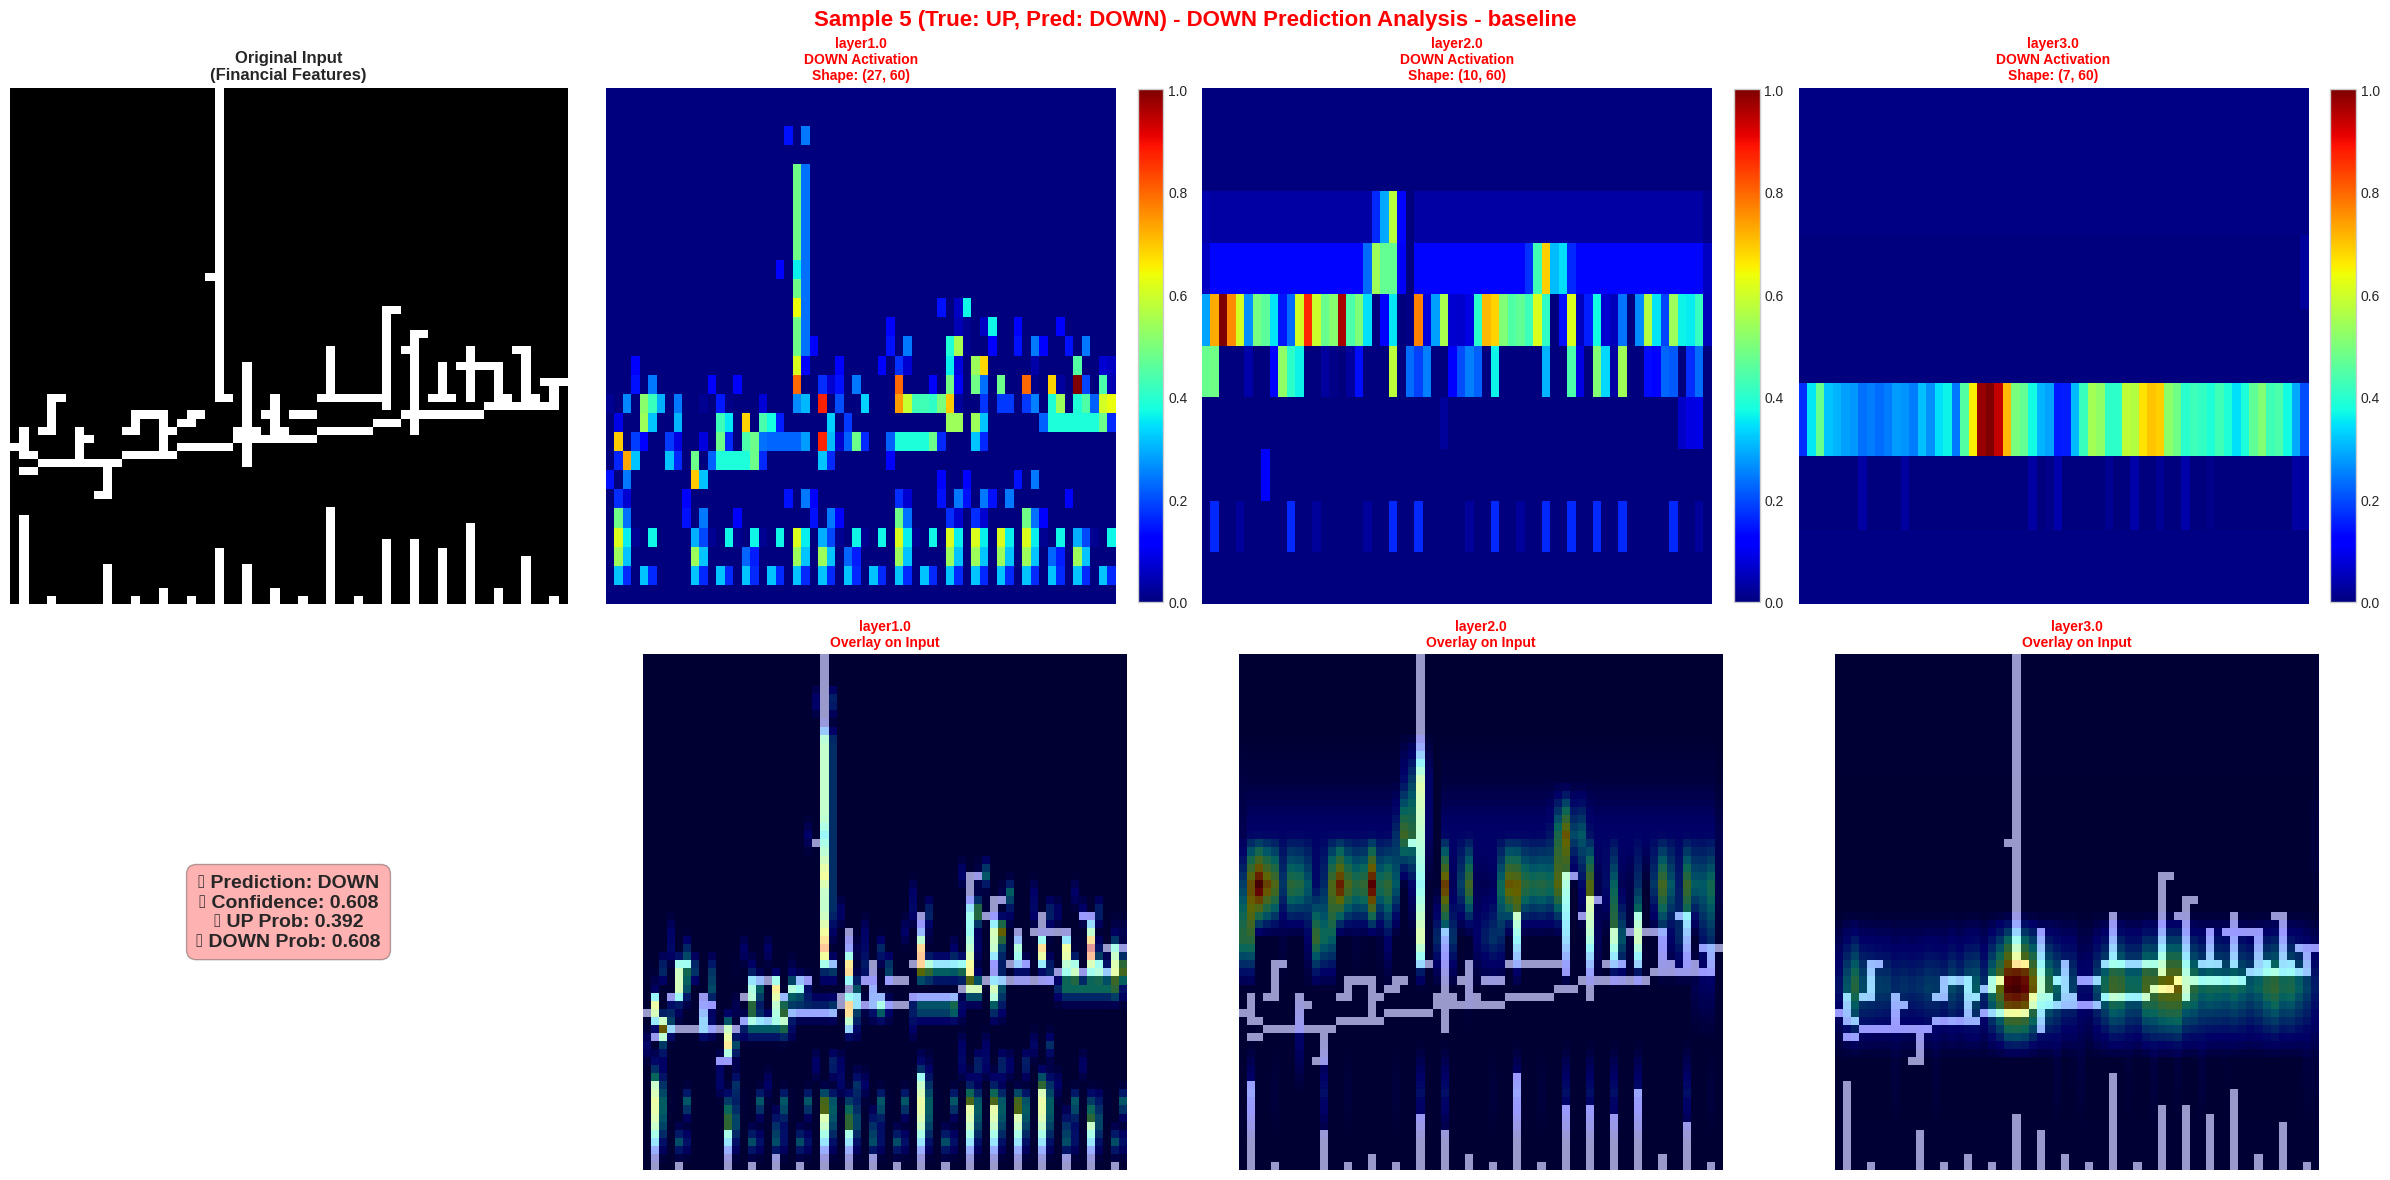

✅ Successfully analyzed DOWN prediction for sample 5

🎨 Starting multi-layer visualization for input shape: torch.Size([1, 64, 60])
🎯 Predicted class: DOWN (confidence: 0.544)

📏 Input tensor shape: torch.Size([1, 64, 60])
🔍 Forward hook [layer1.0] - Shape: torch.Size([1, 64, 27, 60])
🔍 Forward hook [layer2.0] - Shape: torch.Size([1, 128, 10, 60])
🔍 Forward hook [layer3.0] - Shape: torch.Size([1, 256, 7, 60])
📏 Model output shape: torch.Size([1, 2])
🔍 Backward hook [layer3.0] - Shape: torch.Size([1, 256, 7, 60])
🔍 Backward hook [layer2.0] - Shape: torch.Size([1, 128, 10, 60])
🔍 Backward hook [layer1.0] - Shape: torch.Size([1, 64, 27, 60])

🔧 Processing layer: layer1.0
📏 Activations shape: torch.Size([1, 64, 27, 60])
📏 Gradients shape: torch.Size([1, 64, 27, 60])
📏 CAM shape for layer1.0: (27, 60)

🔧 Processing layer: layer2.0
📏 Activations shape: torch.Size([1, 128, 10, 60])
📏 Gradients shape: torch.Size([1, 128, 10, 60])
📏 CAM shape for layer2.0: (10, 60)

🔧 Processing layer: layer3.0

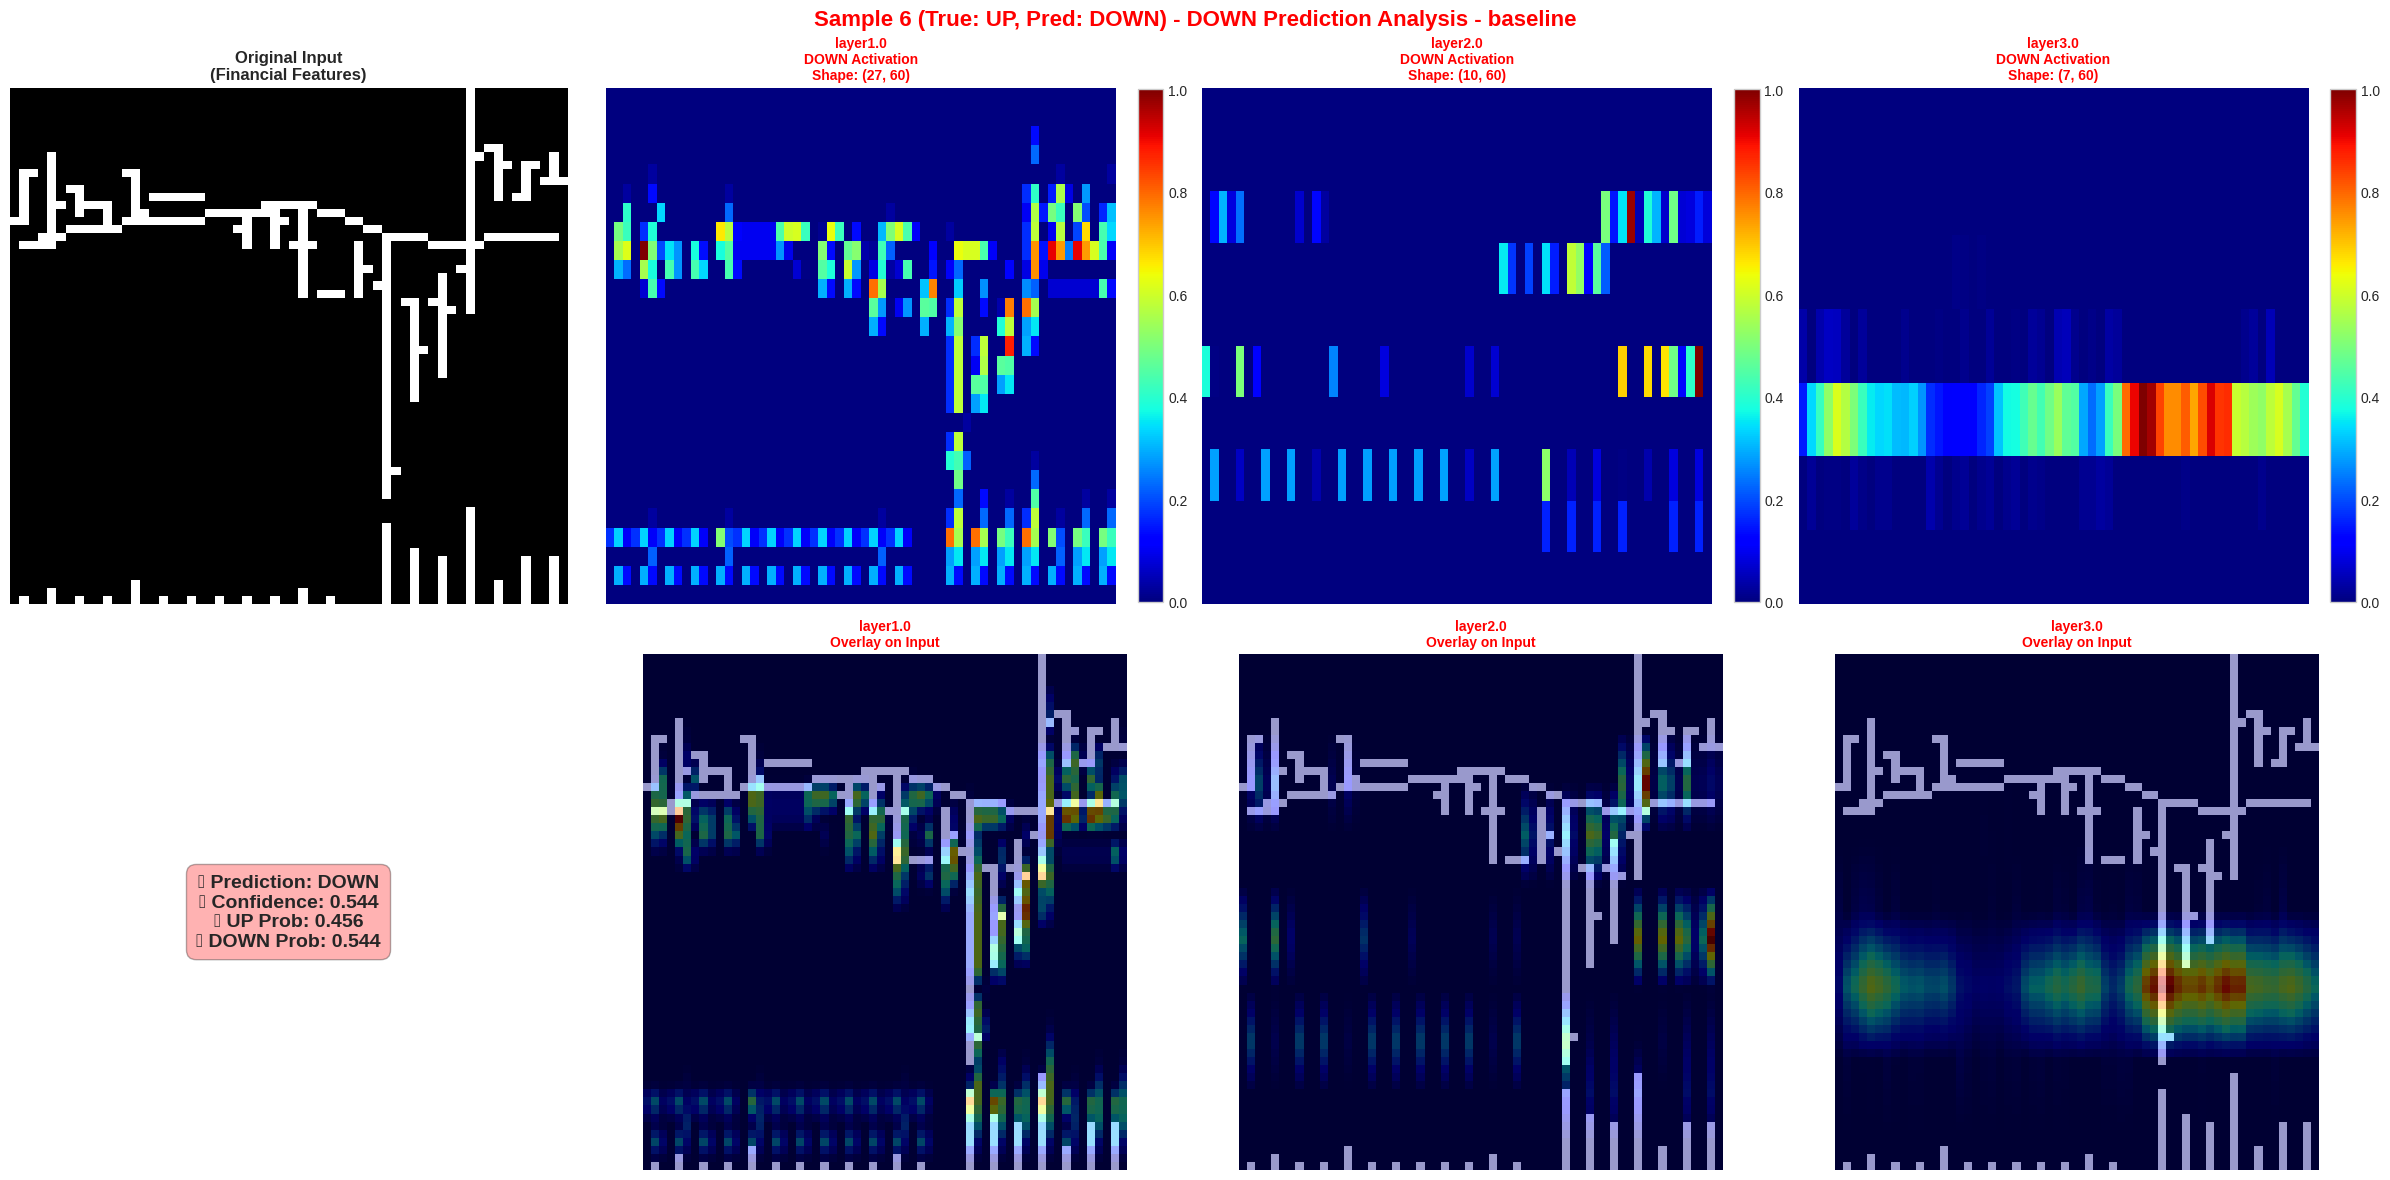

✅ Successfully analyzed DOWN prediction for sample 6

🎨 Starting multi-layer visualization for input shape: torch.Size([1, 64, 60])
🎯 Predicted class: DOWN (confidence: 0.541)

📏 Input tensor shape: torch.Size([1, 64, 60])
🔍 Forward hook [layer1.0] - Shape: torch.Size([1, 64, 27, 60])
🔍 Forward hook [layer2.0] - Shape: torch.Size([1, 128, 10, 60])
🔍 Forward hook [layer3.0] - Shape: torch.Size([1, 256, 7, 60])
📏 Model output shape: torch.Size([1, 2])
🔍 Backward hook [layer3.0] - Shape: torch.Size([1, 256, 7, 60])
🔍 Backward hook [layer2.0] - Shape: torch.Size([1, 128, 10, 60])
🔍 Backward hook [layer1.0] - Shape: torch.Size([1, 64, 27, 60])

🔧 Processing layer: layer1.0
📏 Activations shape: torch.Size([1, 64, 27, 60])
📏 Gradients shape: torch.Size([1, 64, 27, 60])
📏 CAM shape for layer1.0: (27, 60)

🔧 Processing layer: layer2.0
📏 Activations shape: torch.Size([1, 128, 10, 60])
📏 Gradients shape: torch.Size([1, 128, 10, 60])
📏 CAM shape for layer2.0: (10, 60)

🔧 Processing layer: layer3.0

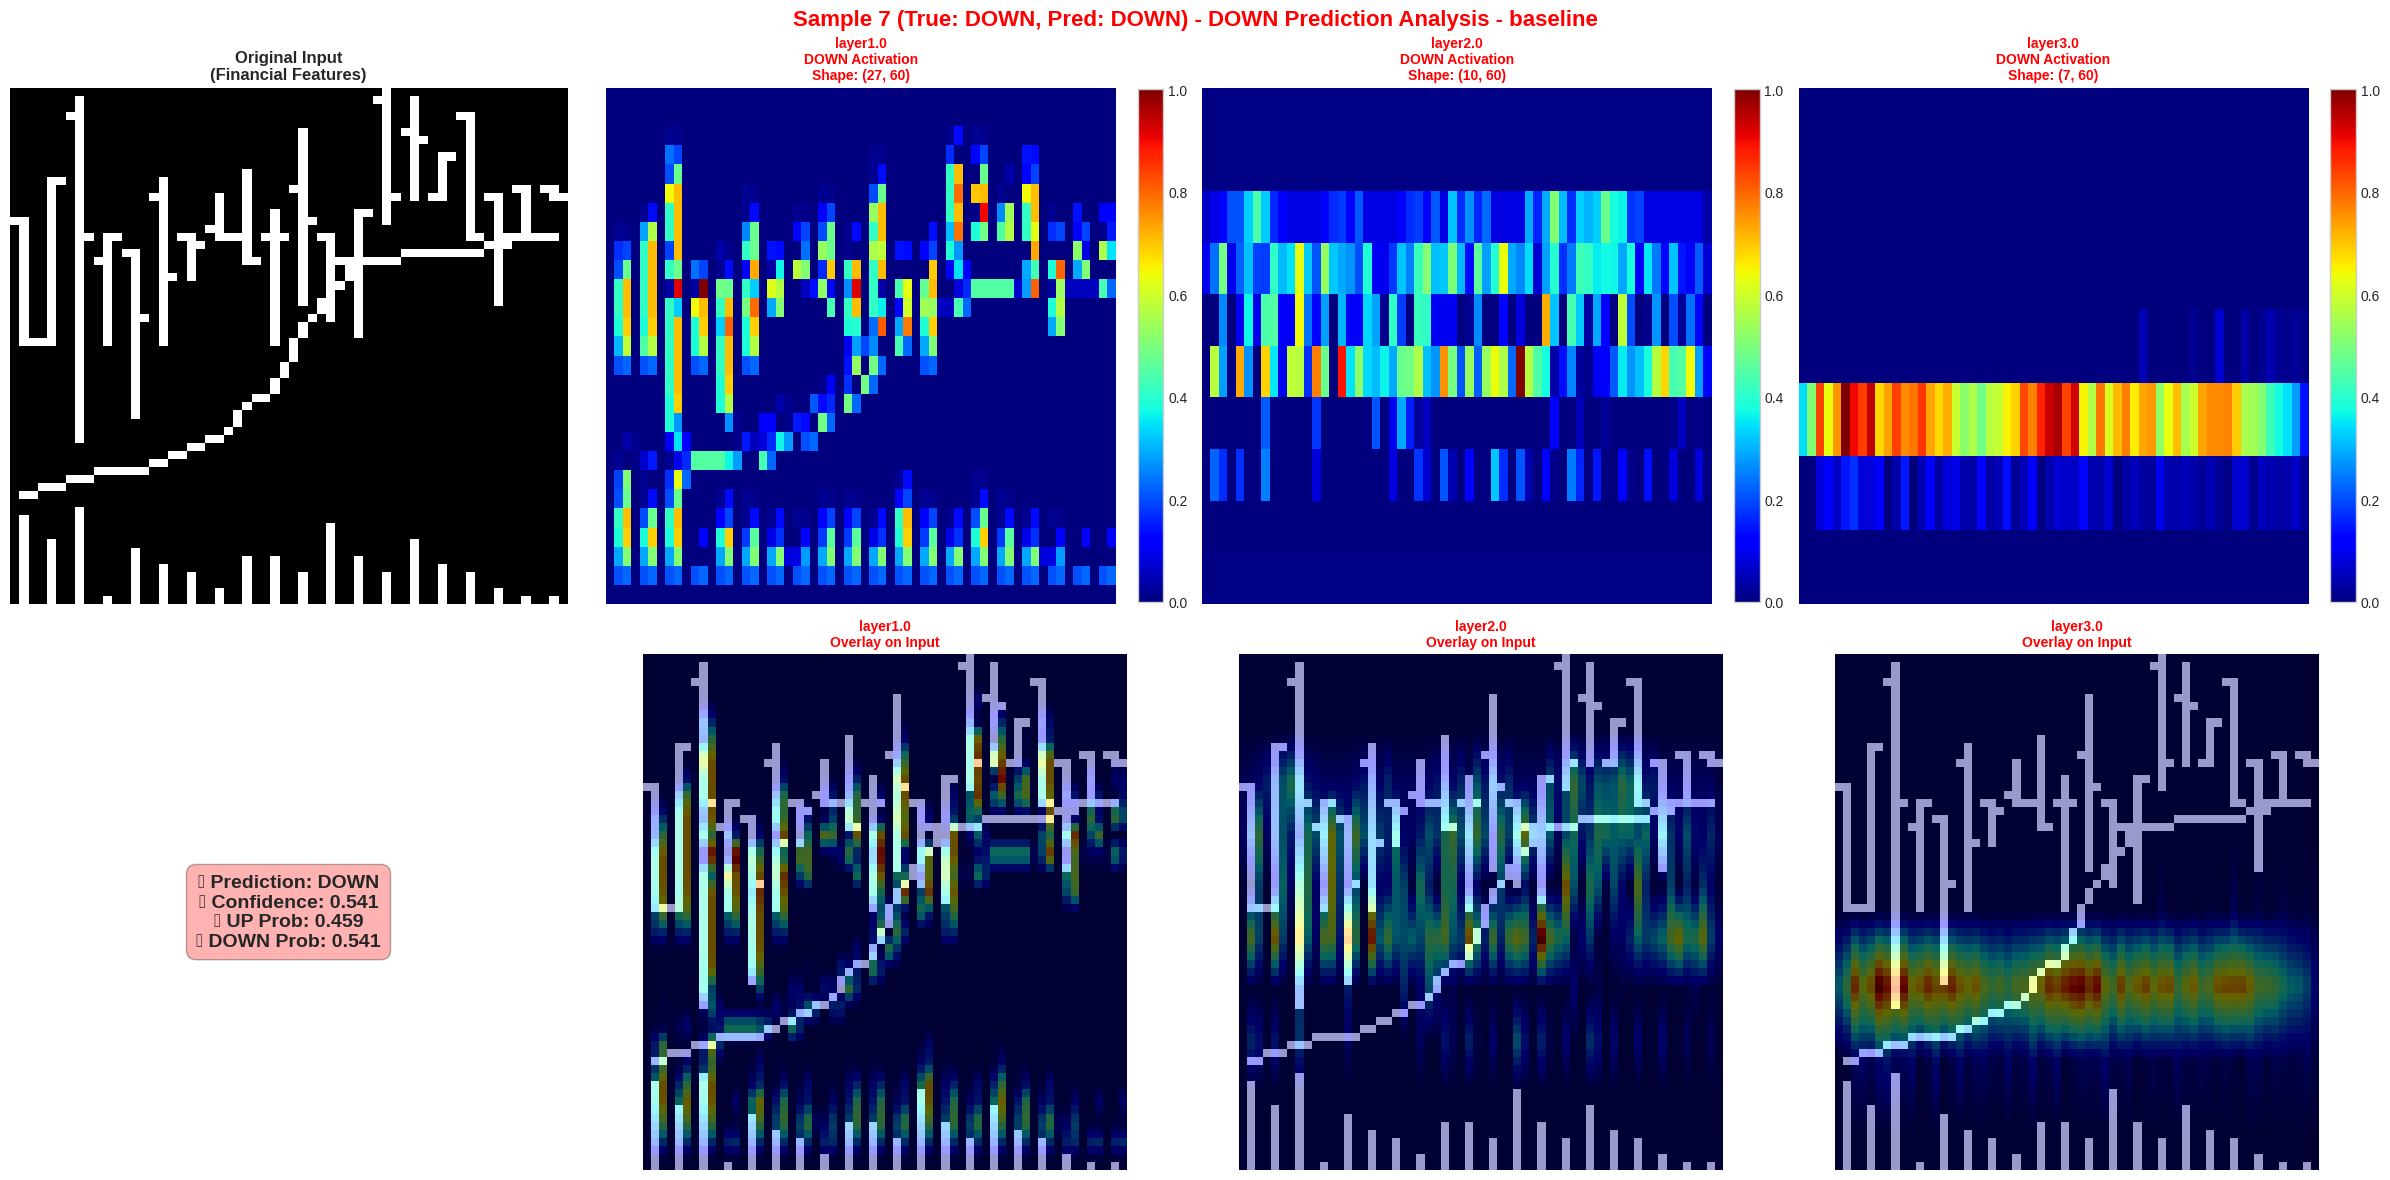

✅ Successfully analyzed DOWN prediction for sample 7

🎨 Starting multi-layer visualization for input shape: torch.Size([1, 64, 60])
🎯 Predicted class: DOWN (confidence: 0.530)

📏 Input tensor shape: torch.Size([1, 64, 60])
🔍 Forward hook [layer1.0] - Shape: torch.Size([1, 64, 27, 60])
🔍 Forward hook [layer2.0] - Shape: torch.Size([1, 128, 10, 60])
🔍 Forward hook [layer3.0] - Shape: torch.Size([1, 256, 7, 60])
📏 Model output shape: torch.Size([1, 2])
🔍 Backward hook [layer3.0] - Shape: torch.Size([1, 256, 7, 60])
🔍 Backward hook [layer2.0] - Shape: torch.Size([1, 128, 10, 60])
🔍 Backward hook [layer1.0] - Shape: torch.Size([1, 64, 27, 60])

🔧 Processing layer: layer1.0
📏 Activations shape: torch.Size([1, 64, 27, 60])
📏 Gradients shape: torch.Size([1, 64, 27, 60])
📏 CAM shape for layer1.0: (27, 60)

🔧 Processing layer: layer2.0
📏 Activations shape: torch.Size([1, 128, 10, 60])
📏 Gradients shape: torch.Size([1, 128, 10, 60])
📏 CAM shape for layer2.0: (10, 60)

🔧 Processing layer: layer3.0

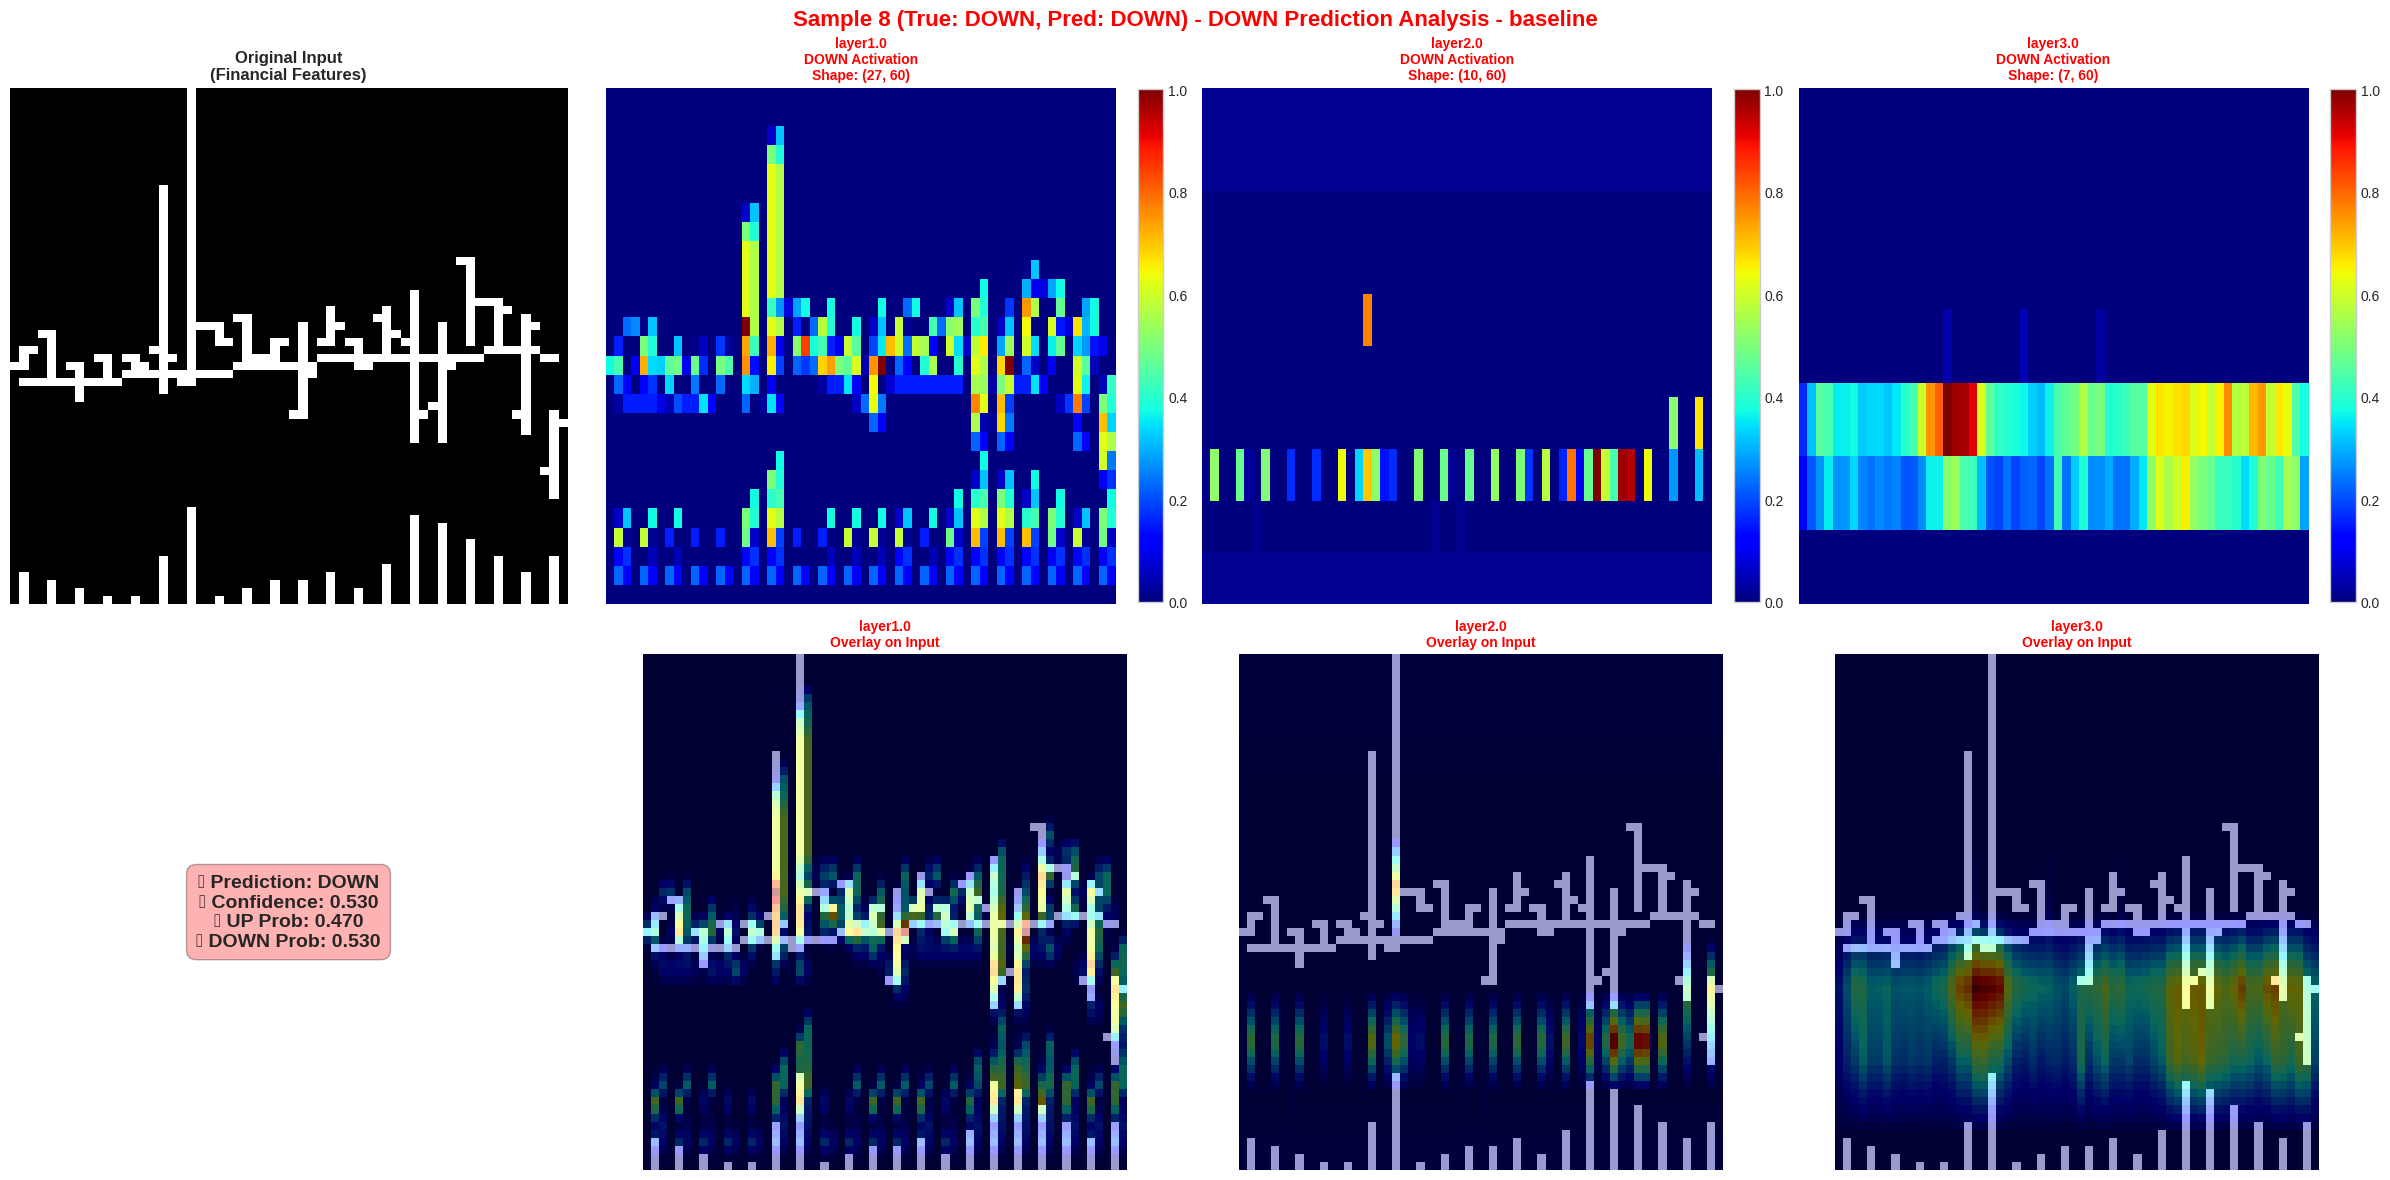

✅ Successfully analyzed DOWN prediction for sample 8

🎨 Starting multi-layer visualization for input shape: torch.Size([1, 64, 60])
🎯 Predicted class: UP (confidence: 0.536)

📏 Input tensor shape: torch.Size([1, 64, 60])
🔍 Forward hook [layer1.0] - Shape: torch.Size([1, 64, 27, 60])
🔍 Forward hook [layer2.0] - Shape: torch.Size([1, 128, 10, 60])
🔍 Forward hook [layer3.0] - Shape: torch.Size([1, 256, 7, 60])
📏 Model output shape: torch.Size([1, 2])
🔍 Backward hook [layer3.0] - Shape: torch.Size([1, 256, 7, 60])
🔍 Backward hook [layer2.0] - Shape: torch.Size([1, 128, 10, 60])
🔍 Backward hook [layer1.0] - Shape: torch.Size([1, 64, 27, 60])

🔧 Processing layer: layer1.0
📏 Activations shape: torch.Size([1, 64, 27, 60])
📏 Gradients shape: torch.Size([1, 64, 27, 60])
📏 CAM shape for layer1.0: (27, 60)

🔧 Processing layer: layer2.0
📏 Activations shape: torch.Size([1, 128, 10, 60])
📏 Gradients shape: torch.Size([1, 128, 10, 60])
📏 CAM shape for layer2.0: (10, 60)

🔧 Processing layer: layer3.0
📏

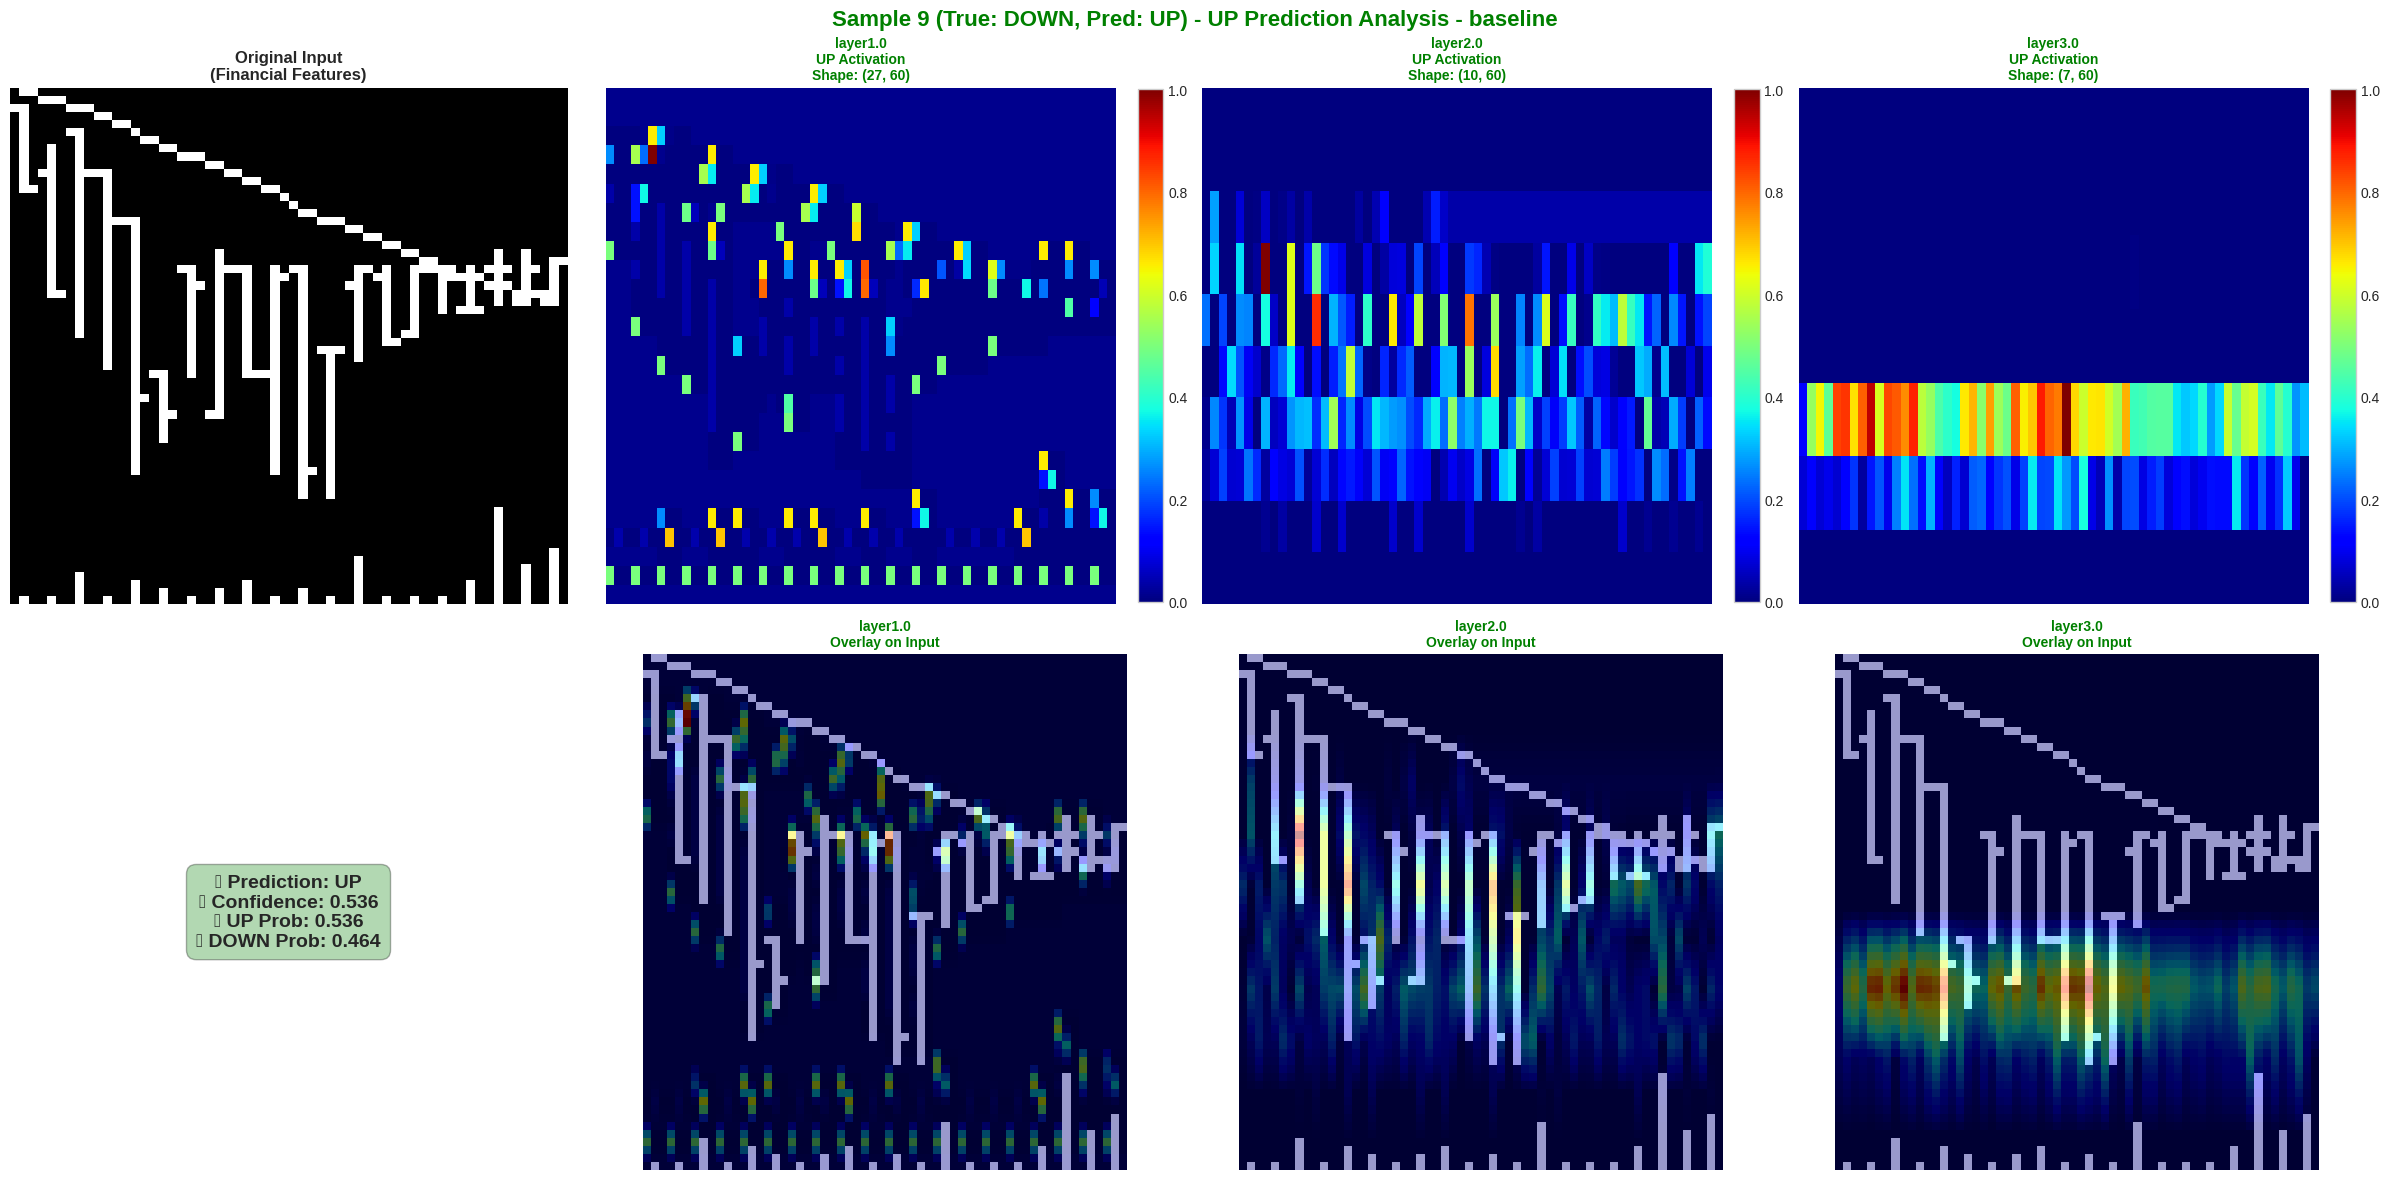

✅ Successfully analyzed UP prediction for sample 9
✅ Custom Grad-CAM analysis completed. Results saved to: gradcam_analysis_baseline

📊 Results Summary:
  Test Loss: 0.694193
  Accuracy: 0.5158
  Selected Stocks: 25,922 (1.85%)
  Cumulative Return (Baseline): 3.1792
  Cumulative Return (Strategy): 19.8617
  Excess Return: 16.6825

Testing Model with Custom Grad-CAM Analysis: baseline_large
Model Path: ../pt/baseline_large/best.pt
Model Parameters: 10,233,602 (10.23M)


[baseline_large] Eval: 100%|██████████| 686/686 [00:29<00:00, 23.08it/s, loss=0.6926]



🔍 Performing Custom Grad-CAM Analysis...

🔍 Finding all convolution layers...
🔍 Found convolution layer: layer1.0 - Conv2d
    Conv2d: 1→96, kernel=(5, 3), stride=(3, 1)
🔍 Found convolution layer: layer2.0 - Conv2d
    Conv2d: 96→192, kernel=(5, 3), stride=(3, 1)
🔍 Found convolution layer: layer3.0 - Conv2d
    Conv2d: 192→384, kernel=(5, 3), stride=(3, 1)
✅ Found 3 convolution layers
Collected 10 samples

🎨 Starting multi-layer visualization for input shape: torch.Size([1, 64, 60])
🎯 Predicted class: DOWN (confidence: 0.566)

📏 Input tensor shape: torch.Size([1, 64, 60])
🔍 Forward hook [layer1.0] - Shape: torch.Size([1, 96, 27, 60])
🔍 Forward hook [layer2.0] - Shape: torch.Size([1, 192, 10, 60])
🔍 Forward hook [layer3.0] - Shape: torch.Size([1, 384, 7, 60])
📏 Model output shape: torch.Size([1, 2])
🔍 Backward hook [layer3.0] - Shape: torch.Size([1, 384, 7, 60])
🔍 Backward hook [layer2.0] - Shape: torch.Size([1, 192, 10, 60])
🔍 Backward hook [layer1.0] - Shape: torch.Size([1, 96, 27, 6

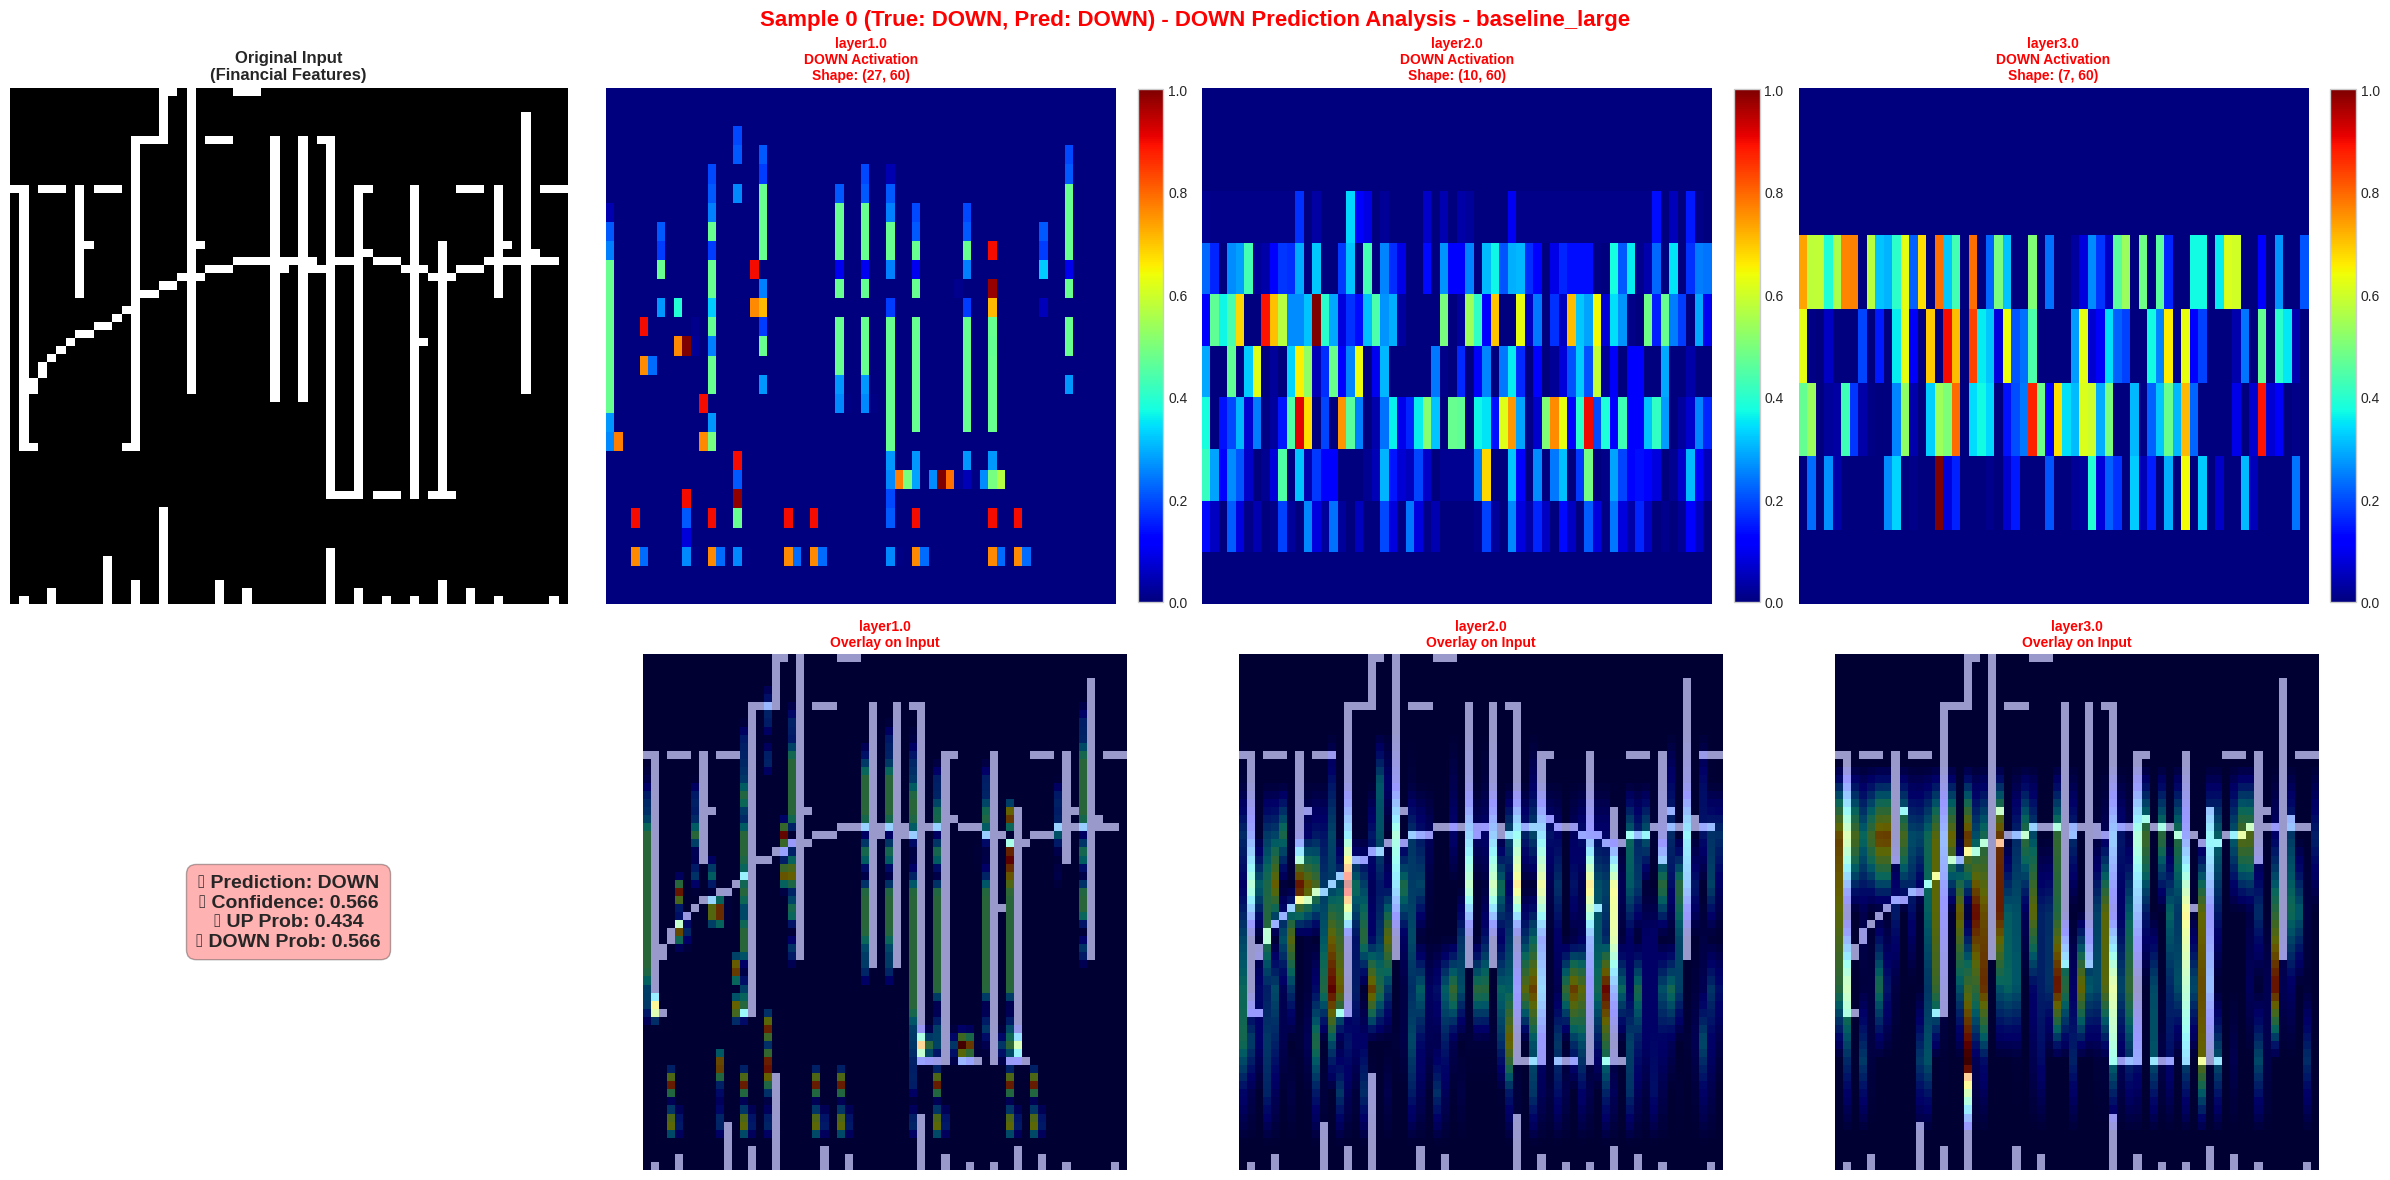

✅ Successfully analyzed DOWN prediction for sample 0

🎨 Starting multi-layer visualization for input shape: torch.Size([1, 64, 60])
🎯 Predicted class: DOWN (confidence: 0.592)

📏 Input tensor shape: torch.Size([1, 64, 60])
🔍 Forward hook [layer1.0] - Shape: torch.Size([1, 96, 27, 60])
🔍 Forward hook [layer2.0] - Shape: torch.Size([1, 192, 10, 60])
🔍 Forward hook [layer3.0] - Shape: torch.Size([1, 384, 7, 60])
📏 Model output shape: torch.Size([1, 2])
🔍 Backward hook [layer3.0] - Shape: torch.Size([1, 384, 7, 60])
🔍 Backward hook [layer2.0] - Shape: torch.Size([1, 192, 10, 60])
🔍 Backward hook [layer1.0] - Shape: torch.Size([1, 96, 27, 60])

🔧 Processing layer: layer1.0
📏 Activations shape: torch.Size([1, 96, 27, 60])
📏 Gradients shape: torch.Size([1, 96, 27, 60])
📏 CAM shape for layer1.0: (27, 60)

🔧 Processing layer: layer2.0
📏 Activations shape: torch.Size([1, 192, 10, 60])
📏 Gradients shape: torch.Size([1, 192, 10, 60])
📏 CAM shape for layer2.0: (10, 60)

🔧 Processing layer: layer3.0

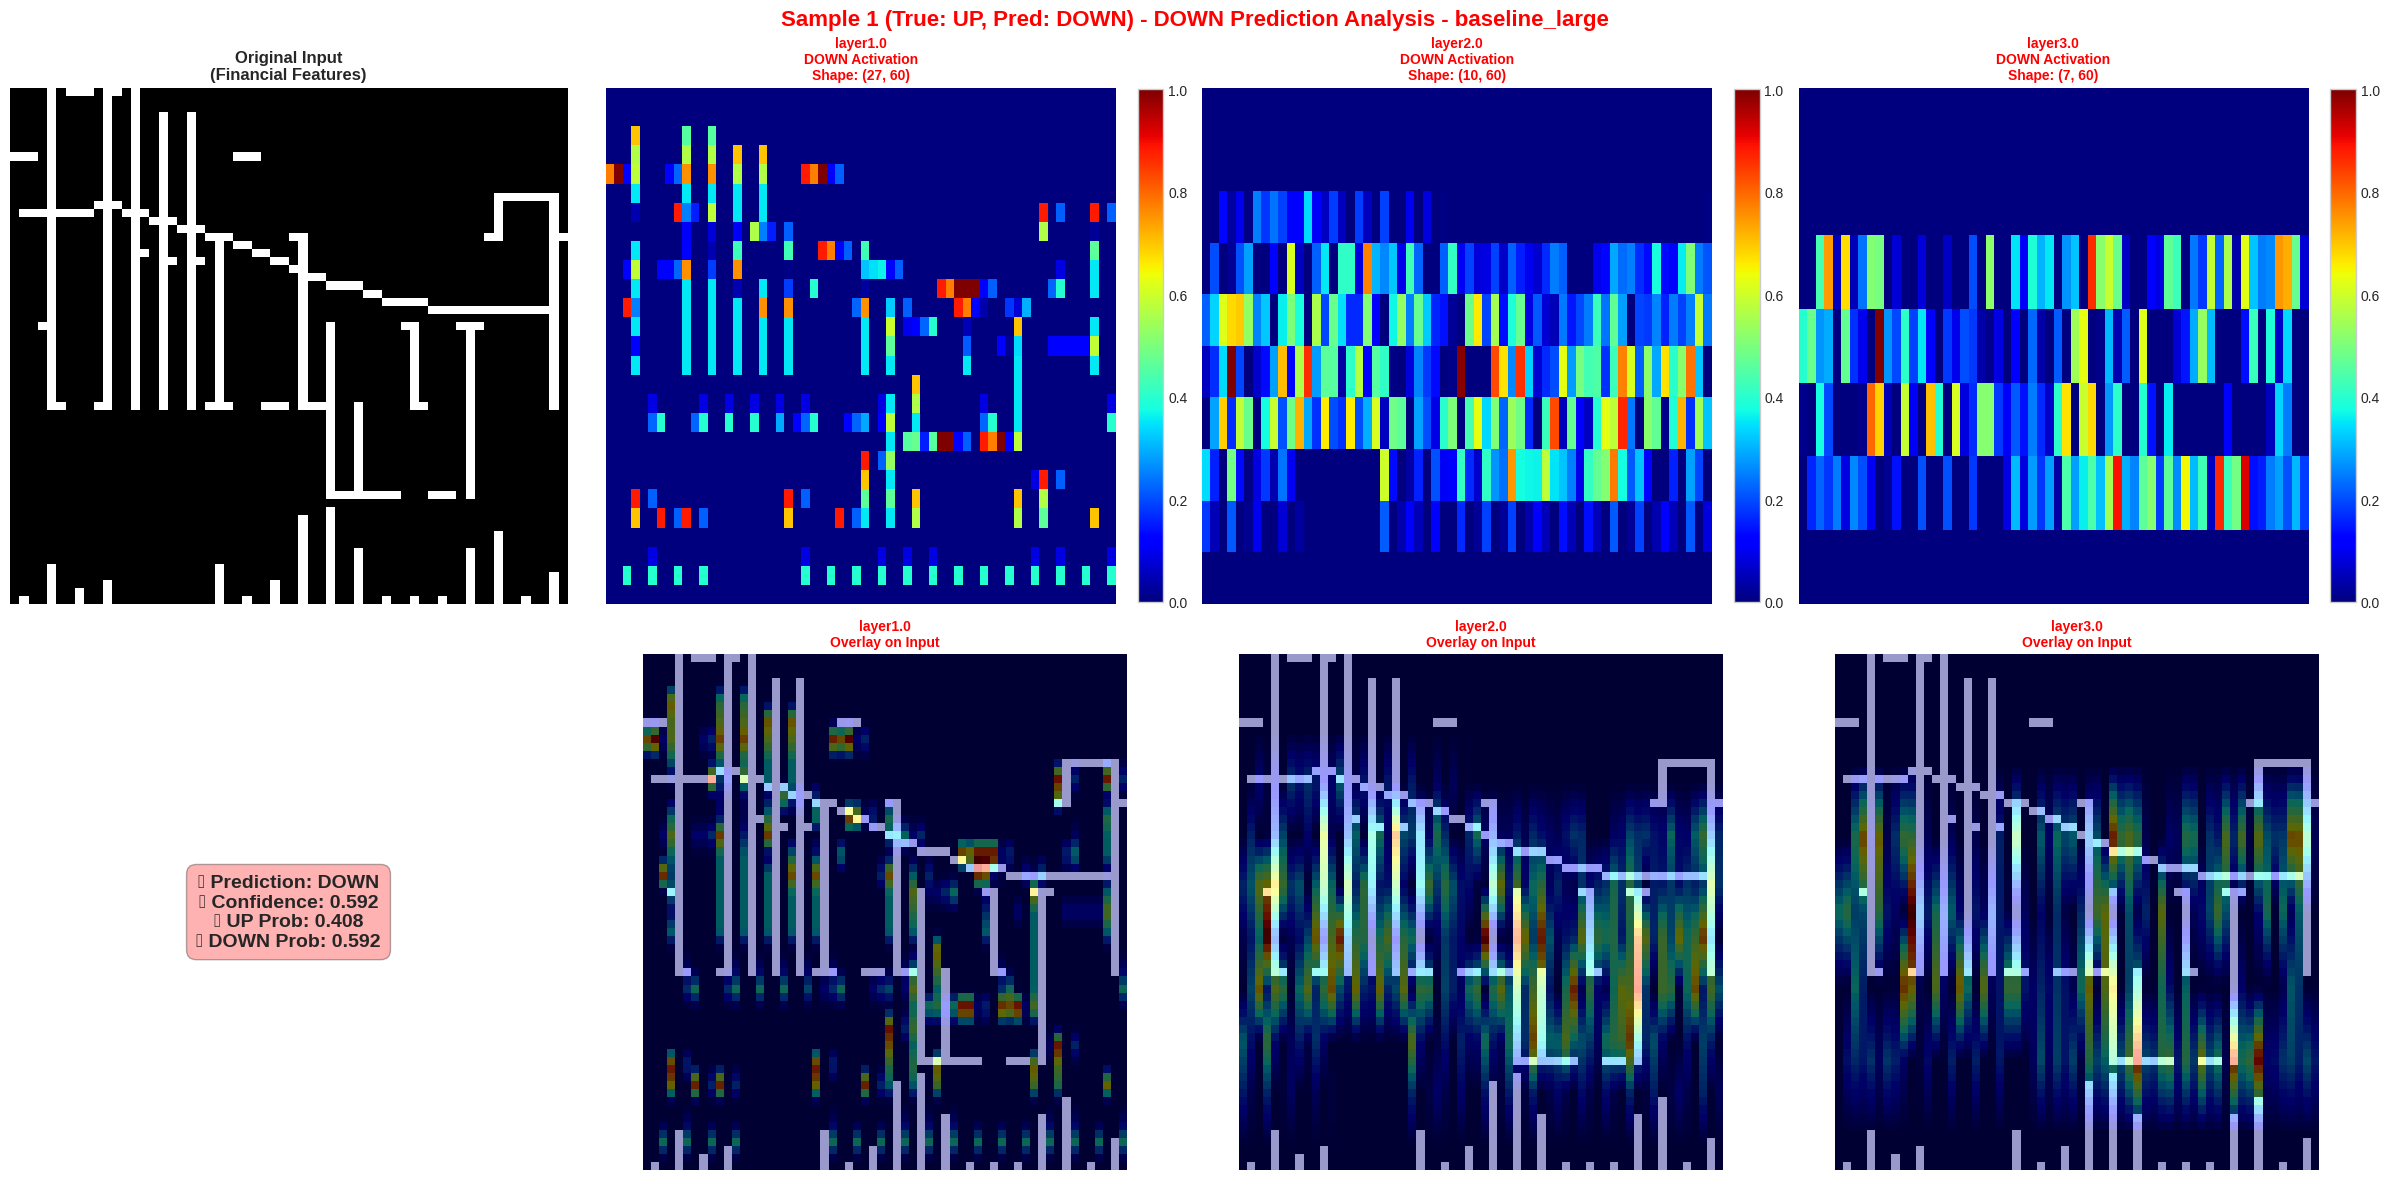

✅ Successfully analyzed DOWN prediction for sample 1

🎨 Starting multi-layer visualization for input shape: torch.Size([1, 64, 60])
🎯 Predicted class: DOWN (confidence: 0.534)

📏 Input tensor shape: torch.Size([1, 64, 60])
🔍 Forward hook [layer1.0] - Shape: torch.Size([1, 96, 27, 60])
🔍 Forward hook [layer2.0] - Shape: torch.Size([1, 192, 10, 60])
🔍 Forward hook [layer3.0] - Shape: torch.Size([1, 384, 7, 60])
📏 Model output shape: torch.Size([1, 2])
🔍 Backward hook [layer3.0] - Shape: torch.Size([1, 384, 7, 60])
🔍 Backward hook [layer2.0] - Shape: torch.Size([1, 192, 10, 60])
🔍 Backward hook [layer1.0] - Shape: torch.Size([1, 96, 27, 60])

🔧 Processing layer: layer1.0
📏 Activations shape: torch.Size([1, 96, 27, 60])
📏 Gradients shape: torch.Size([1, 96, 27, 60])
📏 CAM shape for layer1.0: (27, 60)

🔧 Processing layer: layer2.0
📏 Activations shape: torch.Size([1, 192, 10, 60])
📏 Gradients shape: torch.Size([1, 192, 10, 60])
📏 CAM shape for layer2.0: (10, 60)

🔧 Processing layer: layer3.0

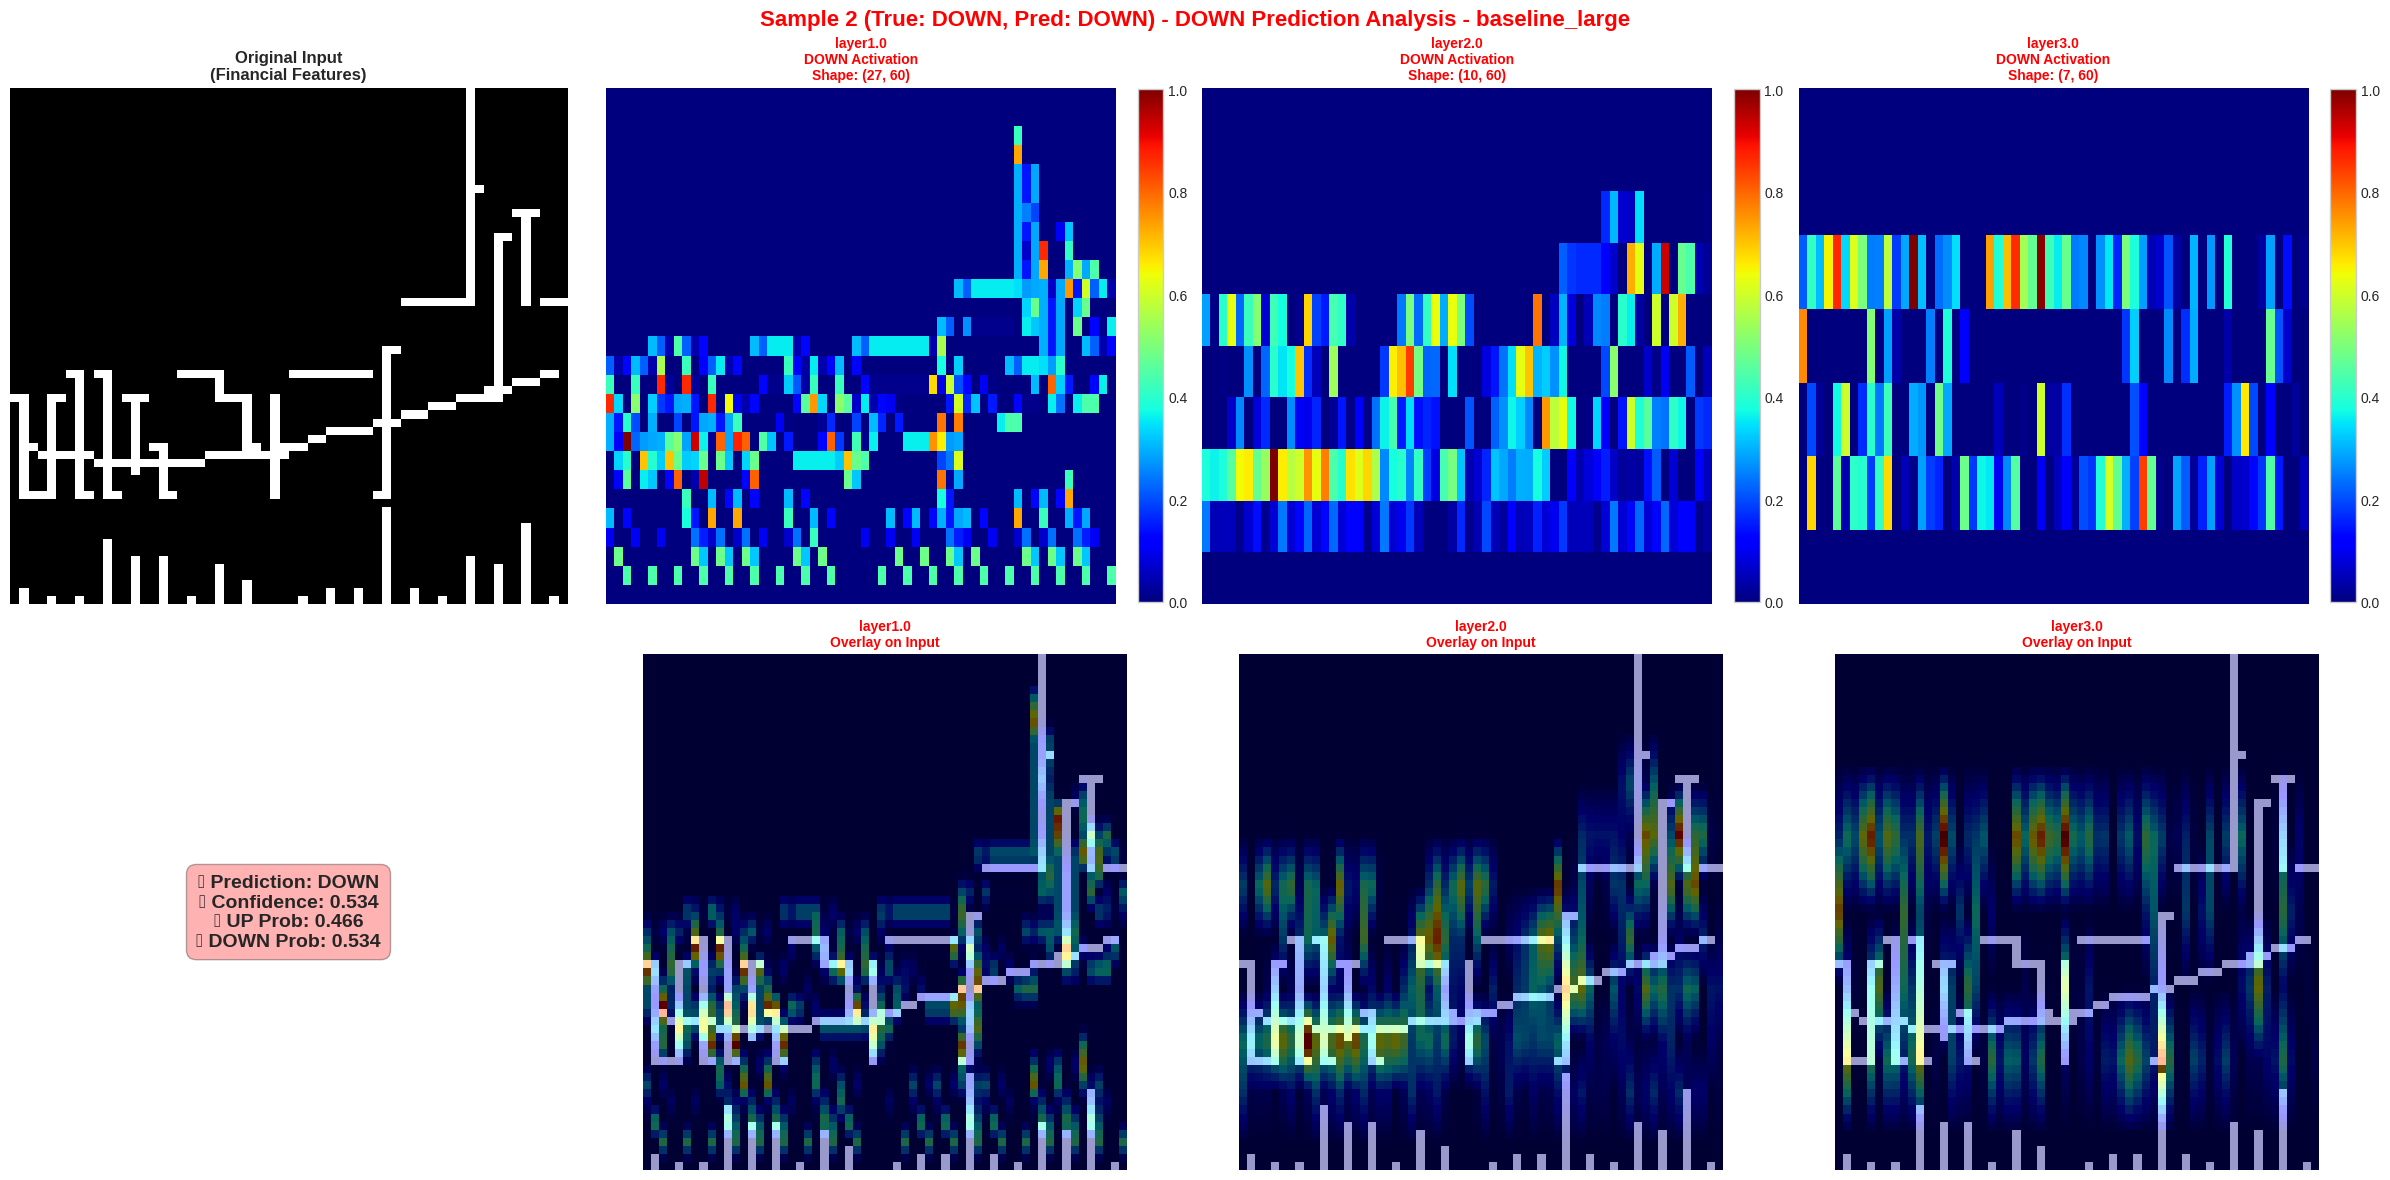

✅ Successfully analyzed DOWN prediction for sample 2

🎨 Starting multi-layer visualization for input shape: torch.Size([1, 64, 60])
🎯 Predicted class: DOWN (confidence: 0.601)

📏 Input tensor shape: torch.Size([1, 64, 60])
🔍 Forward hook [layer1.0] - Shape: torch.Size([1, 96, 27, 60])
🔍 Forward hook [layer2.0] - Shape: torch.Size([1, 192, 10, 60])
🔍 Forward hook [layer3.0] - Shape: torch.Size([1, 384, 7, 60])
📏 Model output shape: torch.Size([1, 2])
🔍 Backward hook [layer3.0] - Shape: torch.Size([1, 384, 7, 60])
🔍 Backward hook [layer2.0] - Shape: torch.Size([1, 192, 10, 60])
🔍 Backward hook [layer1.0] - Shape: torch.Size([1, 96, 27, 60])

🔧 Processing layer: layer1.0
📏 Activations shape: torch.Size([1, 96, 27, 60])
📏 Gradients shape: torch.Size([1, 96, 27, 60])
📏 CAM shape for layer1.0: (27, 60)

🔧 Processing layer: layer2.0
📏 Activations shape: torch.Size([1, 192, 10, 60])
📏 Gradients shape: torch.Size([1, 192, 10, 60])
📏 CAM shape for layer2.0: (10, 60)

🔧 Processing layer: layer3.0

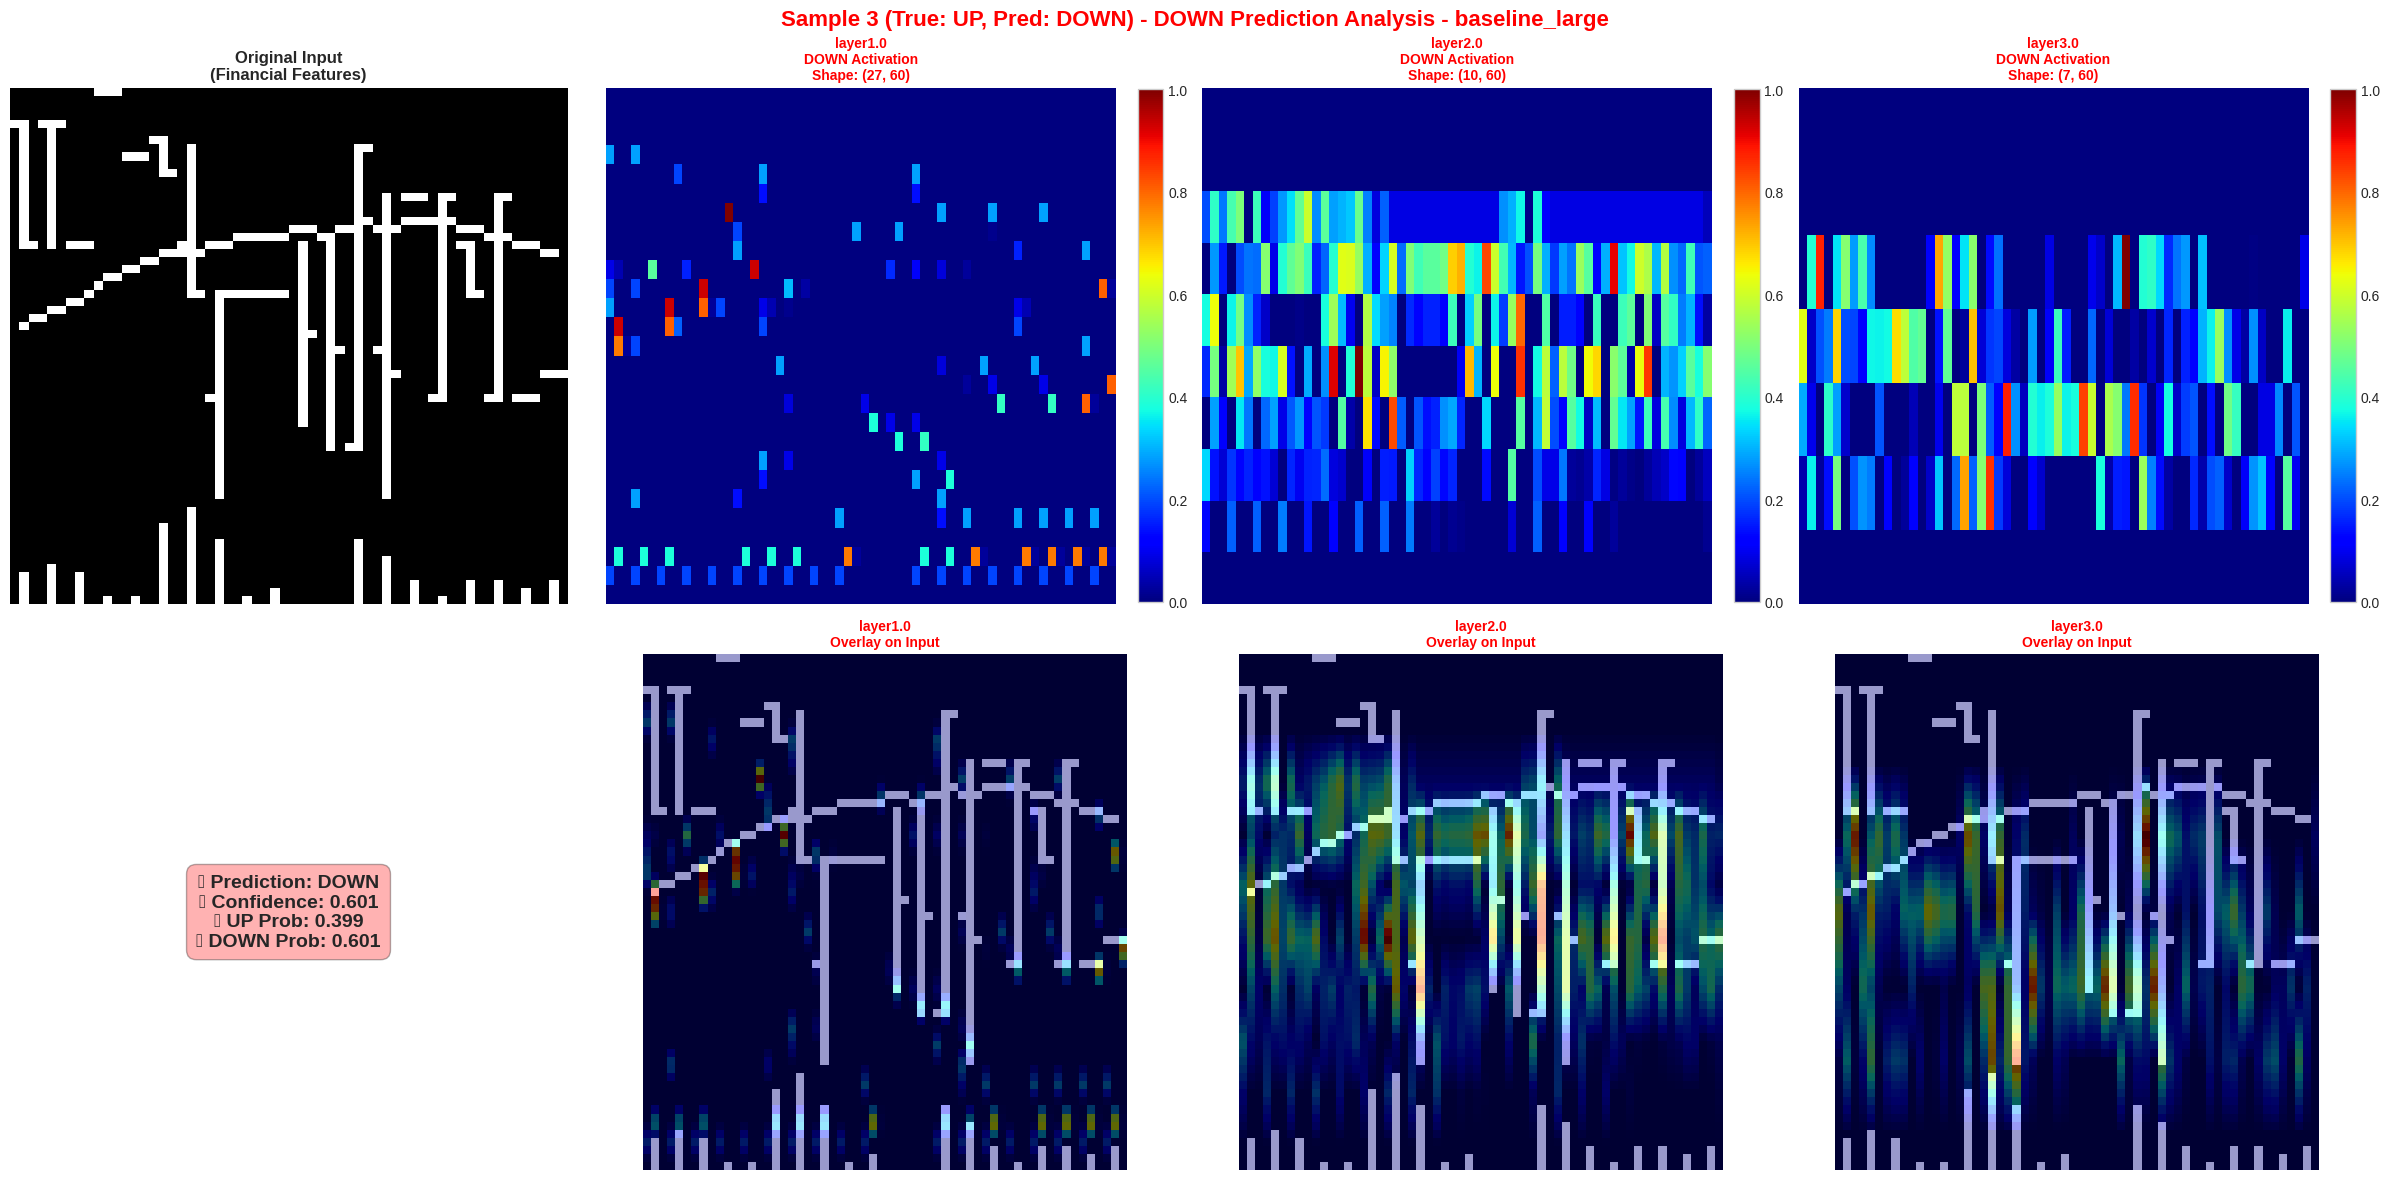

✅ Successfully analyzed DOWN prediction for sample 3

🎨 Starting multi-layer visualization for input shape: torch.Size([1, 64, 60])
🎯 Predicted class: DOWN (confidence: 0.518)

📏 Input tensor shape: torch.Size([1, 64, 60])
🔍 Forward hook [layer1.0] - Shape: torch.Size([1, 96, 27, 60])
🔍 Forward hook [layer2.0] - Shape: torch.Size([1, 192, 10, 60])
🔍 Forward hook [layer3.0] - Shape: torch.Size([1, 384, 7, 60])
📏 Model output shape: torch.Size([1, 2])
🔍 Backward hook [layer3.0] - Shape: torch.Size([1, 384, 7, 60])
🔍 Backward hook [layer2.0] - Shape: torch.Size([1, 192, 10, 60])
🔍 Backward hook [layer1.0] - Shape: torch.Size([1, 96, 27, 60])

🔧 Processing layer: layer1.0
📏 Activations shape: torch.Size([1, 96, 27, 60])
📏 Gradients shape: torch.Size([1, 96, 27, 60])
📏 CAM shape for layer1.0: (27, 60)

🔧 Processing layer: layer2.0
📏 Activations shape: torch.Size([1, 192, 10, 60])
📏 Gradients shape: torch.Size([1, 192, 10, 60])
📏 CAM shape for layer2.0: (10, 60)

🔧 Processing layer: layer3.0

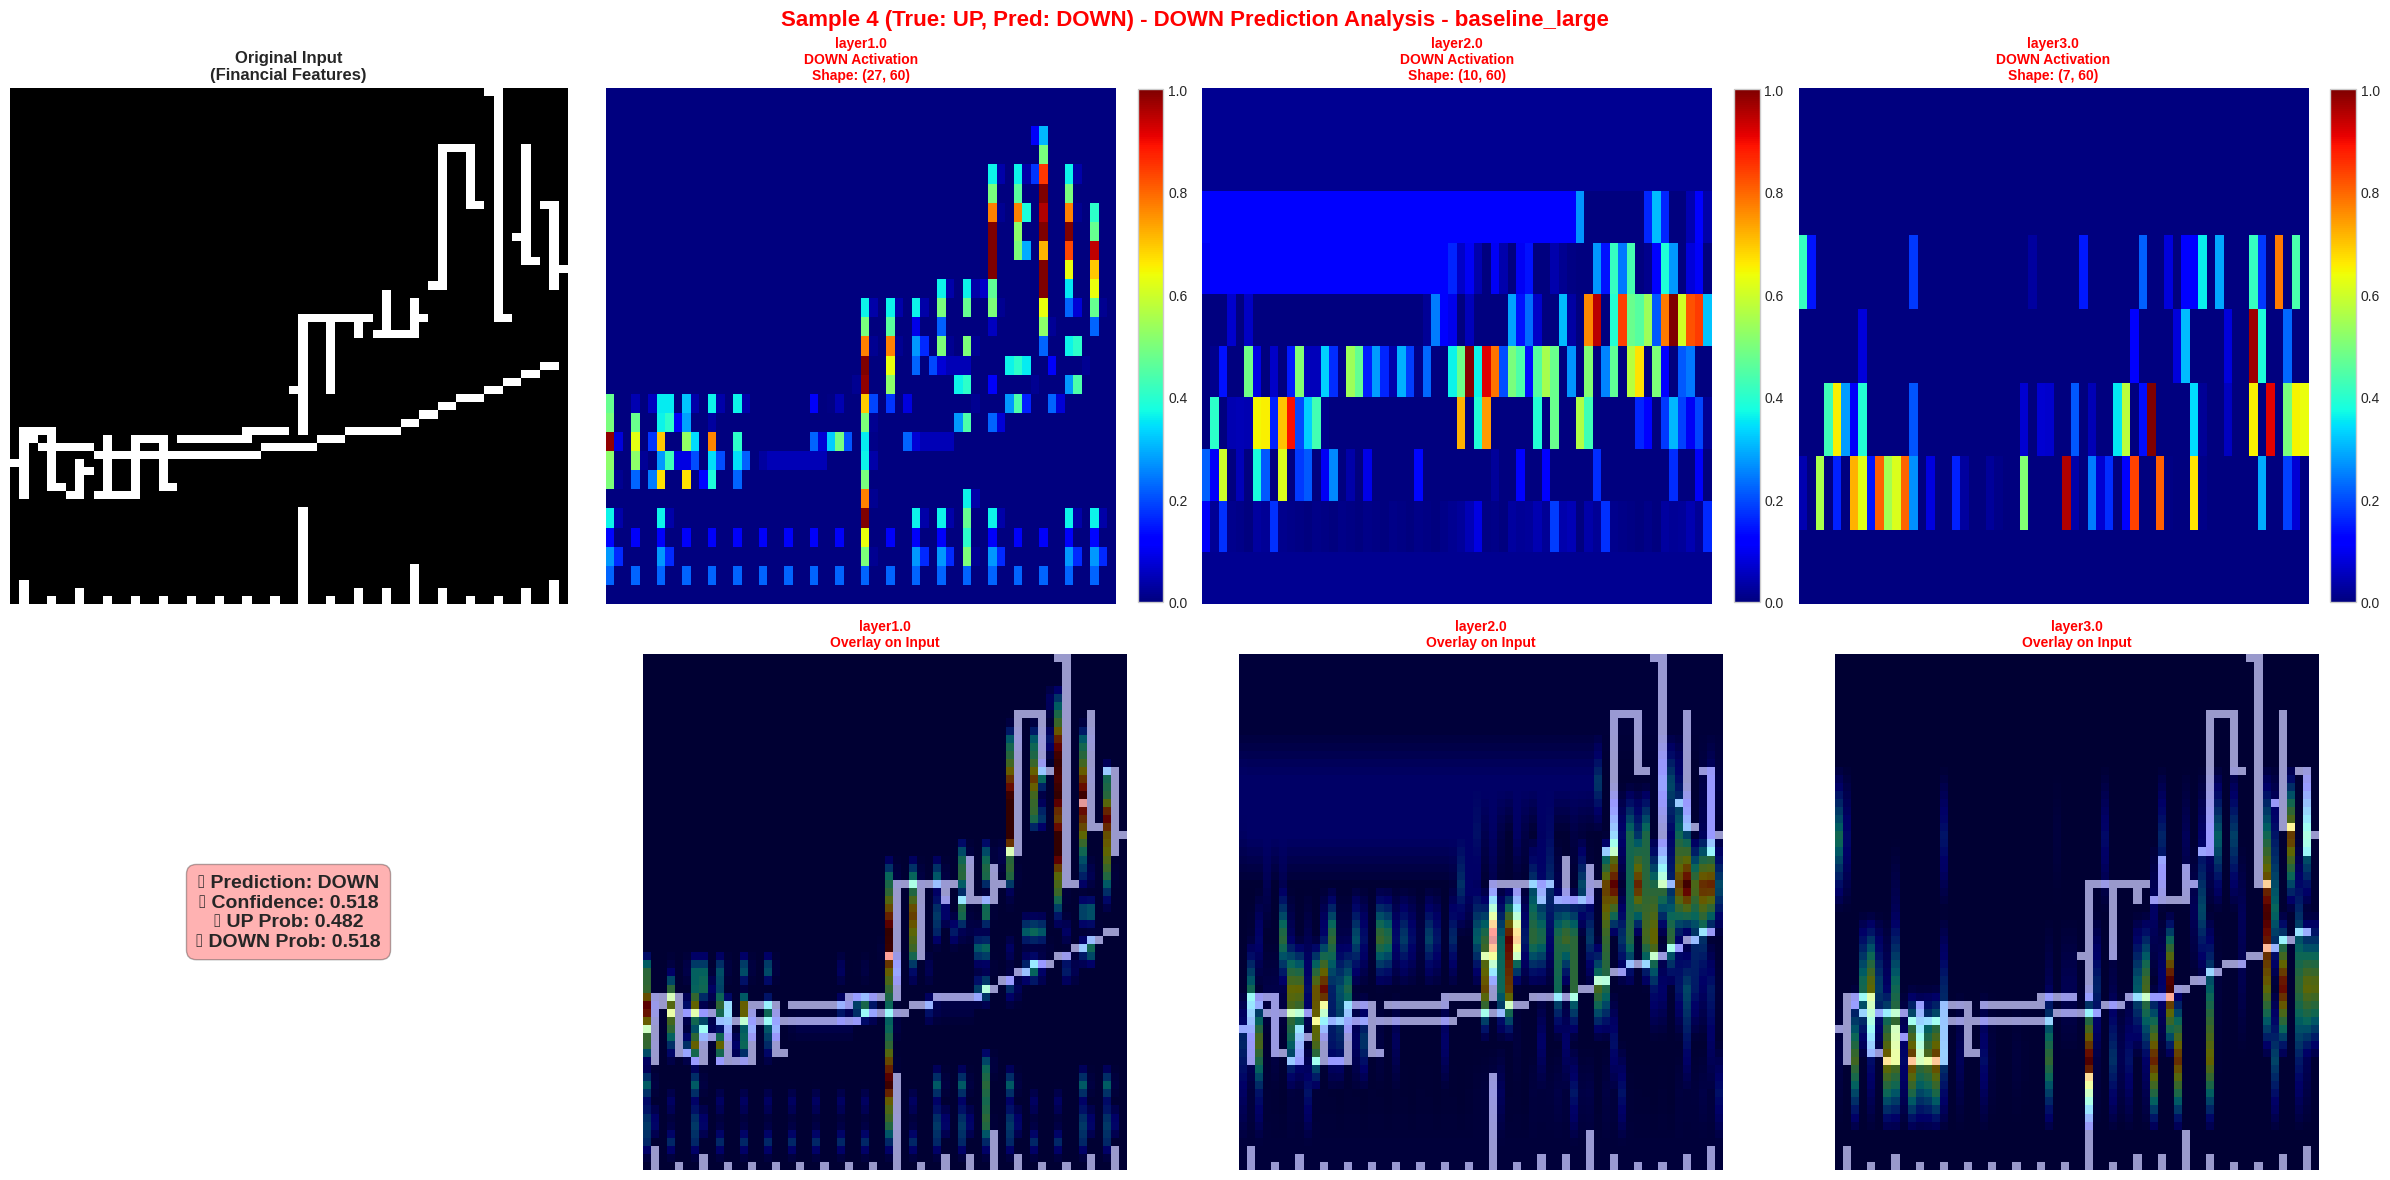

✅ Successfully analyzed DOWN prediction for sample 4

🎨 Starting multi-layer visualization for input shape: torch.Size([1, 64, 60])
🎯 Predicted class: DOWN (confidence: 0.535)

📏 Input tensor shape: torch.Size([1, 64, 60])
🔍 Forward hook [layer1.0] - Shape: torch.Size([1, 96, 27, 60])
🔍 Forward hook [layer2.0] - Shape: torch.Size([1, 192, 10, 60])
🔍 Forward hook [layer3.0] - Shape: torch.Size([1, 384, 7, 60])
📏 Model output shape: torch.Size([1, 2])
🔍 Backward hook [layer3.0] - Shape: torch.Size([1, 384, 7, 60])
🔍 Backward hook [layer2.0] - Shape: torch.Size([1, 192, 10, 60])
🔍 Backward hook [layer1.0] - Shape: torch.Size([1, 96, 27, 60])

🔧 Processing layer: layer1.0
📏 Activations shape: torch.Size([1, 96, 27, 60])
📏 Gradients shape: torch.Size([1, 96, 27, 60])
📏 CAM shape for layer1.0: (27, 60)

🔧 Processing layer: layer2.0
📏 Activations shape: torch.Size([1, 192, 10, 60])
📏 Gradients shape: torch.Size([1, 192, 10, 60])
📏 CAM shape for layer2.0: (10, 60)

🔧 Processing layer: layer3.0

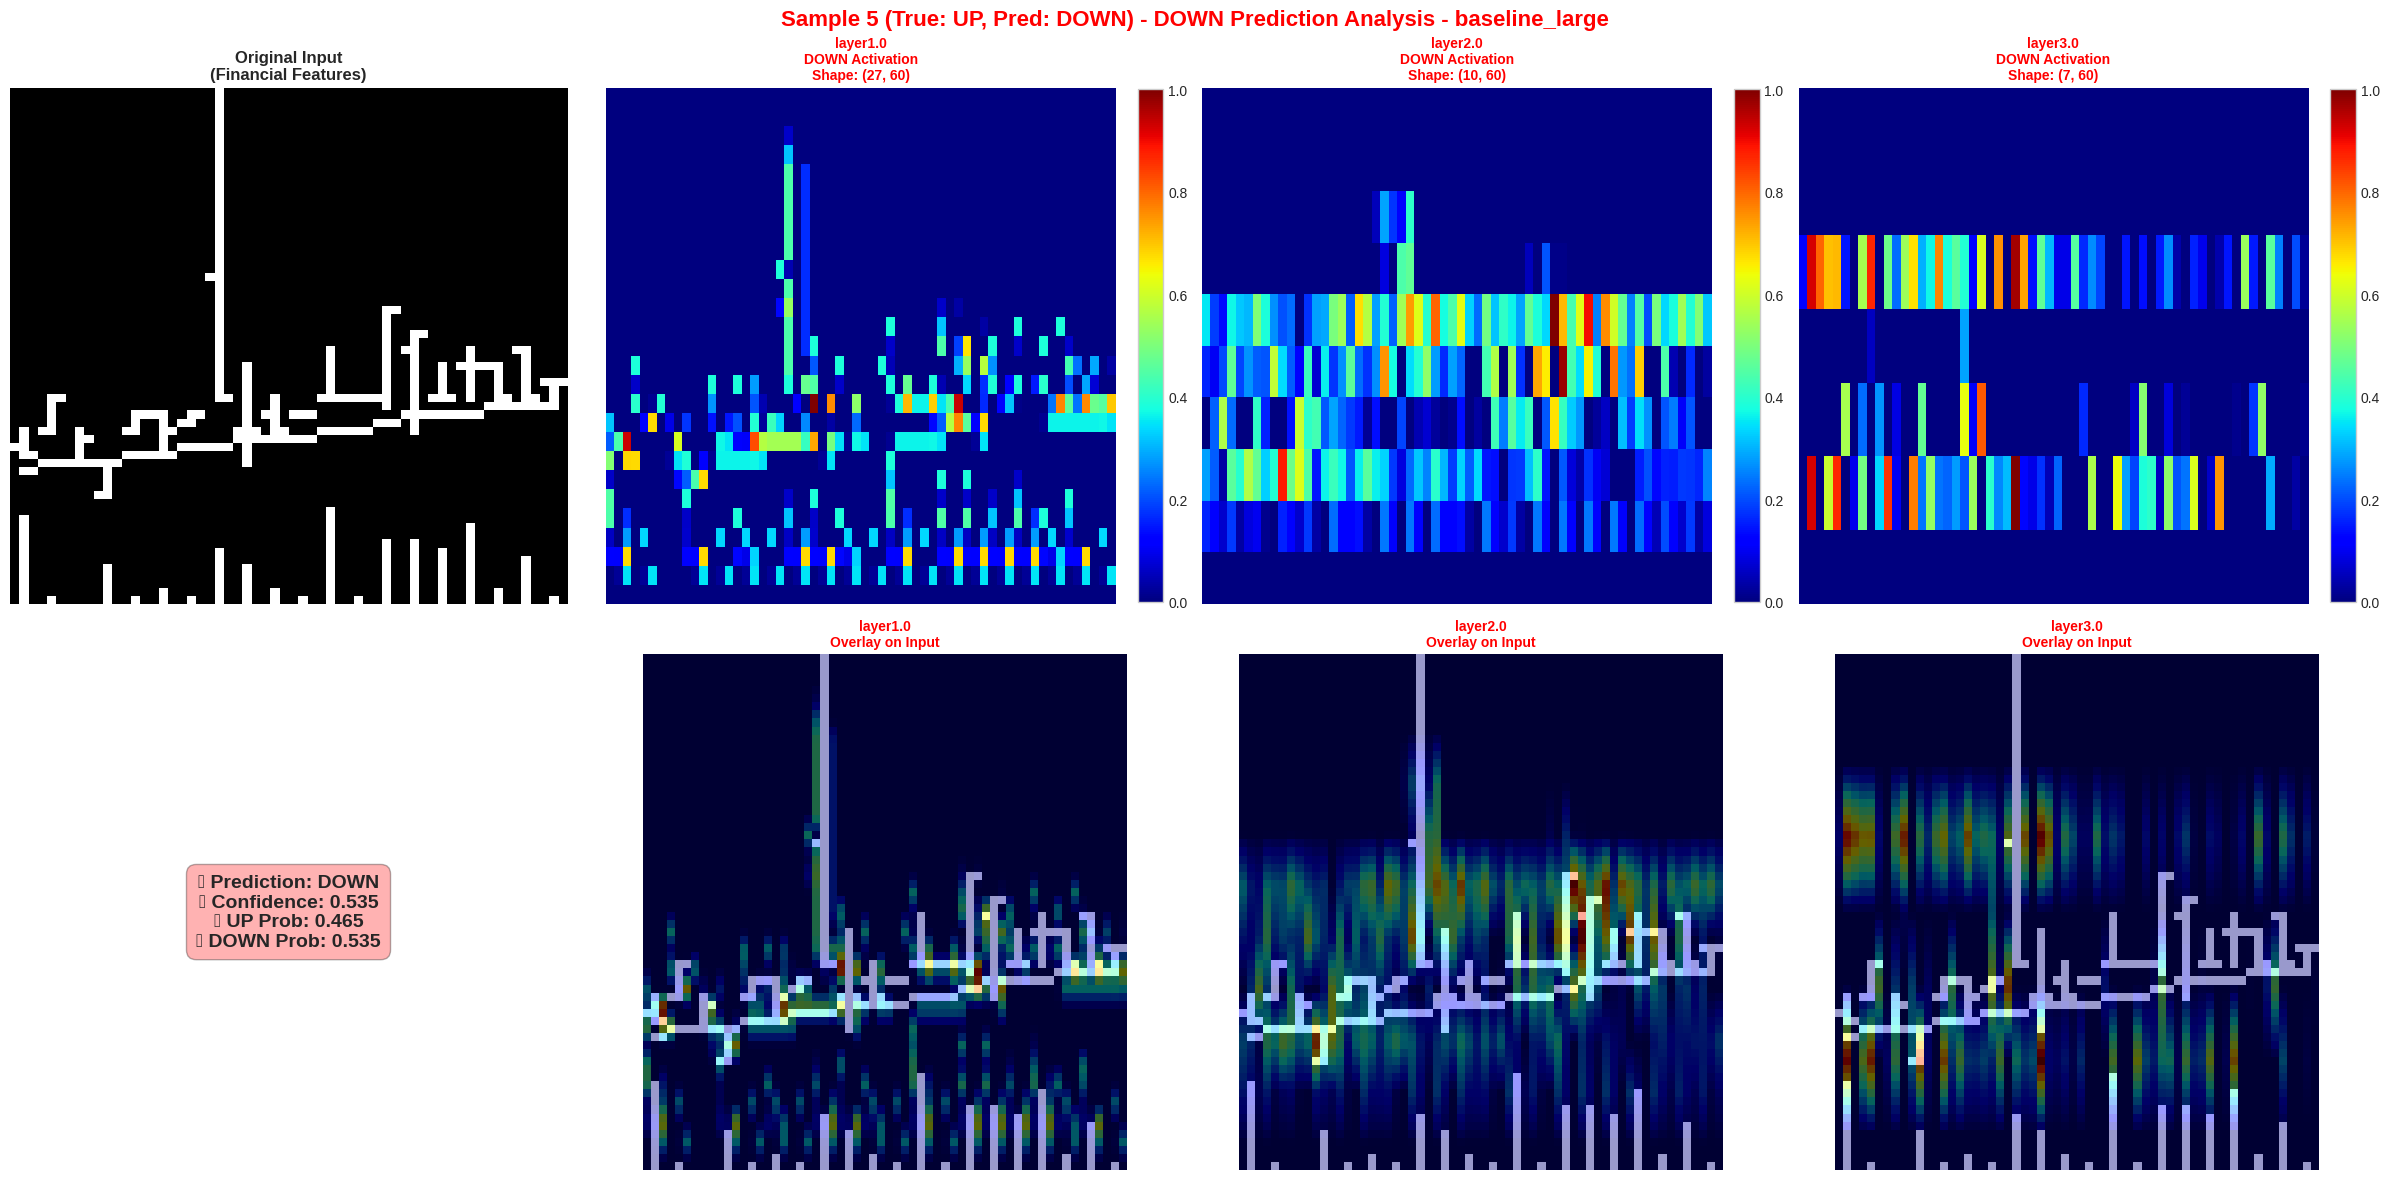

✅ Successfully analyzed DOWN prediction for sample 5

🎨 Starting multi-layer visualization for input shape: torch.Size([1, 64, 60])
🎯 Predicted class: DOWN (confidence: 0.521)

📏 Input tensor shape: torch.Size([1, 64, 60])
🔍 Forward hook [layer1.0] - Shape: torch.Size([1, 96, 27, 60])
🔍 Forward hook [layer2.0] - Shape: torch.Size([1, 192, 10, 60])
🔍 Forward hook [layer3.0] - Shape: torch.Size([1, 384, 7, 60])
📏 Model output shape: torch.Size([1, 2])
🔍 Backward hook [layer3.0] - Shape: torch.Size([1, 384, 7, 60])
🔍 Backward hook [layer2.0] - Shape: torch.Size([1, 192, 10, 60])
🔍 Backward hook [layer1.0] - Shape: torch.Size([1, 96, 27, 60])

🔧 Processing layer: layer1.0
📏 Activations shape: torch.Size([1, 96, 27, 60])
📏 Gradients shape: torch.Size([1, 96, 27, 60])
📏 CAM shape for layer1.0: (27, 60)

🔧 Processing layer: layer2.0
📏 Activations shape: torch.Size([1, 192, 10, 60])
📏 Gradients shape: torch.Size([1, 192, 10, 60])
📏 CAM shape for layer2.0: (10, 60)

🔧 Processing layer: layer3.0

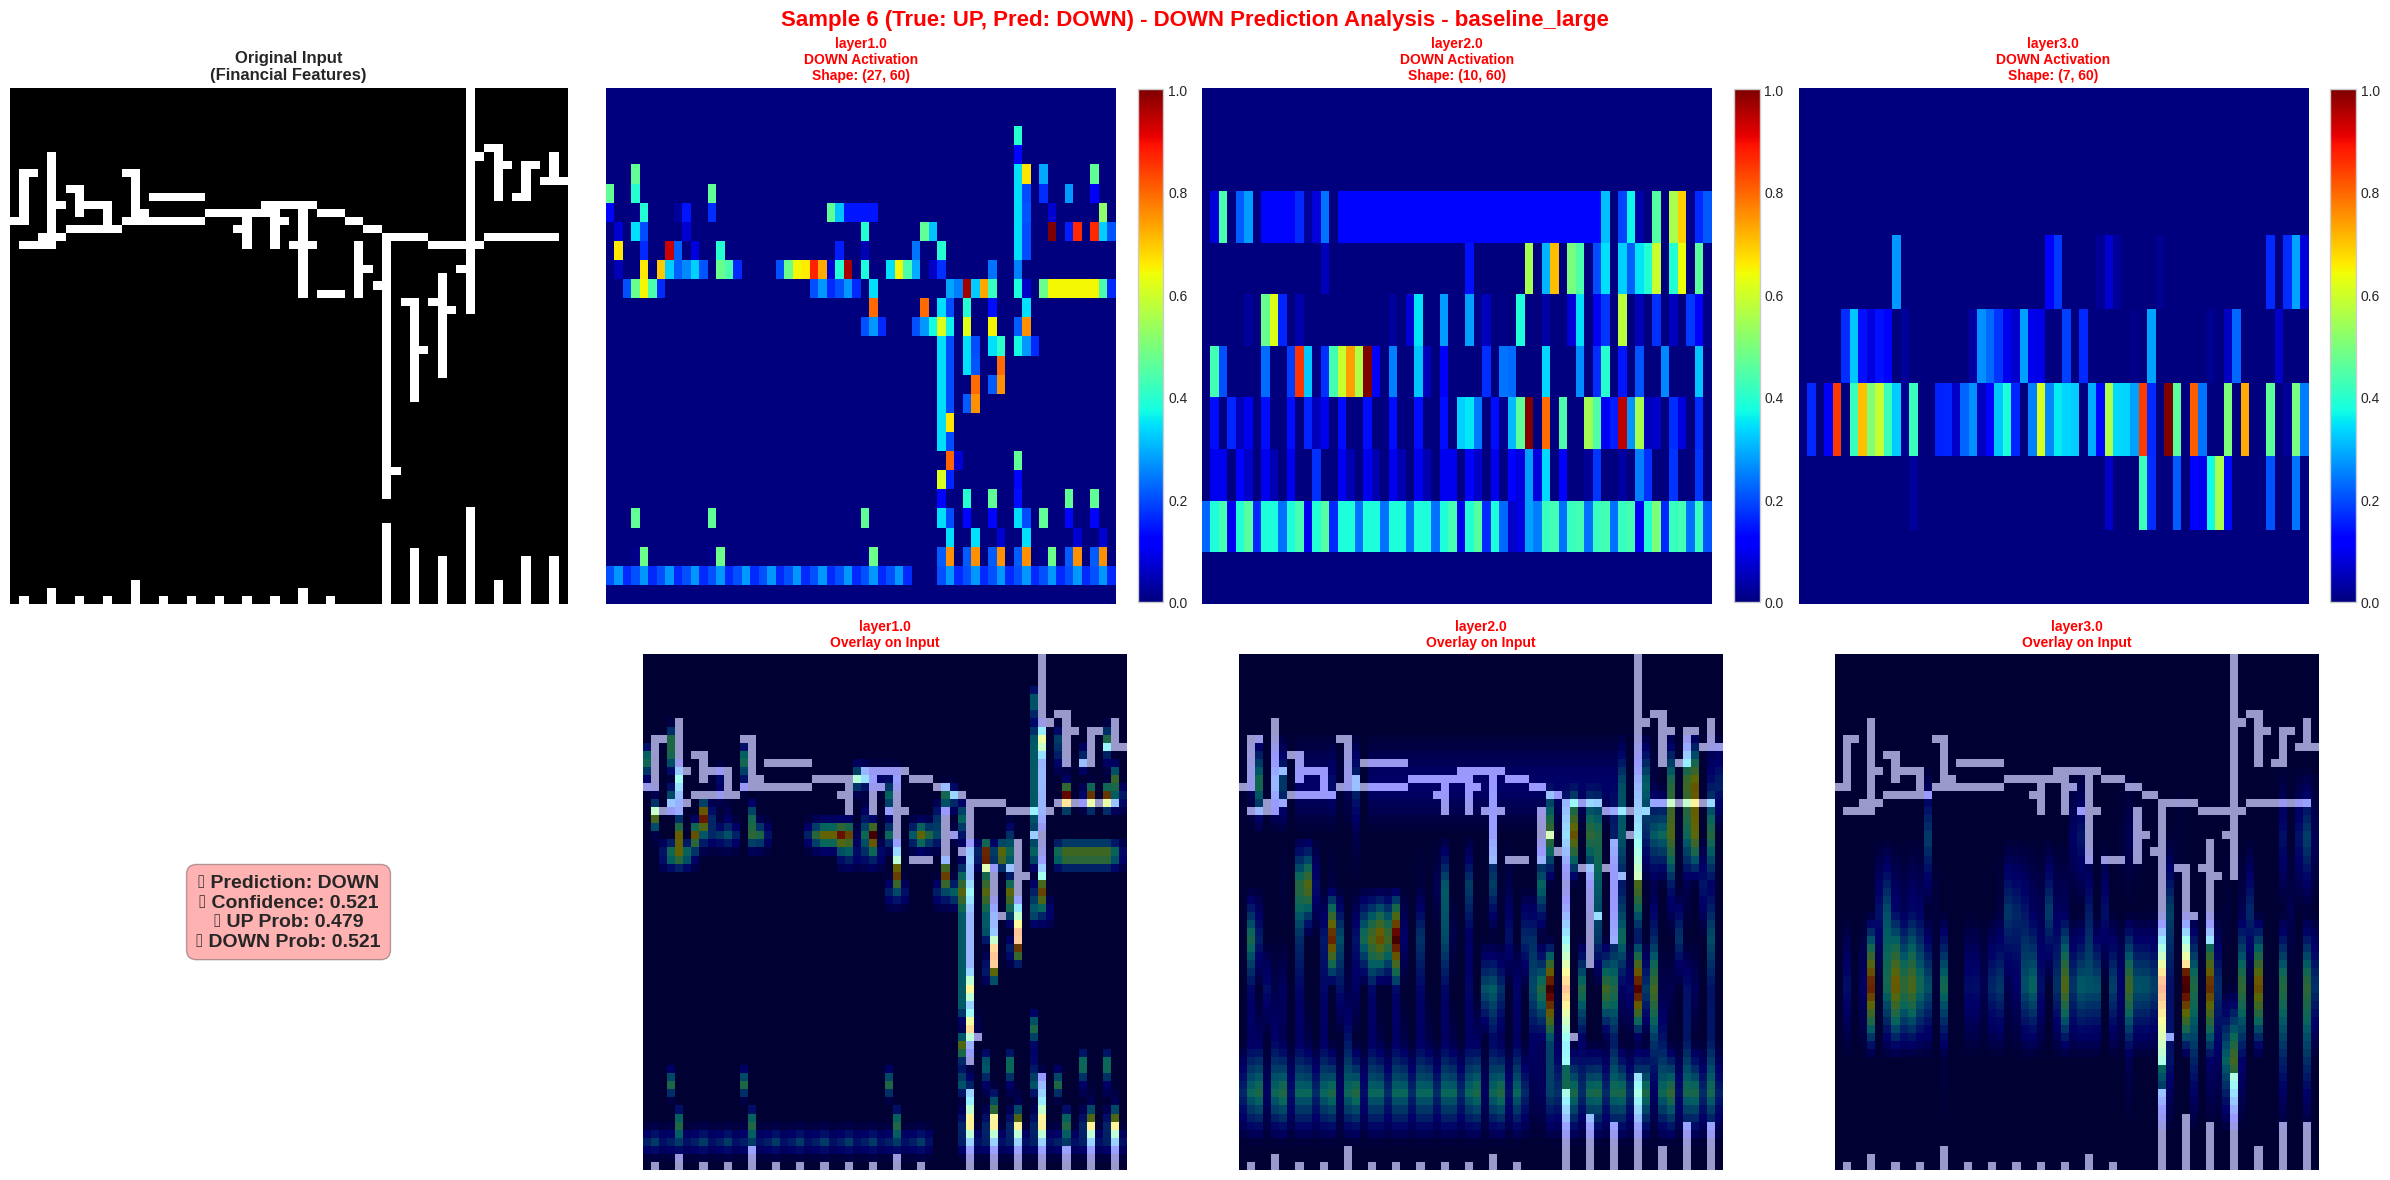

✅ Successfully analyzed DOWN prediction for sample 6

🎨 Starting multi-layer visualization for input shape: torch.Size([1, 64, 60])
🎯 Predicted class: DOWN (confidence: 0.565)

📏 Input tensor shape: torch.Size([1, 64, 60])
🔍 Forward hook [layer1.0] - Shape: torch.Size([1, 96, 27, 60])
🔍 Forward hook [layer2.0] - Shape: torch.Size([1, 192, 10, 60])
🔍 Forward hook [layer3.0] - Shape: torch.Size([1, 384, 7, 60])
📏 Model output shape: torch.Size([1, 2])
🔍 Backward hook [layer3.0] - Shape: torch.Size([1, 384, 7, 60])
🔍 Backward hook [layer2.0] - Shape: torch.Size([1, 192, 10, 60])
🔍 Backward hook [layer1.0] - Shape: torch.Size([1, 96, 27, 60])

🔧 Processing layer: layer1.0
📏 Activations shape: torch.Size([1, 96, 27, 60])
📏 Gradients shape: torch.Size([1, 96, 27, 60])
📏 CAM shape for layer1.0: (27, 60)

🔧 Processing layer: layer2.0
📏 Activations shape: torch.Size([1, 192, 10, 60])
📏 Gradients shape: torch.Size([1, 192, 10, 60])
📏 CAM shape for layer2.0: (10, 60)

🔧 Processing layer: layer3.0

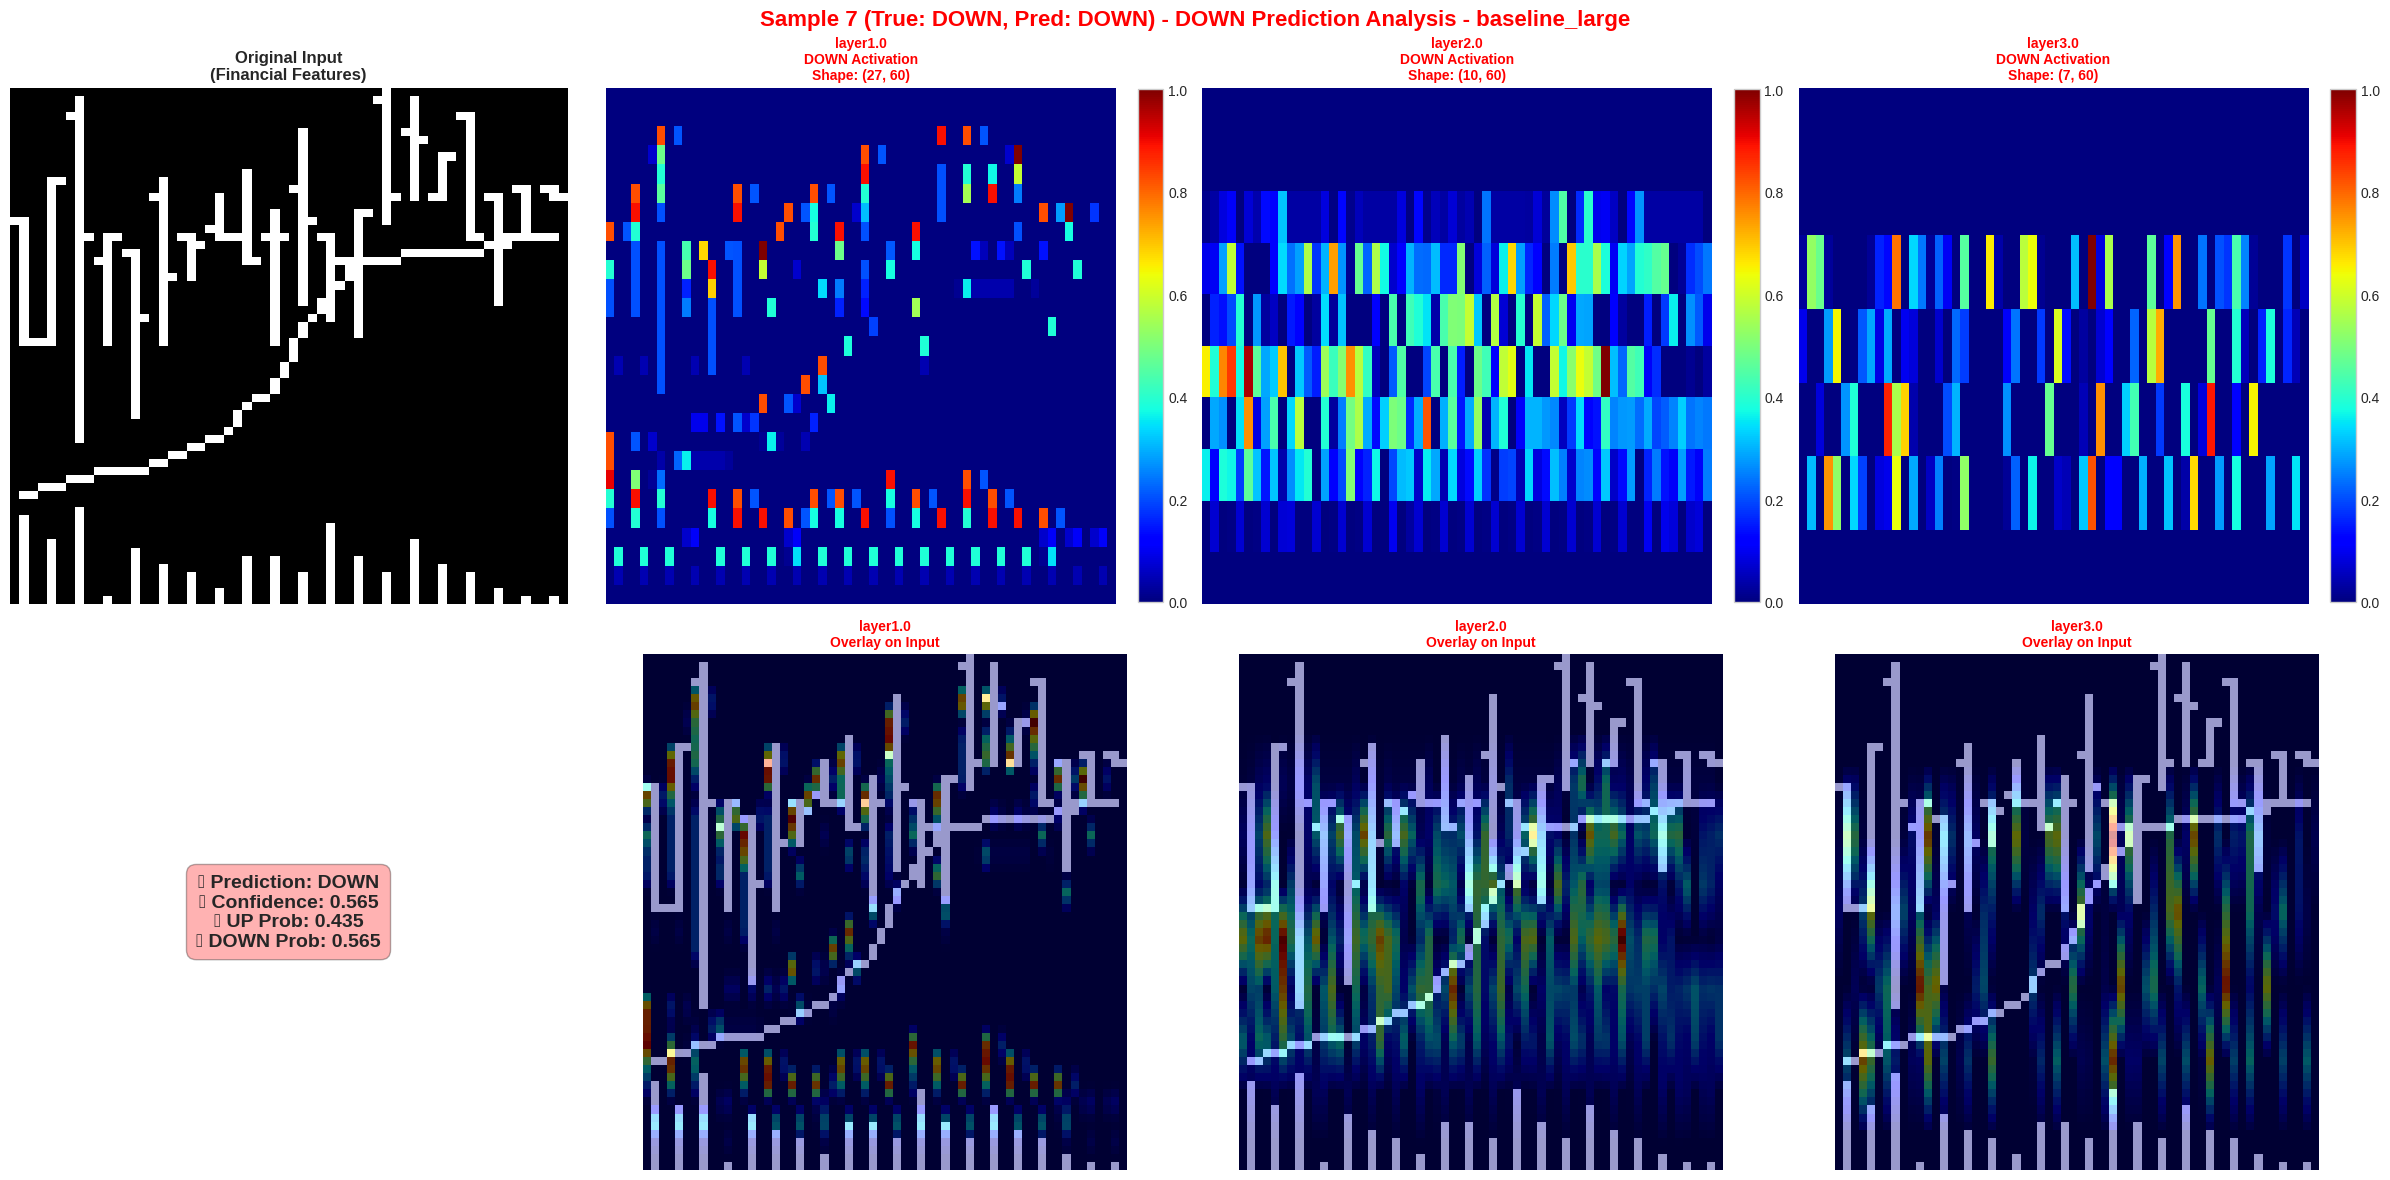

✅ Successfully analyzed DOWN prediction for sample 7

🎨 Starting multi-layer visualization for input shape: torch.Size([1, 64, 60])
🎯 Predicted class: DOWN (confidence: 0.521)

📏 Input tensor shape: torch.Size([1, 64, 60])
🔍 Forward hook [layer1.0] - Shape: torch.Size([1, 96, 27, 60])
🔍 Forward hook [layer2.0] - Shape: torch.Size([1, 192, 10, 60])
🔍 Forward hook [layer3.0] - Shape: torch.Size([1, 384, 7, 60])
📏 Model output shape: torch.Size([1, 2])
🔍 Backward hook [layer3.0] - Shape: torch.Size([1, 384, 7, 60])
🔍 Backward hook [layer2.0] - Shape: torch.Size([1, 192, 10, 60])
🔍 Backward hook [layer1.0] - Shape: torch.Size([1, 96, 27, 60])

🔧 Processing layer: layer1.0
📏 Activations shape: torch.Size([1, 96, 27, 60])
📏 Gradients shape: torch.Size([1, 96, 27, 60])
📏 CAM shape for layer1.0: (27, 60)

🔧 Processing layer: layer2.0
📏 Activations shape: torch.Size([1, 192, 10, 60])
📏 Gradients shape: torch.Size([1, 192, 10, 60])
📏 CAM shape for layer2.0: (10, 60)

🔧 Processing layer: layer3.0

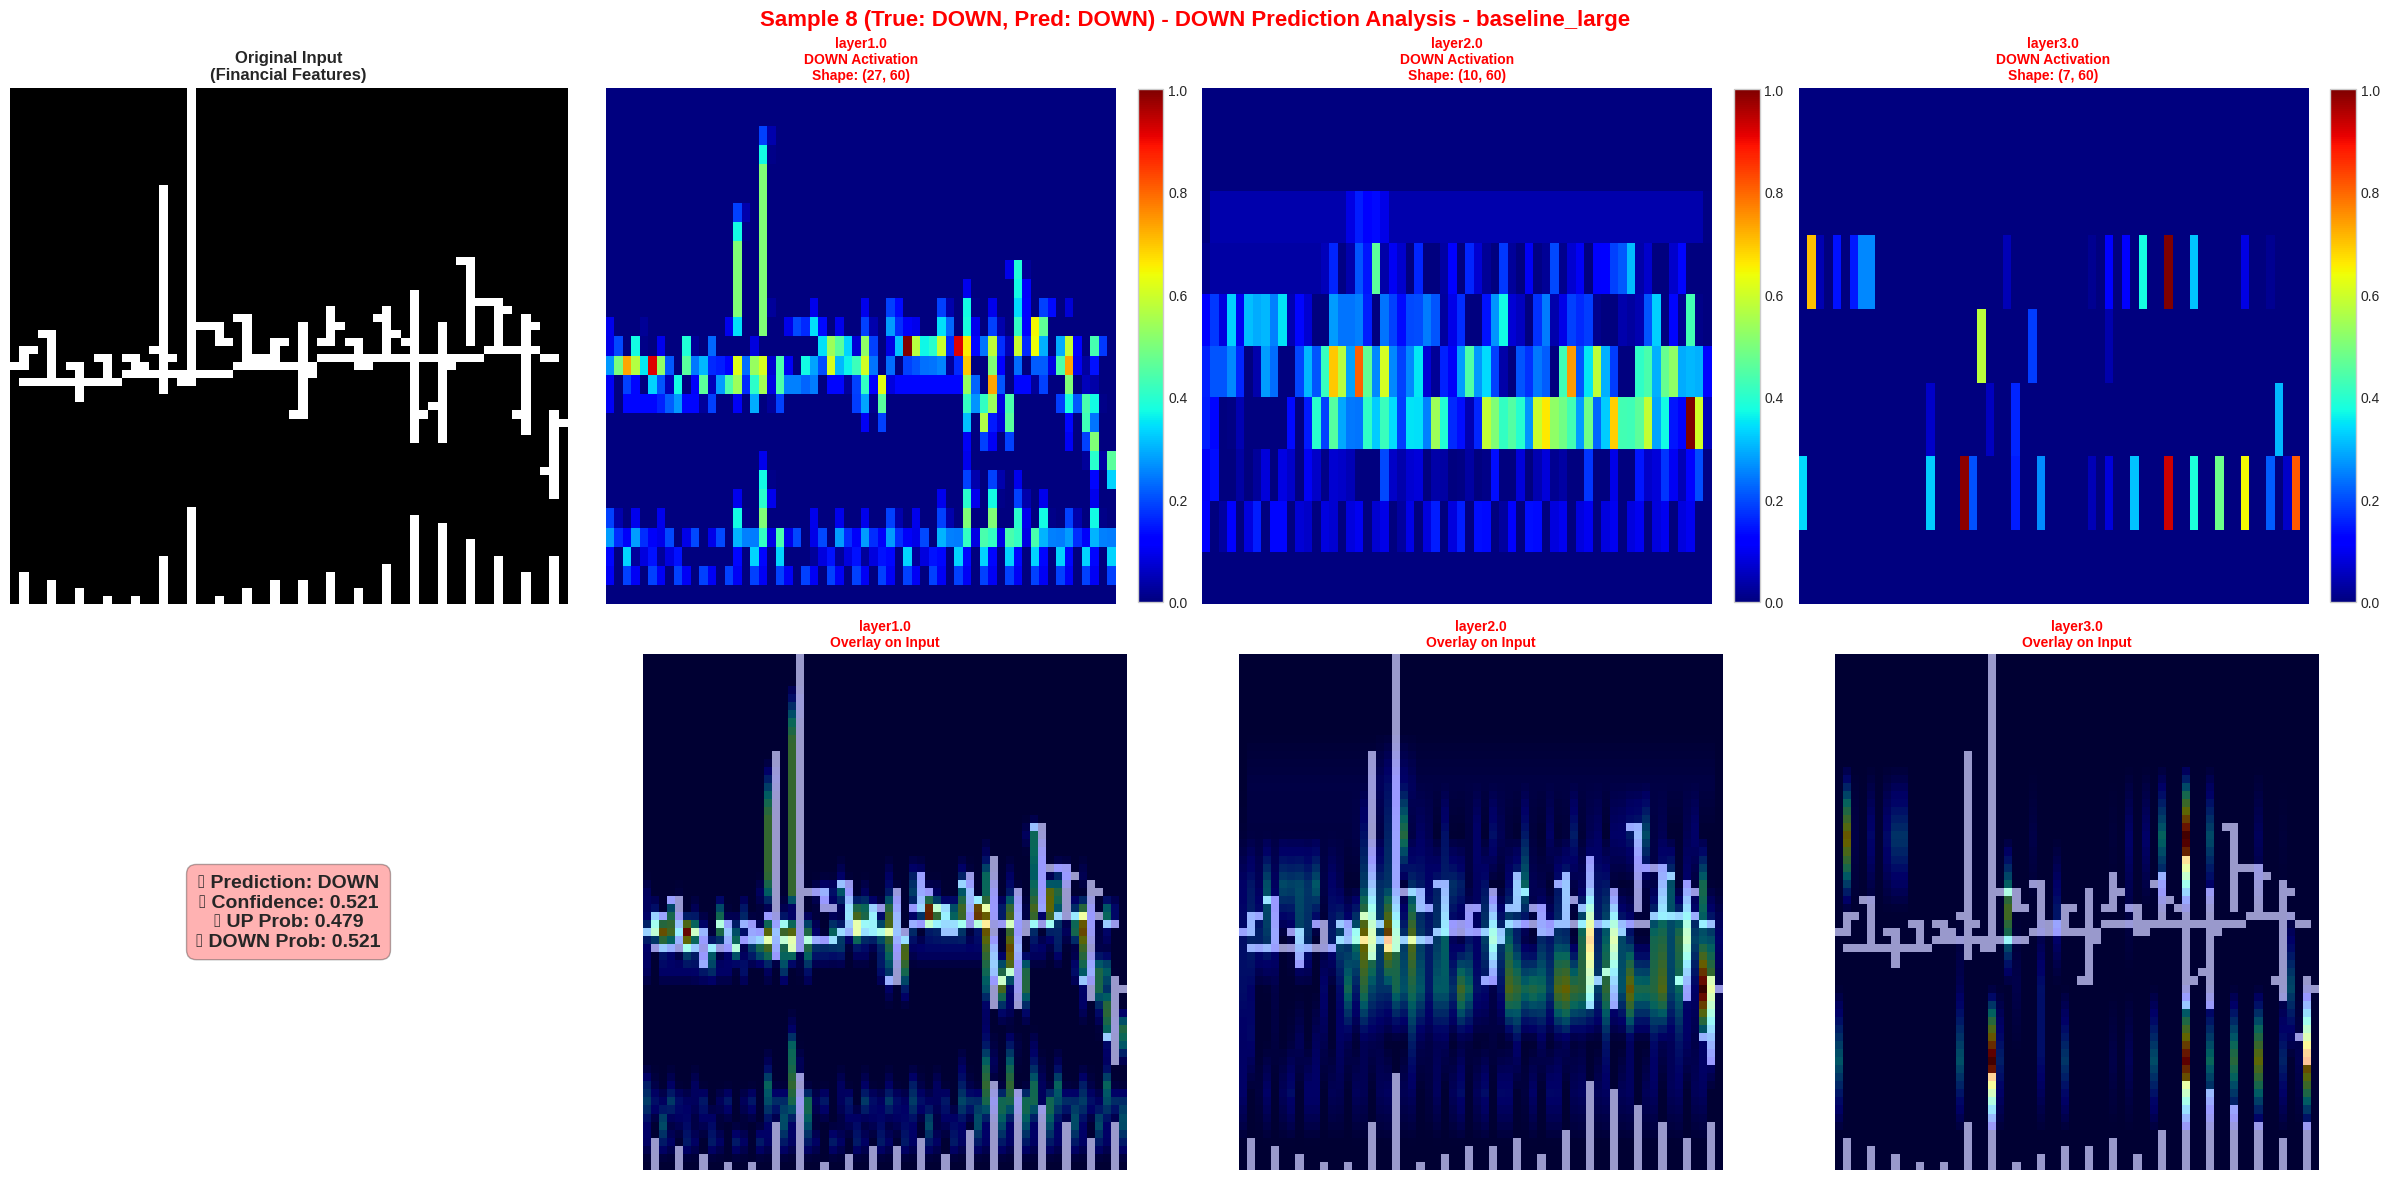

✅ Successfully analyzed DOWN prediction for sample 8

🎨 Starting multi-layer visualization for input shape: torch.Size([1, 64, 60])
🎯 Predicted class: UP (confidence: 0.516)

📏 Input tensor shape: torch.Size([1, 64, 60])
🔍 Forward hook [layer1.0] - Shape: torch.Size([1, 96, 27, 60])
🔍 Forward hook [layer2.0] - Shape: torch.Size([1, 192, 10, 60])
🔍 Forward hook [layer3.0] - Shape: torch.Size([1, 384, 7, 60])
📏 Model output shape: torch.Size([1, 2])
🔍 Backward hook [layer3.0] - Shape: torch.Size([1, 384, 7, 60])
🔍 Backward hook [layer2.0] - Shape: torch.Size([1, 192, 10, 60])
🔍 Backward hook [layer1.0] - Shape: torch.Size([1, 96, 27, 60])

🔧 Processing layer: layer1.0
📏 Activations shape: torch.Size([1, 96, 27, 60])
📏 Gradients shape: torch.Size([1, 96, 27, 60])
📏 CAM shape for layer1.0: (27, 60)

🔧 Processing layer: layer2.0
📏 Activations shape: torch.Size([1, 192, 10, 60])
📏 Gradients shape: torch.Size([1, 192, 10, 60])
📏 CAM shape for layer2.0: (10, 60)

🔧 Processing layer: layer3.0
📏

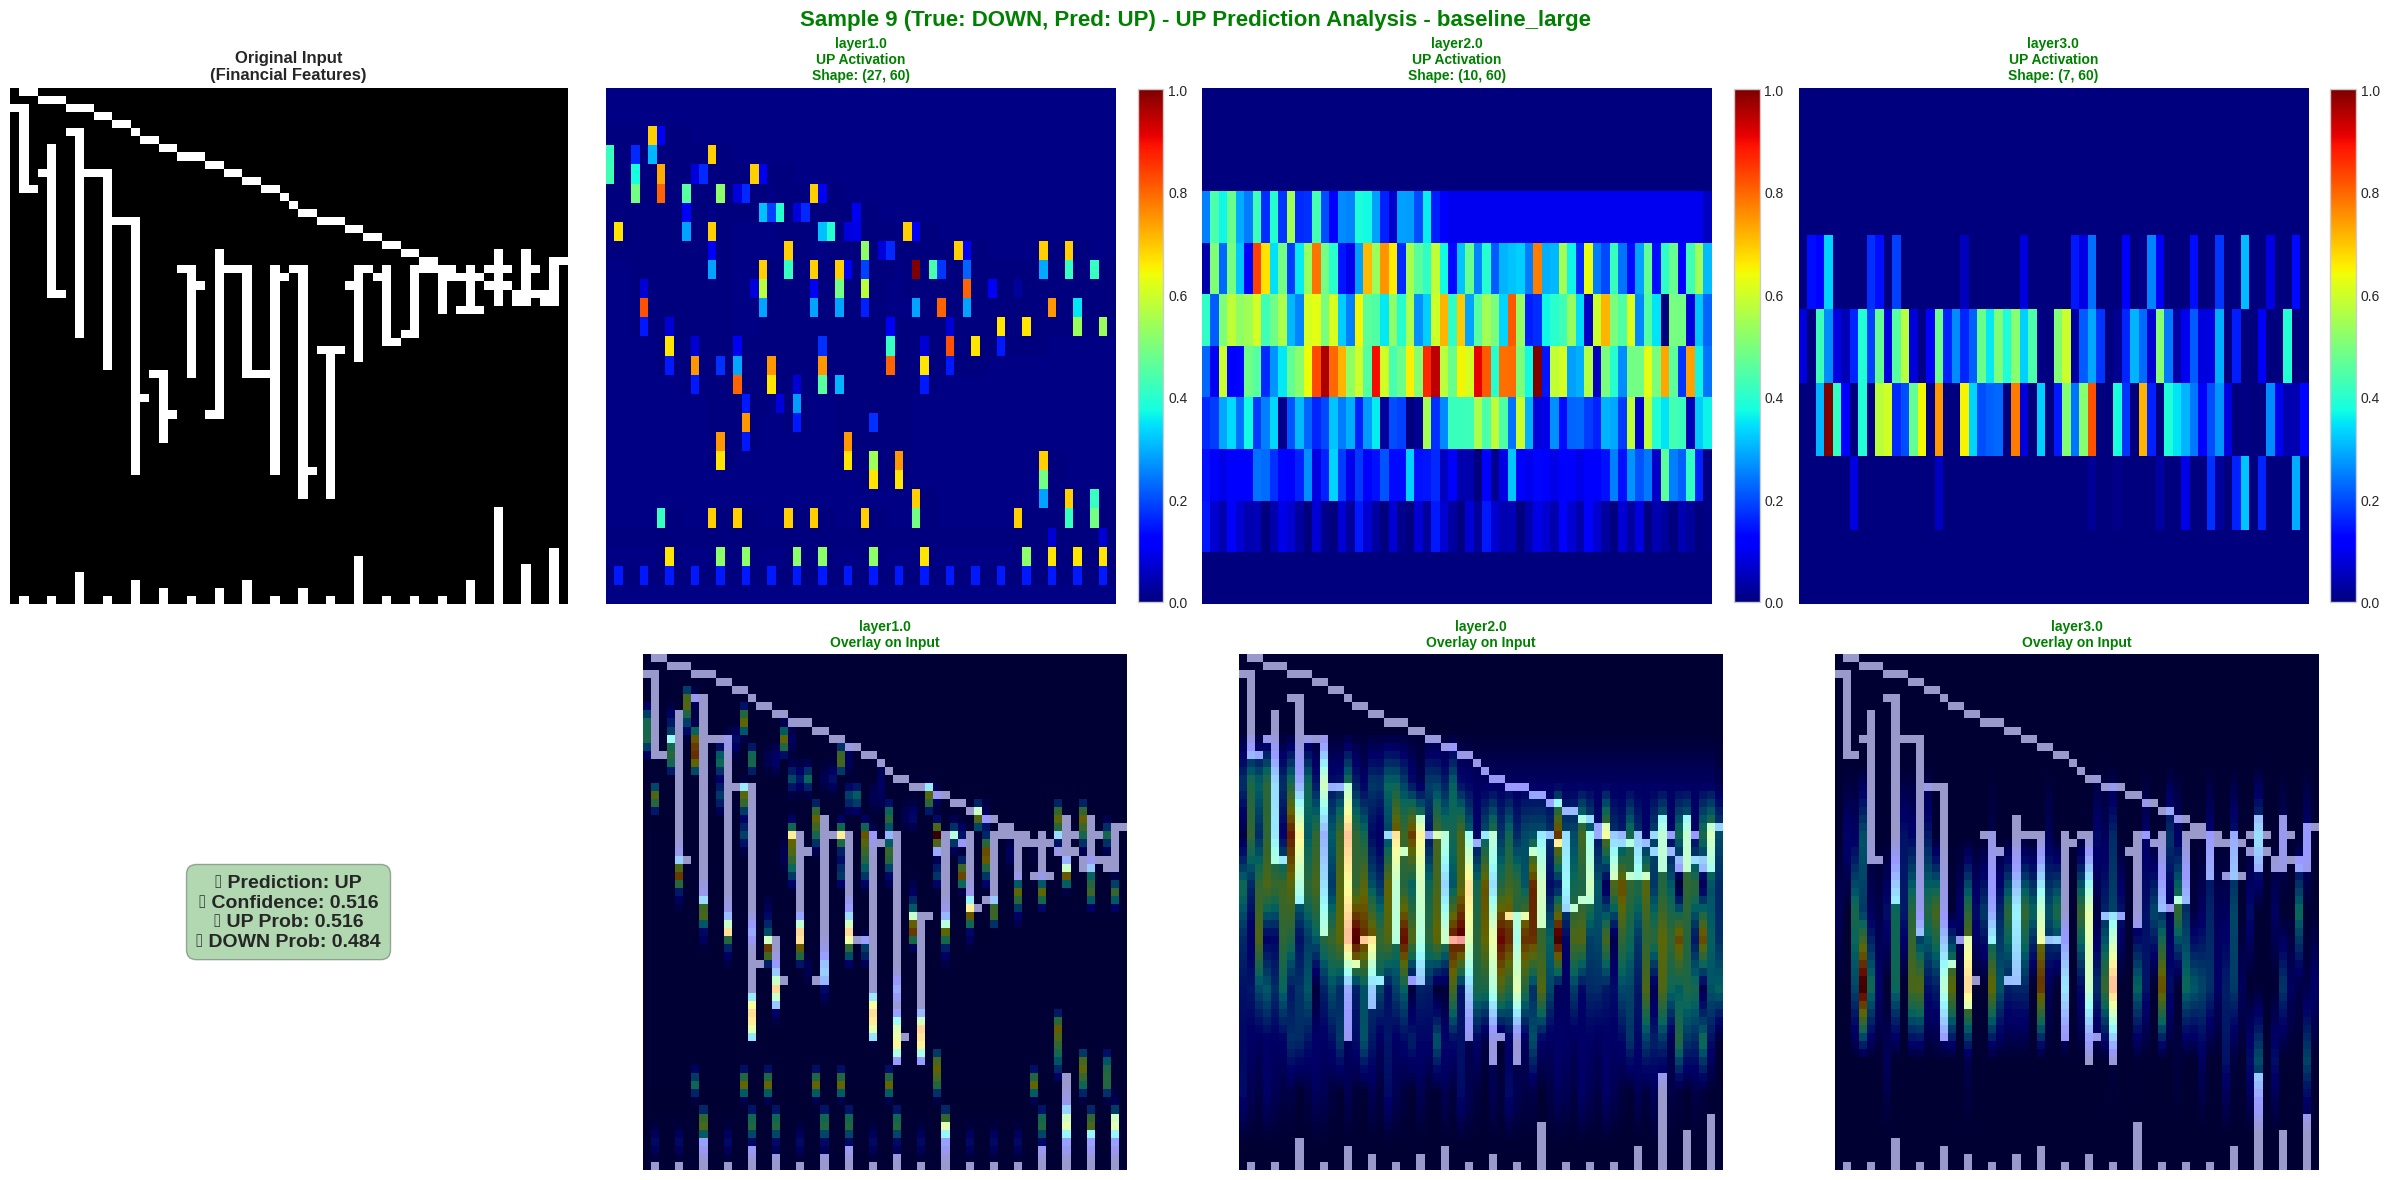

✅ Successfully analyzed UP prediction for sample 9
✅ Custom Grad-CAM analysis completed. Results saved to: gradcam_analysis_baseline_large

📊 Results Summary:
  Test Loss: 0.692632
  Accuracy: 0.5210
  Selected Stocks: 62,823 (4.47%)
  Cumulative Return (Baseline): 3.1792
  Cumulative Return (Strategy): 17.1079
  Excess Return: 13.9287

Testing Model with Custom Grad-CAM Analysis: vit
Model Path: ../pt/vit/best.pt
Model Parameters: 10,821,314 (10.82M)


[vit] Eval: 100%|██████████| 686/686 [01:20<00:00,  8.53it/s, loss=0.6935]



🔍 Performing Custom Grad-CAM Analysis...

🔍 Finding all convolution layers...
🔍 Found convolution layer: patch_embed.proj - Conv2d
    Conv2d: 1→384, kernel=(4, 4), stride=(4, 4)
✅ Found 1 convolution layers
Collected 10 samples

🎨 Starting multi-layer visualization for input shape: torch.Size([1, 64, 60])
🎯 Predicted class: UP (confidence: 0.510)

📏 Input tensor shape: torch.Size([1, 64, 60])
🔍 Forward hook [patch_embed.proj] - Shape: torch.Size([1, 384, 16, 15])
📏 Model output shape: torch.Size([1, 2])
🔍 Backward hook [patch_embed.proj] - Shape: torch.Size([1, 384, 16, 15])

🔧 Processing layer: patch_embed.proj
📏 Activations shape: torch.Size([1, 384, 16, 15])
📏 Gradients shape: torch.Size([1, 384, 16, 15])
📏 CAM shape for patch_embed.proj: (16, 15)
Multi-layer visualization saved to: gradcam_analysis_vit/UP_prediction_sample_0.png


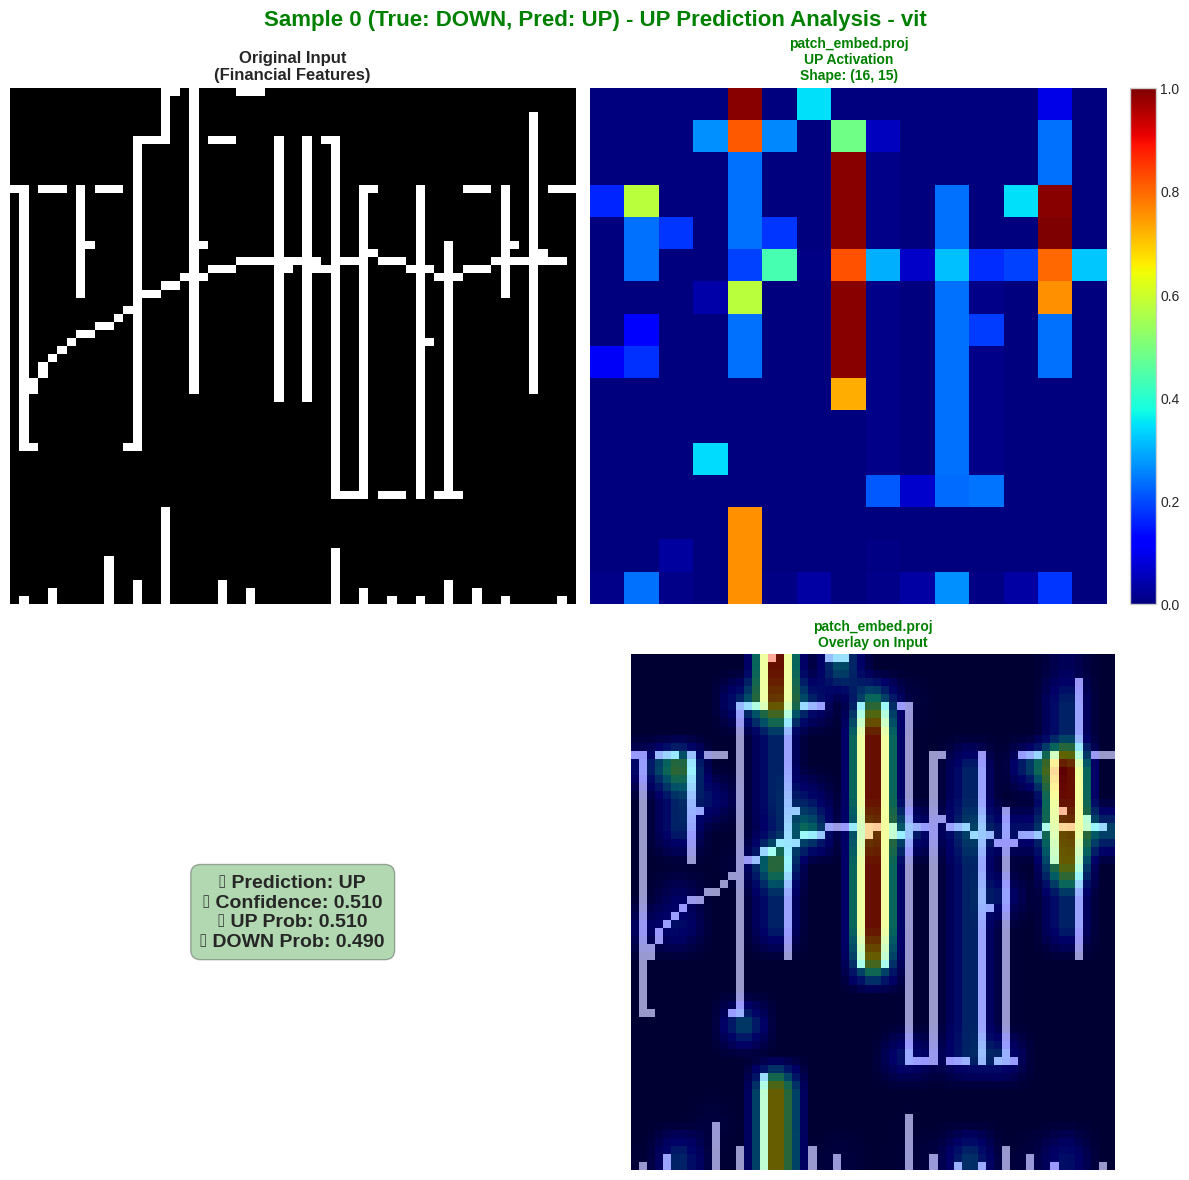

✅ Successfully analyzed UP prediction for sample 0

🎨 Starting multi-layer visualization for input shape: torch.Size([1, 64, 60])
🎯 Predicted class: DOWN (confidence: 0.511)

📏 Input tensor shape: torch.Size([1, 64, 60])
🔍 Forward hook [patch_embed.proj] - Shape: torch.Size([1, 384, 16, 15])
📏 Model output shape: torch.Size([1, 2])
🔍 Backward hook [patch_embed.proj] - Shape: torch.Size([1, 384, 16, 15])

🔧 Processing layer: patch_embed.proj
📏 Activations shape: torch.Size([1, 384, 16, 15])
📏 Gradients shape: torch.Size([1, 384, 16, 15])
📏 CAM shape for patch_embed.proj: (16, 15)
Multi-layer visualization saved to: gradcam_analysis_vit/DOWN_prediction_sample_1.png


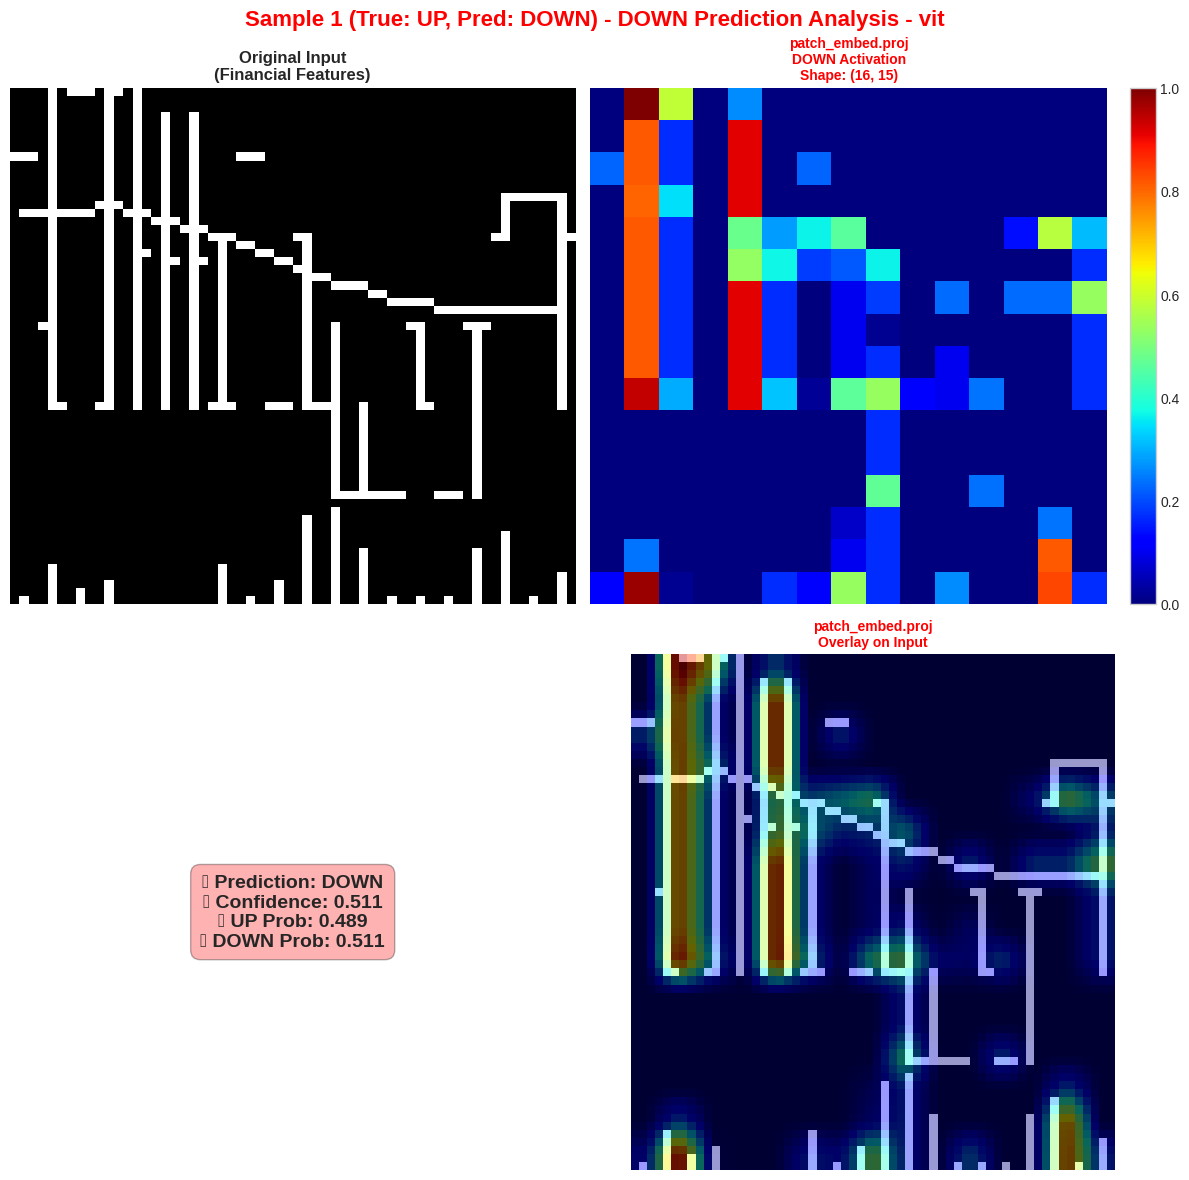

✅ Successfully analyzed DOWN prediction for sample 1

🎨 Starting multi-layer visualization for input shape: torch.Size([1, 64, 60])
🎯 Predicted class: DOWN (confidence: 0.511)

📏 Input tensor shape: torch.Size([1, 64, 60])
🔍 Forward hook [patch_embed.proj] - Shape: torch.Size([1, 384, 16, 15])
📏 Model output shape: torch.Size([1, 2])
🔍 Backward hook [patch_embed.proj] - Shape: torch.Size([1, 384, 16, 15])

🔧 Processing layer: patch_embed.proj
📏 Activations shape: torch.Size([1, 384, 16, 15])
📏 Gradients shape: torch.Size([1, 384, 16, 15])
📏 CAM shape for patch_embed.proj: (16, 15)
Multi-layer visualization saved to: gradcam_analysis_vit/DOWN_prediction_sample_2.png


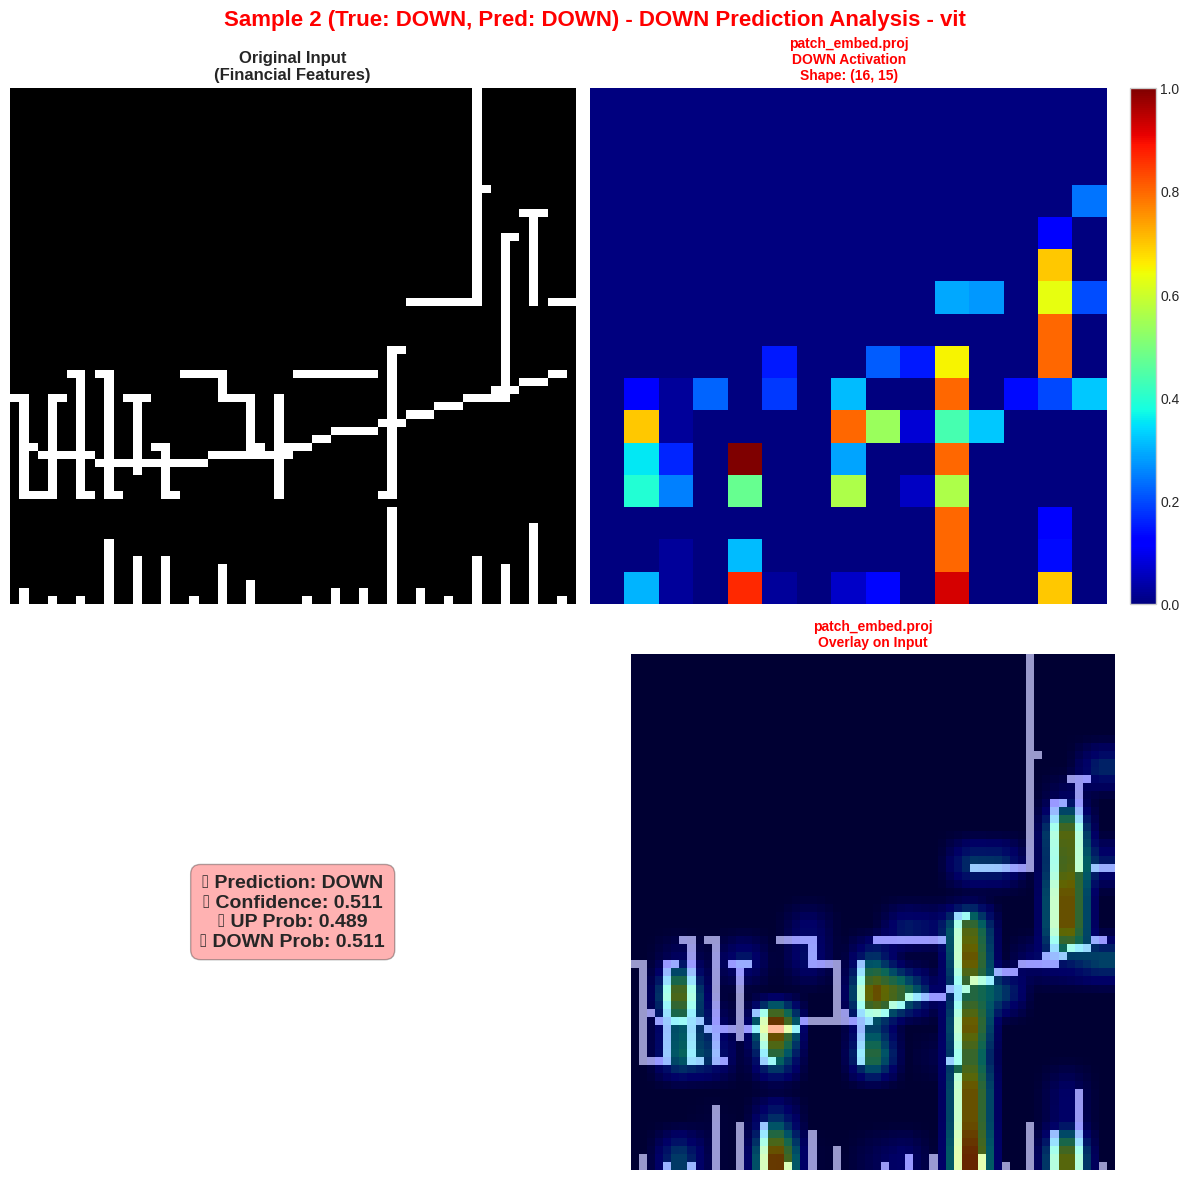

✅ Successfully analyzed DOWN prediction for sample 2

🎨 Starting multi-layer visualization for input shape: torch.Size([1, 64, 60])
🎯 Predicted class: DOWN (confidence: 0.504)

📏 Input tensor shape: torch.Size([1, 64, 60])
🔍 Forward hook [patch_embed.proj] - Shape: torch.Size([1, 384, 16, 15])
📏 Model output shape: torch.Size([1, 2])
🔍 Backward hook [patch_embed.proj] - Shape: torch.Size([1, 384, 16, 15])

🔧 Processing layer: patch_embed.proj
📏 Activations shape: torch.Size([1, 384, 16, 15])
📏 Gradients shape: torch.Size([1, 384, 16, 15])
📏 CAM shape for patch_embed.proj: (16, 15)
Multi-layer visualization saved to: gradcam_analysis_vit/DOWN_prediction_sample_3.png


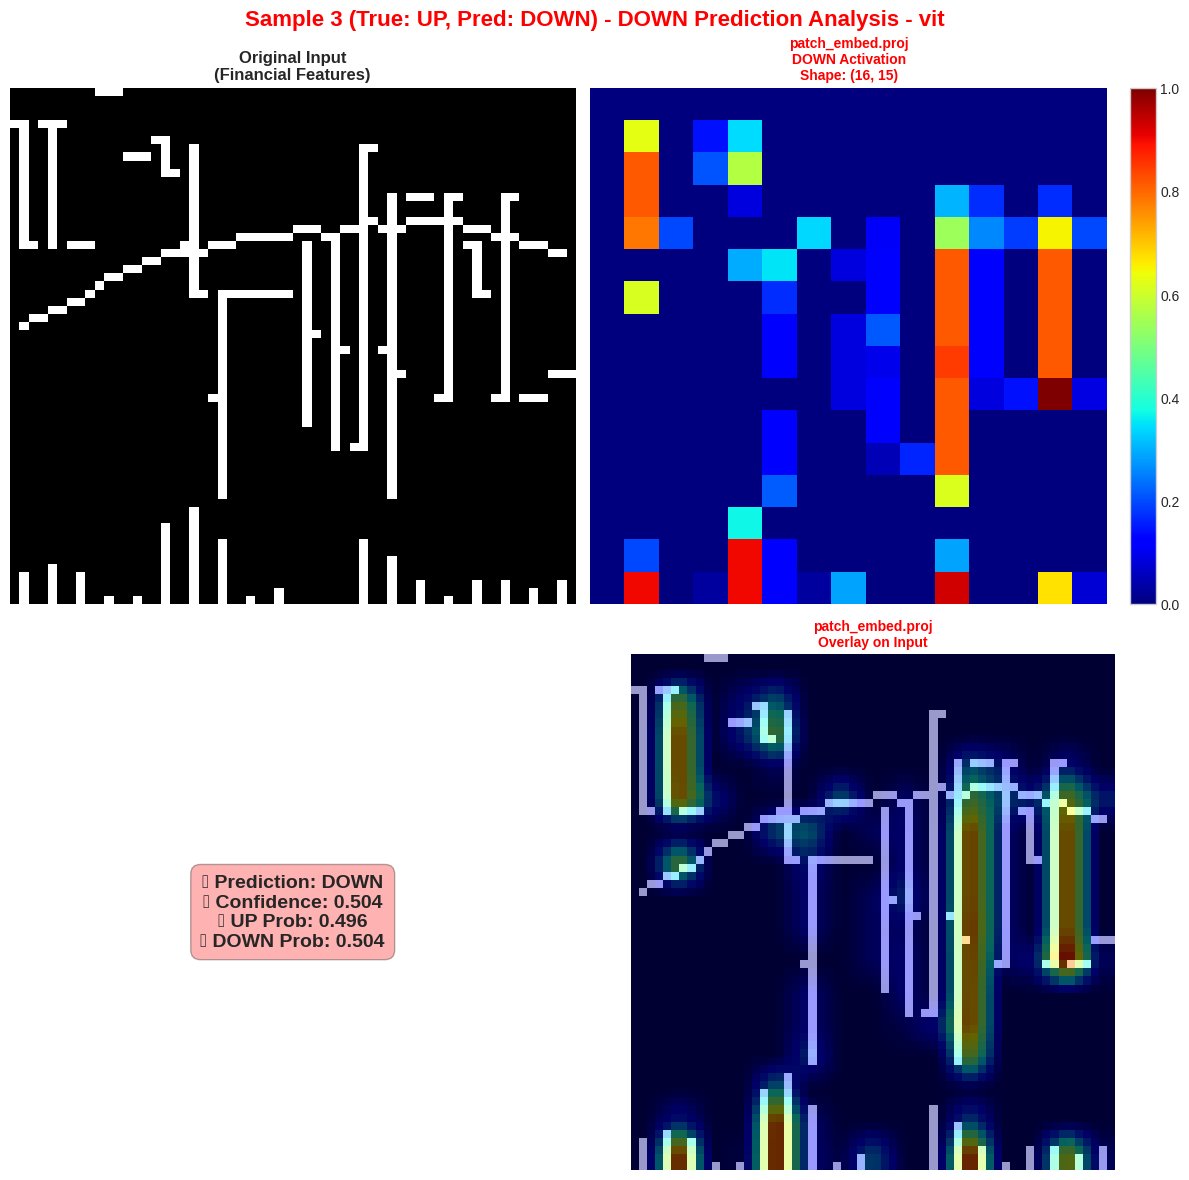

✅ Successfully analyzed DOWN prediction for sample 3

🎨 Starting multi-layer visualization for input shape: torch.Size([1, 64, 60])
🎯 Predicted class: DOWN (confidence: 0.511)

📏 Input tensor shape: torch.Size([1, 64, 60])
🔍 Forward hook [patch_embed.proj] - Shape: torch.Size([1, 384, 16, 15])
📏 Model output shape: torch.Size([1, 2])
🔍 Backward hook [patch_embed.proj] - Shape: torch.Size([1, 384, 16, 15])

🔧 Processing layer: patch_embed.proj
📏 Activations shape: torch.Size([1, 384, 16, 15])
📏 Gradients shape: torch.Size([1, 384, 16, 15])
📏 CAM shape for patch_embed.proj: (16, 15)
Multi-layer visualization saved to: gradcam_analysis_vit/DOWN_prediction_sample_4.png


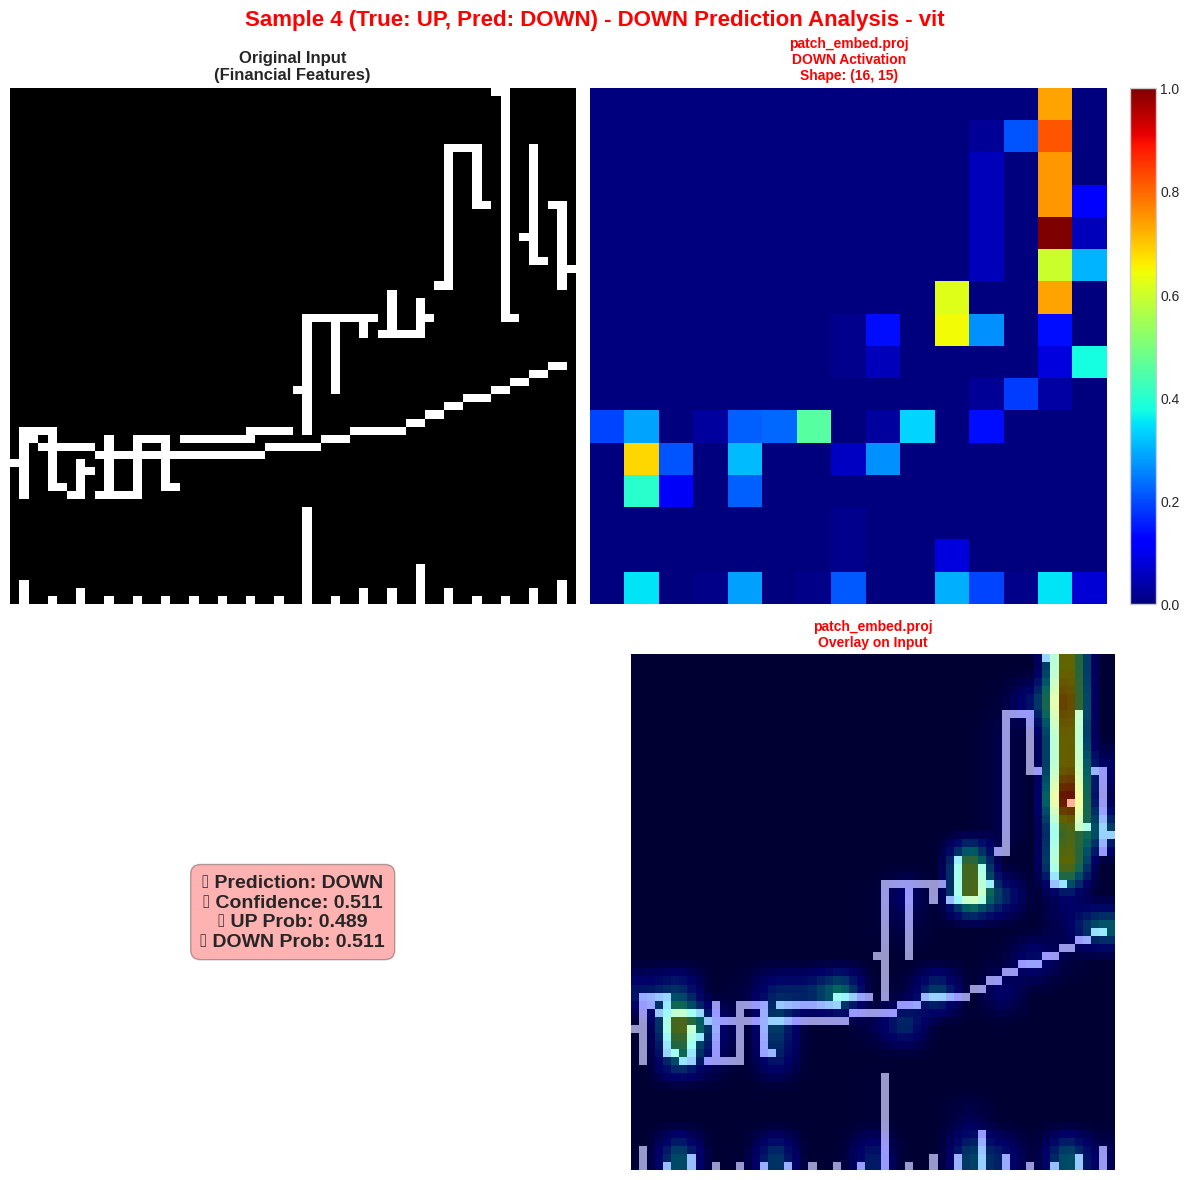

✅ Successfully analyzed DOWN prediction for sample 4

🎨 Starting multi-layer visualization for input shape: torch.Size([1, 64, 60])
🎯 Predicted class: DOWN (confidence: 0.519)

📏 Input tensor shape: torch.Size([1, 64, 60])
🔍 Forward hook [patch_embed.proj] - Shape: torch.Size([1, 384, 16, 15])
📏 Model output shape: torch.Size([1, 2])
🔍 Backward hook [patch_embed.proj] - Shape: torch.Size([1, 384, 16, 15])

🔧 Processing layer: patch_embed.proj
📏 Activations shape: torch.Size([1, 384, 16, 15])
📏 Gradients shape: torch.Size([1, 384, 16, 15])
📏 CAM shape for patch_embed.proj: (16, 15)
Multi-layer visualization saved to: gradcam_analysis_vit/DOWN_prediction_sample_5.png


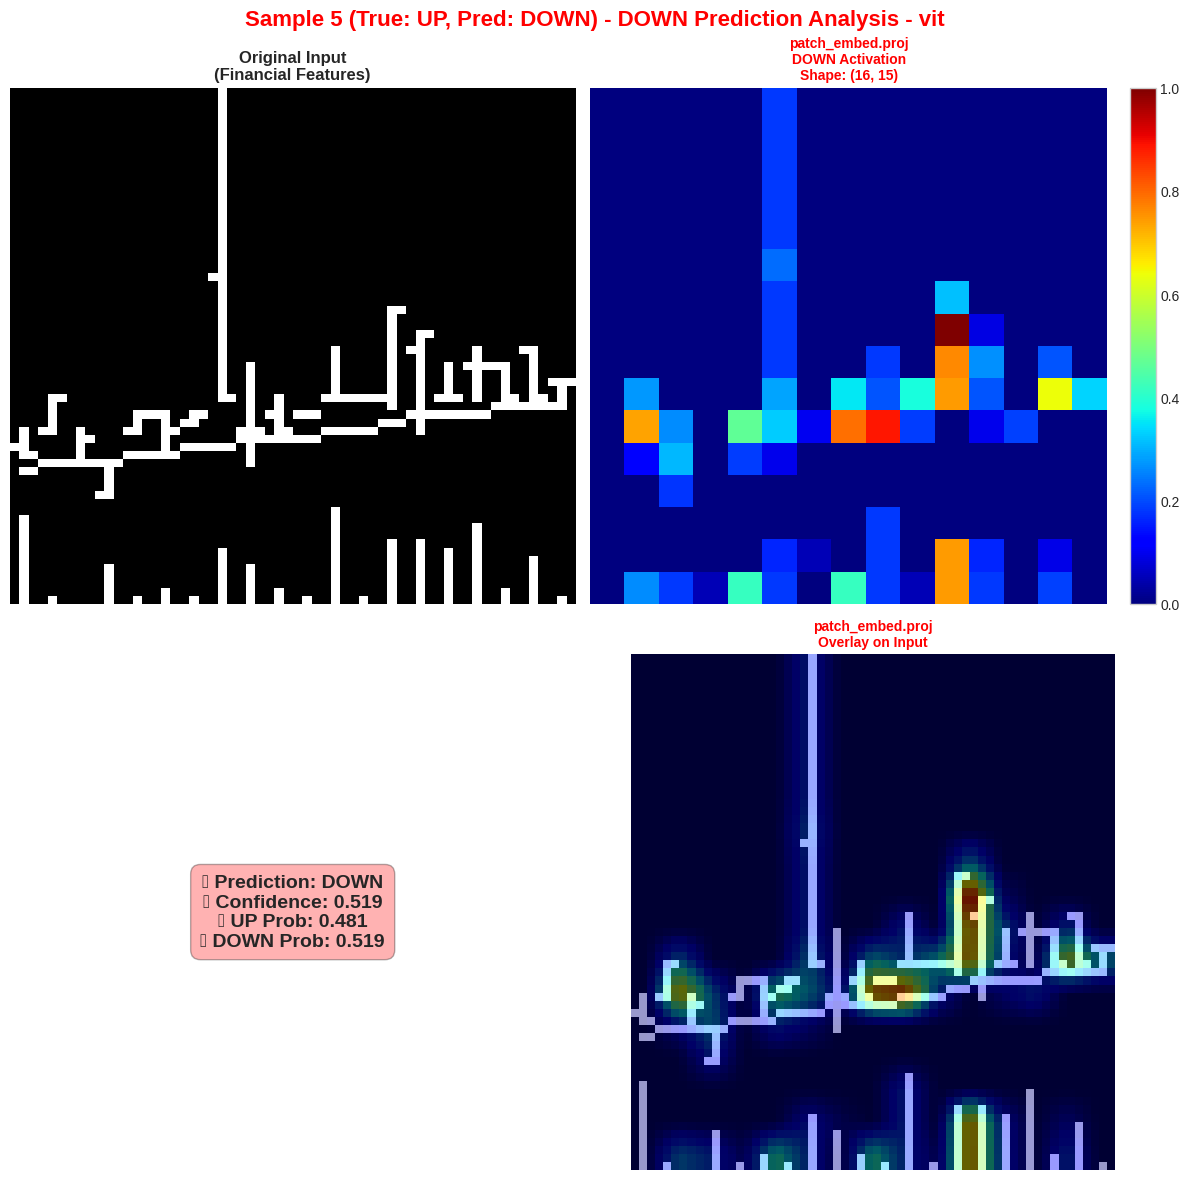

✅ Successfully analyzed DOWN prediction for sample 5

🎨 Starting multi-layer visualization for input shape: torch.Size([1, 64, 60])
🎯 Predicted class: DOWN (confidence: 0.516)

📏 Input tensor shape: torch.Size([1, 64, 60])
🔍 Forward hook [patch_embed.proj] - Shape: torch.Size([1, 384, 16, 15])
📏 Model output shape: torch.Size([1, 2])
🔍 Backward hook [patch_embed.proj] - Shape: torch.Size([1, 384, 16, 15])

🔧 Processing layer: patch_embed.proj
📏 Activations shape: torch.Size([1, 384, 16, 15])
📏 Gradients shape: torch.Size([1, 384, 16, 15])
📏 CAM shape for patch_embed.proj: (16, 15)
Multi-layer visualization saved to: gradcam_analysis_vit/DOWN_prediction_sample_6.png


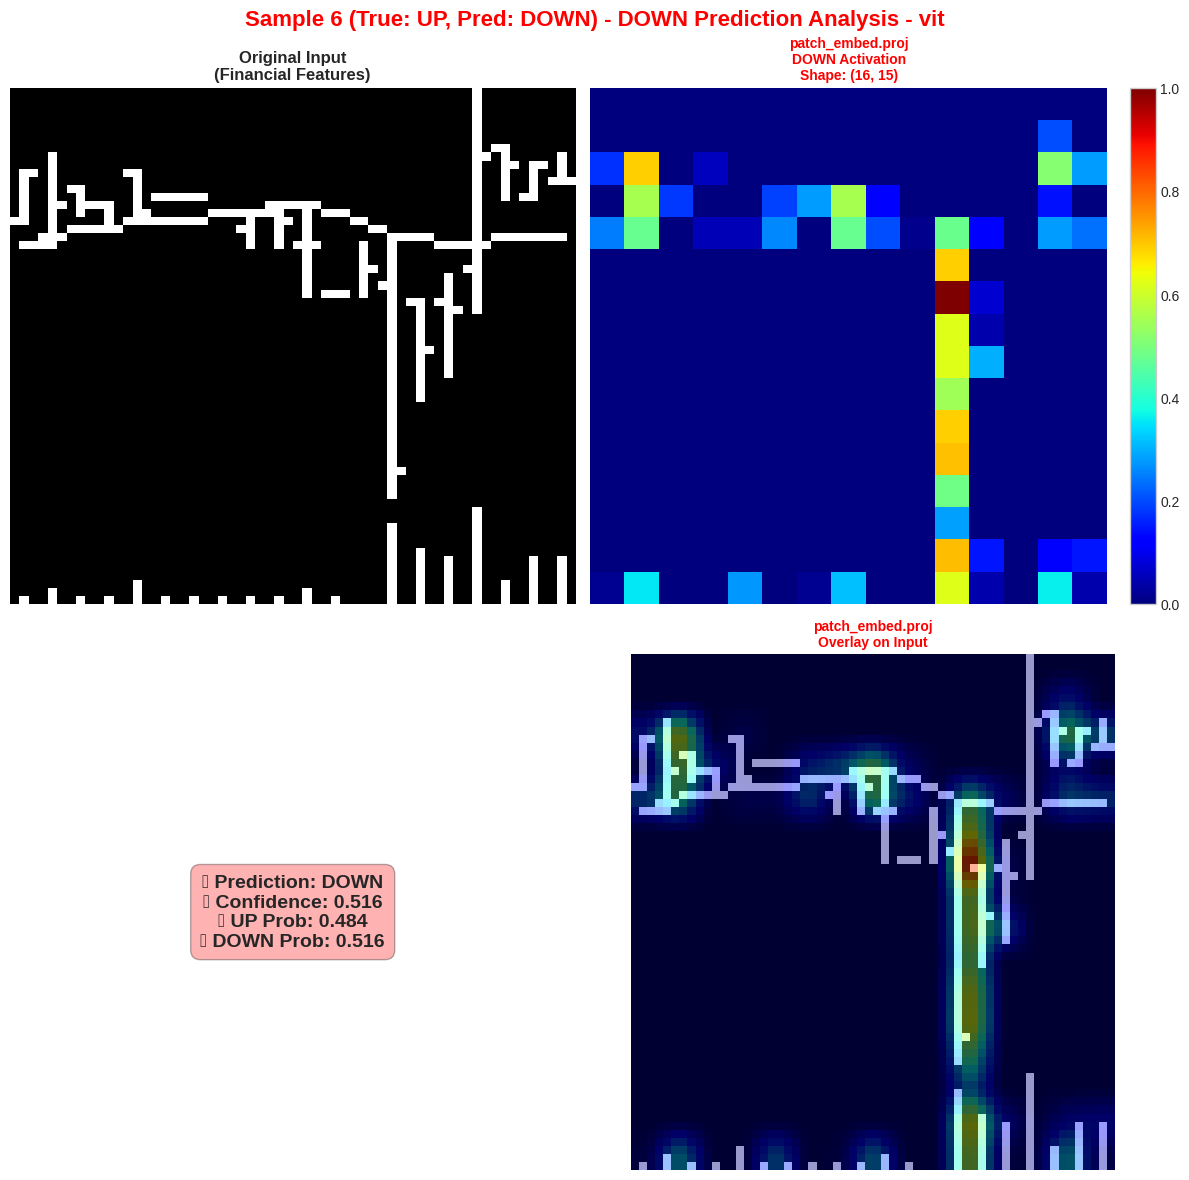

✅ Successfully analyzed DOWN prediction for sample 6

🎨 Starting multi-layer visualization for input shape: torch.Size([1, 64, 60])
🎯 Predicted class: UP (confidence: 0.518)

📏 Input tensor shape: torch.Size([1, 64, 60])
🔍 Forward hook [patch_embed.proj] - Shape: torch.Size([1, 384, 16, 15])
📏 Model output shape: torch.Size([1, 2])
🔍 Backward hook [patch_embed.proj] - Shape: torch.Size([1, 384, 16, 15])

🔧 Processing layer: patch_embed.proj
📏 Activations shape: torch.Size([1, 384, 16, 15])
📏 Gradients shape: torch.Size([1, 384, 16, 15])
📏 CAM shape for patch_embed.proj: (16, 15)
Multi-layer visualization saved to: gradcam_analysis_vit/UP_prediction_sample_7.png


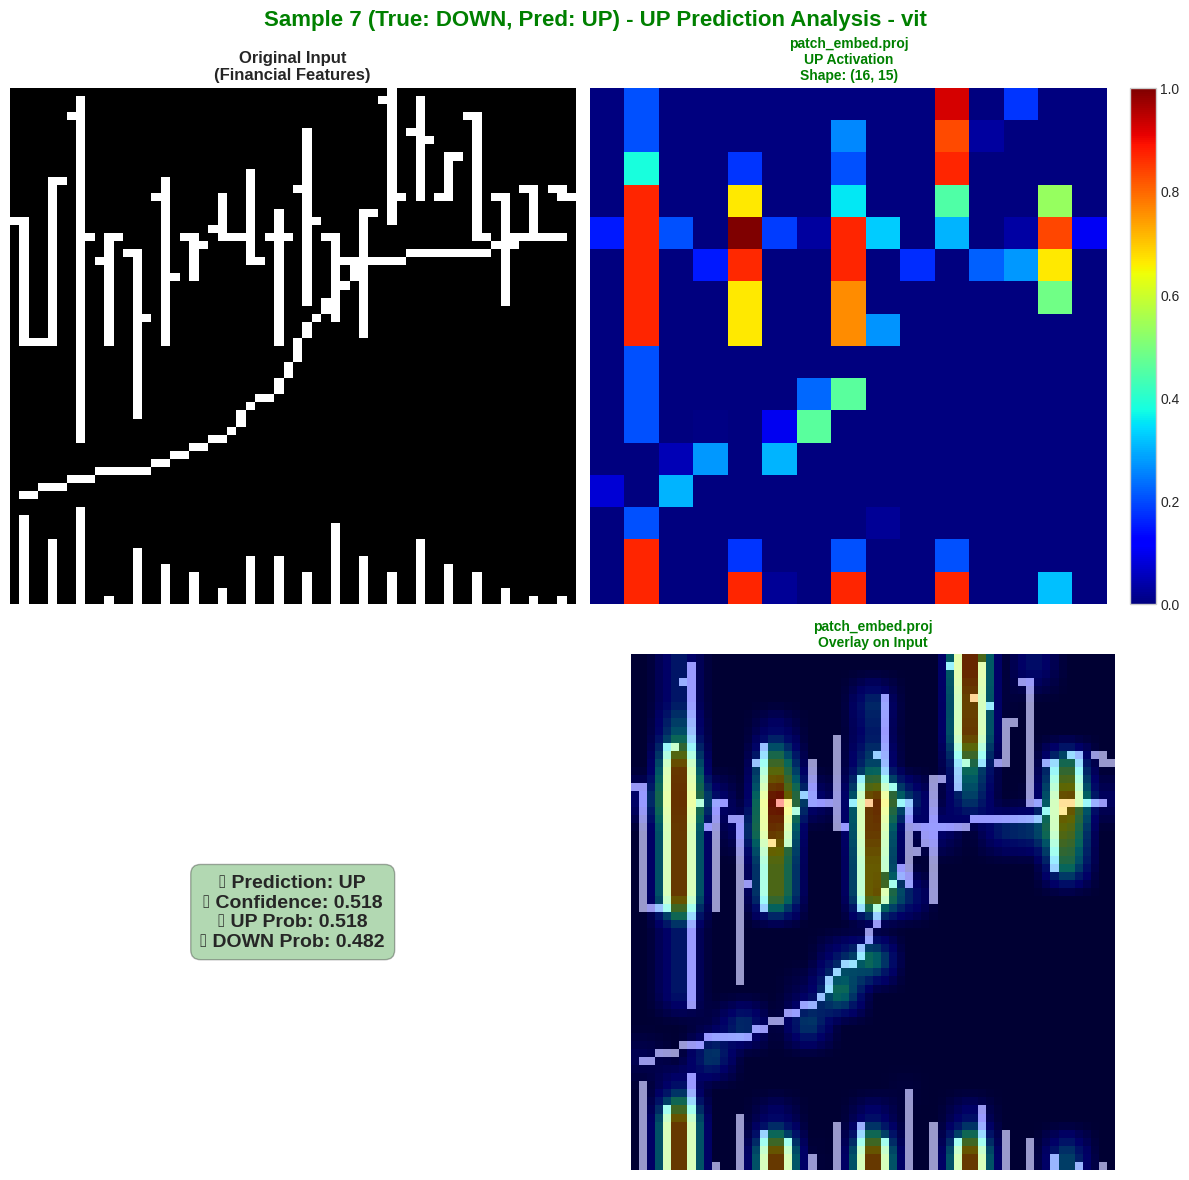

✅ Successfully analyzed UP prediction for sample 7

🎨 Starting multi-layer visualization for input shape: torch.Size([1, 64, 60])
🎯 Predicted class: DOWN (confidence: 0.521)

📏 Input tensor shape: torch.Size([1, 64, 60])
🔍 Forward hook [patch_embed.proj] - Shape: torch.Size([1, 384, 16, 15])
📏 Model output shape: torch.Size([1, 2])
🔍 Backward hook [patch_embed.proj] - Shape: torch.Size([1, 384, 16, 15])

🔧 Processing layer: patch_embed.proj
📏 Activations shape: torch.Size([1, 384, 16, 15])
📏 Gradients shape: torch.Size([1, 384, 16, 15])
📏 CAM shape for patch_embed.proj: (16, 15)
Multi-layer visualization saved to: gradcam_analysis_vit/DOWN_prediction_sample_8.png


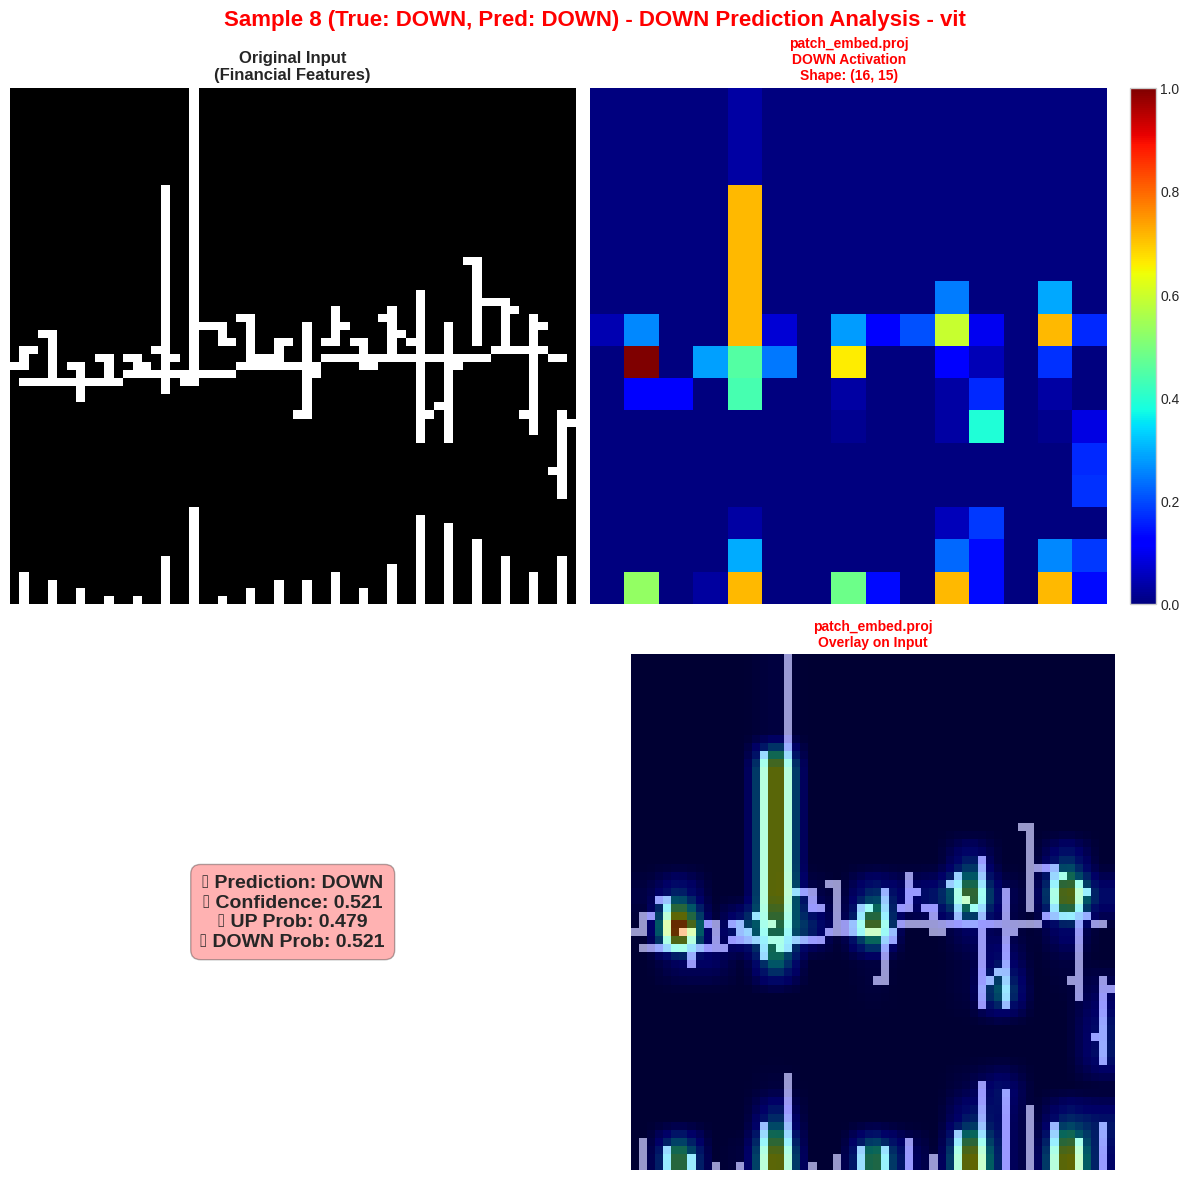

✅ Successfully analyzed DOWN prediction for sample 8

🎨 Starting multi-layer visualization for input shape: torch.Size([1, 64, 60])
🎯 Predicted class: DOWN (confidence: 0.513)

📏 Input tensor shape: torch.Size([1, 64, 60])
🔍 Forward hook [patch_embed.proj] - Shape: torch.Size([1, 384, 16, 15])
📏 Model output shape: torch.Size([1, 2])
🔍 Backward hook [patch_embed.proj] - Shape: torch.Size([1, 384, 16, 15])

🔧 Processing layer: patch_embed.proj
📏 Activations shape: torch.Size([1, 384, 16, 15])
📏 Gradients shape: torch.Size([1, 384, 16, 15])
📏 CAM shape for patch_embed.proj: (16, 15)
Multi-layer visualization saved to: gradcam_analysis_vit/DOWN_prediction_sample_9.png


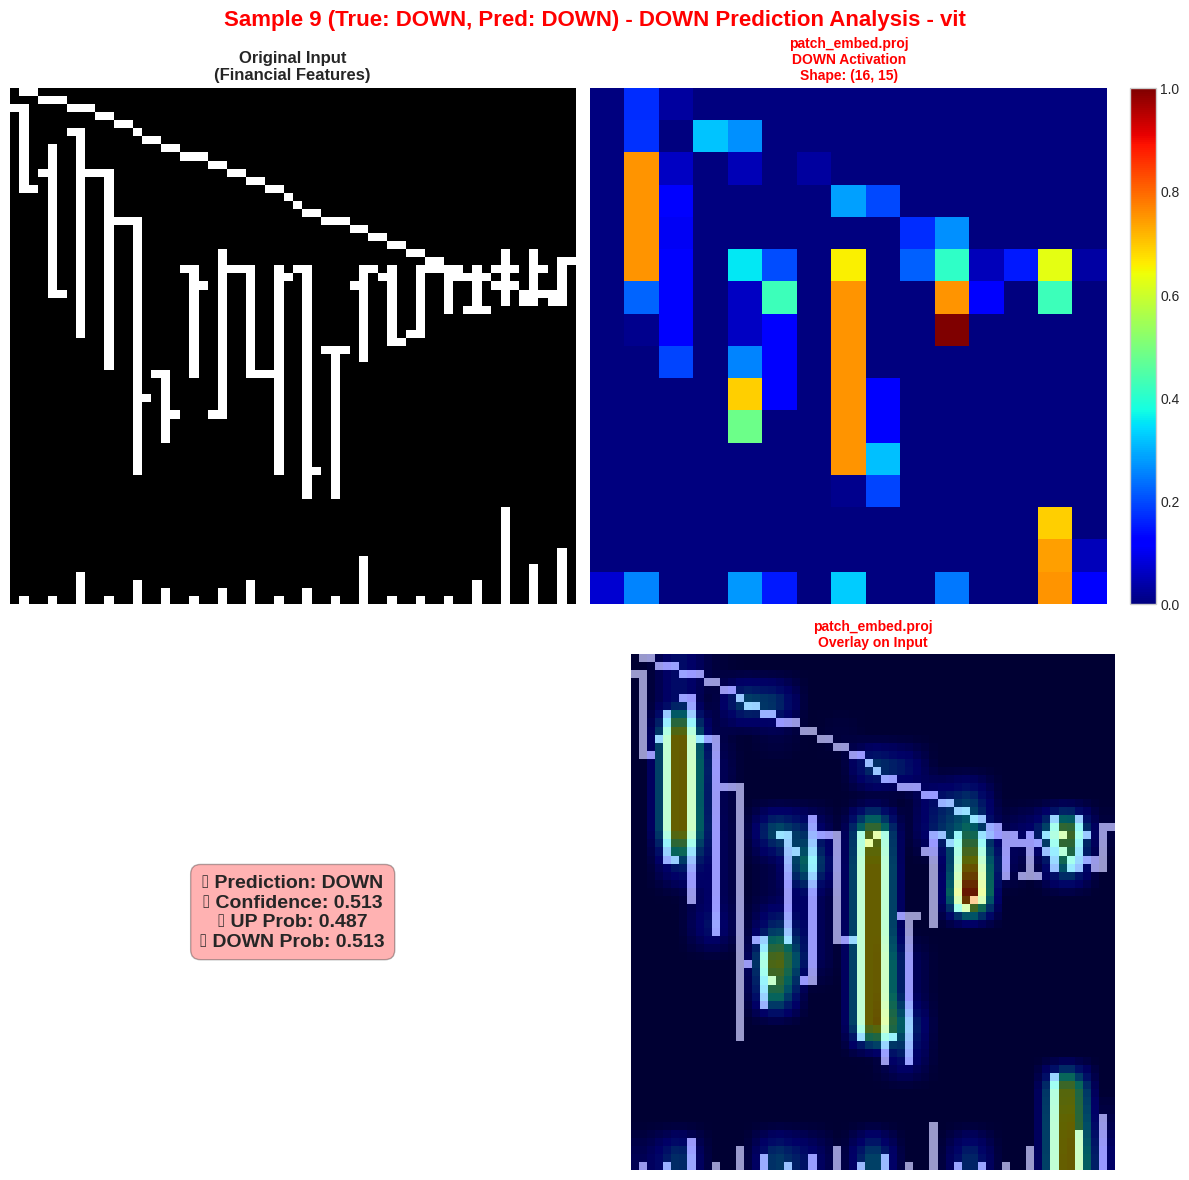

✅ Successfully analyzed DOWN prediction for sample 9
✅ Custom Grad-CAM analysis completed. Results saved to: gradcam_analysis_vit

📊 Results Summary:
  Test Loss: 0.693470
  Accuracy: 0.4984
  Selected Stocks: 326,761 (23.27%)
  Cumulative Return (Baseline): 3.1792
  Cumulative Return (Strategy): 2.8440
  Excess Return: -0.3352


All Models Testing Complete!


In [52]:
# 测试所有模型
print("\n" + "#"*70)
print("# Testing All Models")
print("#"*70)

for model_type in model_types:
    model_path = model_paths[model_type]
    model_threshold = thresholds[model_type]
    
    results = test_single_model_with_gradcam(
        model_type=model_type,
        model_path=model_path,
        test_dataloader=test_dataloader,
        label_df_original=label_df_original,
        device=device,
        threshold=model_threshold
    )
    
    if results is not None:
        all_test_results[model_type] = results

print("\n\n" + "="*70)
print("All Models Testing Complete!")
print("="*70)